In [1]:
!pip install torch torchvision torchaudio gymnasium pandas numpy matplotlib tqdm mpmath==1.2.1


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt


In [3]:
data = pd.read_csv("train_data.csv")

# Drop timestamp or non-numeric columns if they exist
if 'timestamp' in data.columns:
    data = data.drop(columns=['timestamp'])

# Ensure numeric and fill missing values
data = data.apply(pd.to_numeric, errors='coerce').fillna(0)

print("Shape:", data.shape)
data.head()


Shape: (1400, 31)


,location_id,traffic_volume,avg_vehicle_speed,vehicle_count_cars,vehicle_count_trucks,vehicle_count_bikes,weather_condition,temperature,humidity,accident_reported,...,bike_ratio,weather_impact,weather_Cloudy,weather_Foggy,weather_Rainy,weather_Sunny,weather_Windy,signal_Green,signal_Red,signal_Yellow
0,1.00,0.902954,0.800401,0.098976,0.545455,1.000000,0.0,0.979439,0.537649,0,...,0.342553,0.652536,True,False,False,False,False,False,False,True
1,0.75,0.161392,0.319762,0.440273,0.424242,0.775510,0.0,0.884096,0.048955,0,...,0.114553,0.265677,False,False,False,True,False,False,True,False
2,0.00,0.875527,0.599970,0.240046,0.181818,0.489796,0.0,0.132513,0.284103,0,...,0.129062,0.112905,False,False,False,False,True,False,True,False
3,0.50,0.952532,0.408853,0.609784,0.373737,0.857143,0.0,0.941542,0.890744,0,...,0.097102,0.883883,False,False,True,False,False,False,False,True
4,0.00,0.181435,0.544669,0.489192,0.868687,0.836735,0.0,0.472614,0.465641,0,...,0.104318,0.339227,False,False,False,False,True,False,True,False


In [4]:
class TrafficEnv(gym.Env):
    def __init__(self, data):
        super(TrafficEnv, self).__init__()
        self.data = data.reset_index(drop=True)
        self.max_index = len(data) - 1

        # Define spaces
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(len(data.columns)-1,), dtype=np.float32)
        self.action_space = spaces.Discrete(4)  # 4 signal phases

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        # Start from a random point in dataset
        self.current_step = np.random.randint(0, self.max_index - 50)
        obs = self.data.iloc[self.current_step, :-1].values.astype(np.float32)
        info = {}
        return obs, info

    def step(self, action):
        self.current_step += 1
        done = self.current_step >= self.max_index

        row = self.data.iloc[self.current_step]
        wait_time = row.get('waiting_time', 0)
        queue_len = row.get('queue_length', 0)
        emergency = row.get('emergency_detected', 0) if 'emergency_detected' in row else 0

        reward = self.compute_reward(wait_time, queue_len, emergency, action)
        next_obs = row[:-1].values.astype(np.float32)
        truncated = False
        info = {}

        return next_obs, reward, done, truncated, info

    def compute_reward(self, wait_time, queue_len, emergency_detected, action):
        reward = - (0.7 * wait_time + 0.3 * queue_len)
        if emergency_detected and action == 0:  # example: NS-green helps emergency
            reward += 20
        return reward

    def render(self):
        pass


In [5]:
'''def compute_reward(wait_time, queue_len, emergency_detected):

    reward = - (0.7 * wait_time + 0.3 * queue_len)
    if emergency_detected:
        reward += 20  # positive reward for prioritizing emergency
    return reward'''


'def compute_reward(wait_time, queue_len, emergency_detected):\n\n    reward = - (0.7 * wait_time + 0.3 * queue_len)\n    if emergency_detected:\n        reward += 20  # positive reward for prioritizing emergency\n    return reward'

In [6]:
class PPOAgent(nn.Module):
    def __init__(self, state_dim, action_dim, lr=3e-4):
        super(PPOAgent, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    def act(self, state):
        state = torch.FloatTensor(state)
        probs = self.actor(state)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action)

    def evaluate(self, state, action):
        probs = self.actor(state)
        dist = torch.distributions.Categorical(probs)
        log_prob = dist.log_prob(action)
        entropy = dist.entropy()
        return log_prob, self.critic(state), entropy


In [7]:
env = TrafficEnv(data)
agent = PPOAgent(state_dim=len(data.columns)-1, action_dim=4)

def train_ppo(episodes=200, gamma=0.99, clip_epsilon=0.2):
    reward_history = []

    for episode in tqdm(range(episodes)):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action, log_prob = agent.act(state)
            next_state, reward, done, truncated, _ = env.step(action)

            # PPO updates
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
            reward_tensor = torch.tensor(reward, dtype=torch.float32)

            value = agent.critic(state_tensor)
            next_value = agent.critic(next_state_tensor)
            advantage = reward_tensor + gamma * next_value - value

            new_log_prob, _, entropy = agent.evaluate(
                state_tensor, torch.tensor([action], dtype=torch.long)
            )

            ratio = (new_log_prob - log_prob).exp()
            surr1 = ratio * advantage.detach()
            surr2 = torch.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon) * advantage.detach()
            loss = -torch.min(surr1, surr2) + 0.5 * advantage.pow(2) - 0.01 * entropy

            agent.optimizer.zero_grad()
            loss.mean().backward()
            agent.optimizer.step()

            total_reward += reward
            state = next_state

        reward_history.append(total_reward)
        print(f"Episode {episode+1} | Total Reward: {total_reward:.2f}")

    return reward_history

rewards = train_ppo(episodes=200)


  1%|          | 2/200 [00:01<02:08,  1.54it/s]

Episode 1 | Total Reward: -14.37
Episode 2 | Total Reward: -4.21


  2%|▏         | 3/200 [00:02<02:39,  1.23it/s]

Episode 3 | Total Reward: -31.40


  2%|▏         | 4/200 [00:04<03:33,  1.09s/it]

Episode 4 | Total Reward: -47.43


  2%|▎         | 5/200 [00:04<03:00,  1.08it/s]

Episode 5 | Total Reward: -20.17


  3%|▎         | 6/200 [00:05<02:48,  1.15it/s]

Episode 6 | Total Reward: -24.12


  4%|▎         | 7/200 [00:06<02:59,  1.08it/s]

Episode 7 | Total Reward: -32.52


  4%|▍         | 9/200 [00:07<01:52,  1.70it/s]

Episode 8 | Total Reward: -14.47
Episode 9 | Total Reward: -5.60


  6%|▌         | 11/200 [00:10<02:54,  1.08it/s]

Episode 10 | Total Reward: -89.15
Episode 11 | Total Reward: -5.17


  6%|▌         | 12/200 [00:11<03:16,  1.05s/it]

Episode 12 | Total Reward: -42.37


  6%|▋         | 13/200 [00:11<02:33,  1.22it/s]

Episode 13 | Total Reward: -10.25


  8%|▊         | 15/200 [00:12<01:50,  1.67it/s]

Episode 14 | Total Reward: -23.39
Episode 15 | Total Reward: -4.69


  8%|▊         | 17/200 [00:12<01:13,  2.48it/s]

Episode 16 | Total Reward: -8.73
Episode 17 | Total Reward: -6.57


  9%|▉         | 18/200 [00:13<01:31,  1.99it/s]

Episode 18 | Total Reward: -23.49


 10%|▉         | 19/200 [00:15<03:06,  1.03s/it]

Episode 19 | Total Reward: -73.05


 10%|█         | 20/200 [00:18<04:11,  1.40s/it]

Episode 20 | Total Reward: -70.94


 10%|█         | 21/200 [00:19<03:42,  1.25s/it]

Episode 21 | Total Reward: -28.21


 11%|█         | 22/200 [00:20<03:33,  1.20s/it]

Episode 22 | Total Reward: -33.93


 12%|█▏        | 23/200 [00:20<02:45,  1.07it/s]

Episode 23 | Total Reward: -10.92


 12%|█▏        | 24/200 [00:21<03:04,  1.05s/it]

Episode 24 | Total Reward: -42.07


 12%|█▎        | 25/200 [00:22<02:55,  1.00s/it]

Episode 25 | Total Reward: -28.01


 13%|█▎        | 26/200 [00:23<02:43,  1.06it/s]

Episode 26 | Total Reward: -25.74


 14%|█▎        | 27/200 [00:24<02:38,  1.09it/s]

Episode 27 | Total Reward: -27.52


 14%|█▍        | 28/200 [00:26<03:22,  1.18s/it]

Episode 28 | Total Reward: -56.55


 14%|█▍        | 29/200 [00:26<02:44,  1.04it/s]

Episode 29 | Total Reward: -13.90


 15%|█▌        | 30/200 [00:29<04:26,  1.57s/it]

Episode 30 | Total Reward: -96.88


 16%|█▌        | 31/200 [00:30<03:51,  1.37s/it]

Episode 31 | Total Reward: -28.50


 16%|█▌        | 32/200 [00:30<03:00,  1.08s/it]

Episode 32 | Total Reward: -12.98


 16%|█▋        | 33/200 [00:32<03:18,  1.19s/it]

Episode 33 | Total Reward: -46.61


 17%|█▋        | 34/200 [00:34<04:24,  1.59s/it]

Episode 34 | Total Reward: -80.76


 18%|█▊        | 35/200 [00:37<04:53,  1.78s/it]

Episode 35 | Total Reward: -70.36


 18%|█▊        | 36/200 [00:39<05:08,  1.88s/it]

Episode 36 | Total Reward: -69.37


 18%|█▊        | 37/200 [00:39<04:06,  1.51s/it]

Episode 37 | Total Reward: -19.86


 19%|█▉        | 38/200 [00:40<03:15,  1.21s/it]

Episode 38 | Total Reward: -15.29


 20%|█▉        | 39/200 [00:41<03:01,  1.13s/it]

Episode 39 | Total Reward: -29.81


 20%|██        | 40/200 [00:44<04:29,  1.68s/it]

Episode 40 | Total Reward: -97.98


 20%|██        | 41/200 [00:44<03:38,  1.38s/it]

Episode 41 | Total Reward: -20.57


 21%|██        | 42/200 [00:45<03:13,  1.22s/it]

Episode 42 | Total Reward: -26.68


 22%|██▏       | 43/200 [00:46<02:41,  1.03s/it]

Episode 43 | Total Reward: -18.68


 22%|██▏       | 44/200 [00:47<02:44,  1.05s/it]

Episode 44 | Total Reward: -34.16


 22%|██▎       | 45/200 [00:48<03:00,  1.16s/it]

Episode 45 | Total Reward: -44.95


 23%|██▎       | 46/200 [00:51<04:17,  1.67s/it]

Episode 46 | Total Reward: -90.48


 24%|██▎       | 47/200 [00:52<03:21,  1.32s/it]

Episode 47 | Total Reward: -15.89


 24%|██▍       | 48/200 [00:54<04:13,  1.67s/it]

Episode 48 | Total Reward: -80.76


 24%|██▍       | 49/200 [00:56<04:00,  1.59s/it]

Episode 49 | Total Reward: -43.96


 25%|██▌       | 50/200 [00:56<03:05,  1.24s/it]

Episode 50 | Total Reward: -13.22


 26%|██▌       | 51/200 [00:59<04:07,  1.66s/it]

Episode 51 | Total Reward: -85.18


 26%|██▌       | 52/200 [01:00<03:44,  1.51s/it]

Episode 52 | Total Reward: -36.68


 26%|██▋       | 53/200 [01:02<03:57,  1.62s/it]

Episode 53 | Total Reward: -57.47


 27%|██▋       | 54/200 [01:04<04:11,  1.73s/it]

Episode 54 | Total Reward: -62.81


 28%|██▊       | 55/200 [01:06<04:24,  1.83s/it]

Episode 55 | Total Reward: -65.75


 28%|██▊       | 56/200 [01:09<05:08,  2.14s/it]

Episode 56 | Total Reward: -92.33


 28%|██▊       | 57/200 [01:10<04:47,  2.01s/it]

Episode 57 | Total Reward: -49.96


 29%|██▉       | 58/200 [01:11<03:57,  1.67s/it]

Episode 58 | Total Reward: -27.61


 30%|██▉       | 59/200 [01:14<04:32,  1.93s/it]

Episode 59 | Total Reward: -81.15


 30%|███       | 60/200 [01:15<03:40,  1.57s/it]

Episode 60 | Total Reward: -23.34


 30%|███       | 61/200 [01:15<02:55,  1.26s/it]

Episode 61 | Total Reward: -17.85


 31%|███       | 62/200 [01:15<02:18,  1.00s/it]

Episode 62 | Total Reward: -12.45


 32%|███▏      | 63/200 [01:16<02:04,  1.10it/s]

Episode 63 | Total Reward: -21.90


 32%|███▏      | 64/200 [01:19<03:28,  1.54s/it]

Episode 64 | Total Reward: -97.47


 32%|███▎      | 65/200 [01:21<03:57,  1.76s/it]

Episode 65 | Total Reward: -73.16


 33%|███▎      | 66/200 [01:23<03:59,  1.79s/it]

Episode 66 | Total Reward: -57.32


 34%|███▎      | 67/200 [01:25<03:43,  1.68s/it]

Episode 67 | Total Reward: -45.08


 34%|███▍      | 68/200 [01:28<04:31,  2.06s/it]

Episode 68 | Total Reward: -93.36


 34%|███▍      | 69/200 [01:28<03:28,  1.59s/it]

Episode 69 | Total Reward: -16.07


 35%|███▌      | 70/200 [01:28<02:33,  1.18s/it]

Episode 70 | Total Reward: -8.01


 36%|███▌      | 71/200 [01:30<02:45,  1.28s/it]

Episode 71 | Total Reward: -47.49


 36%|███▌      | 72/200 [01:32<03:05,  1.45s/it]

Episode 72 | Total Reward: -57.76


 36%|███▋      | 73/200 [01:33<02:53,  1.36s/it]

Episode 73 | Total Reward: -37.37


 37%|███▋      | 74/200 [01:35<03:16,  1.56s/it]

Episode 74 | Total Reward: -63.50


 38%|███▊      | 75/200 [01:37<03:30,  1.69s/it]

Episode 75 | Total Reward: -63.50


 38%|███▊      | 76/200 [01:38<03:19,  1.61s/it]

Episode 76 | Total Reward: -44.69


 38%|███▊      | 77/200 [01:39<02:53,  1.41s/it]

Episode 77 | Total Reward: -29.46


 39%|███▉      | 78/200 [01:42<03:55,  1.93s/it]

Episode 78 | Total Reward: -100.34


 40%|███▉      | 79/200 [01:46<04:39,  2.31s/it]

Episode 79 | Total Reward: -101.42


 40%|████      | 80/200 [01:49<05:00,  2.51s/it]

Episode 80 | Total Reward: -94.44


 40%|████      | 81/200 [01:51<04:41,  2.36s/it]

Episode 81 | Total Reward: -63.47


 41%|████      | 82/200 [01:53<04:47,  2.43s/it]

Episode 82 | Total Reward: -84.20


 42%|████▏     | 83/200 [01:56<04:41,  2.41s/it]

Episode 83 | Total Reward: -73.10


 42%|████▏     | 84/200 [01:58<04:39,  2.41s/it]

Episode 84 | Total Reward: -75.93


 42%|████▎     | 85/200 [01:59<03:43,  1.94s/it]

Episode 85 | Total Reward: -26.68


 43%|████▎     | 86/200 [02:00<03:08,  1.65s/it]

Episode 86 | Total Reward: -30.80


 44%|████▎     | 87/200 [02:01<02:47,  1.49s/it]

Episode 87 | Total Reward: -34.37


 44%|████▍     | 88/200 [02:01<02:09,  1.15s/it]

Episode 88 | Total Reward: -12.07


 45%|████▌     | 90/200 [02:03<01:34,  1.17it/s]

Episode 89 | Total Reward: -38.10
Episode 90 | Total Reward: -4.63


 46%|████▌     | 91/200 [02:03<01:25,  1.28it/s]

Episode 91 | Total Reward: -19.00


 46%|████▌     | 92/200 [02:05<02:08,  1.19s/it]

Episode 92 | Total Reward: -68.68


 46%|████▋     | 93/200 [02:06<02:04,  1.16s/it]

Episode 93 | Total Reward: -34.22


 47%|████▋     | 94/200 [02:08<02:28,  1.40s/it]

Episode 94 | Total Reward: -61.89


 48%|████▊     | 95/200 [02:10<02:47,  1.60s/it]

Episode 95 | Total Reward: -66.17


 48%|████▊     | 96/200 [02:13<03:05,  1.78s/it]

Episode 96 | Total Reward: -68.66


 48%|████▊     | 97/200 [02:16<03:45,  2.19s/it]

Episode 97 | Total Reward: -98.88


 49%|████▉     | 98/200 [02:16<02:50,  1.68s/it]

Episode 98 | Total Reward: -14.98


 50%|████▉     | 99/200 [02:19<03:23,  2.02s/it]

Episode 99 | Total Reward: -89.54


 50%|█████     | 100/200 [02:20<02:57,  1.77s/it]

Episode 100 | Total Reward: -38.56


 50%|█████     | 101/200 [02:22<02:40,  1.63s/it]

Episode 101 | Total Reward: -40.21


 51%|█████     | 102/200 [02:22<02:13,  1.36s/it]

Episode 102 | Total Reward: -23.34


 52%|█████▏    | 103/200 [02:23<01:43,  1.07s/it]

Episode 103 | Total Reward: -12.86


 52%|█████▏    | 104/200 [02:24<01:58,  1.23s/it]

Episode 104 | Total Reward: -49.21


 52%|█████▎    | 105/200 [02:27<02:29,  1.57s/it]

Episode 105 | Total Reward: -73.98


 53%|█████▎    | 106/200 [02:27<01:55,  1.22s/it]

Episode 106 | Total Reward: -12.74


 54%|█████▎    | 107/200 [02:28<01:46,  1.14s/it]

Episode 107 | Total Reward: -28.37


 54%|█████▍    | 108/200 [02:29<01:27,  1.06it/s]

Episode 108 | Total Reward: -15.29


 55%|█████▍    | 109/200 [02:30<01:44,  1.15s/it]

Episode 109 | Total Reward: -49.96


 55%|█████▌    | 110/200 [02:31<01:45,  1.17s/it]

Episode 110 | Total Reward: -38.37


 56%|█████▌    | 111/200 [02:33<02:02,  1.37s/it]

Episode 111 | Total Reward: -58.18


 56%|█████▌    | 112/200 [02:34<01:49,  1.25s/it]

Episode 112 | Total Reward: -28.83


 56%|█████▋    | 113/200 [02:36<02:00,  1.38s/it]

Episode 113 | Total Reward: -52.07


 57%|█████▋    | 114/200 [02:36<01:29,  1.04s/it]

Episode 114 | Total Reward: -8.12


 57%|█████▊    | 115/200 [02:38<01:46,  1.25s/it]

Episode 115 | Total Reward: -53.50


 58%|█████▊    | 116/200 [02:39<01:39,  1.18s/it]

Episode 116 | Total Reward: -31.51


 58%|█████▊    | 117/200 [02:41<01:55,  1.39s/it]

Episode 117 | Total Reward: -58.32


 60%|█████▉    | 119/200 [02:43<01:30,  1.12s/it]

Episode 118 | Total Reward: -55.66
Episode 119 | Total Reward: -6.70


 60%|██████    | 120/200 [02:44<01:30,  1.13s/it]

Episode 120 | Total Reward: -36.18


 60%|██████    | 121/200 [02:45<01:23,  1.06s/it]

Episode 121 | Total Reward: -28.12


 61%|██████    | 122/200 [02:47<01:57,  1.51s/it]

Episode 122 | Total Reward: -82.55


 62%|██████▏   | 123/200 [02:50<02:11,  1.71s/it]

Episode 123 | Total Reward: -68.66


 62%|██████▏   | 124/200 [02:51<01:57,  1.55s/it]

Episode 124 | Total Reward: -36.72


 62%|██████▎   | 125/200 [02:51<01:27,  1.17s/it]

Episode 125 | Total Reward: -9.85


 63%|██████▎   | 126/200 [02:52<01:26,  1.17s/it]

Episode 126 | Total Reward: -36.60


 64%|██████▎   | 127/200 [02:55<02:03,  1.69s/it]

Episode 127 | Total Reward: -94.12


 64%|██████▍   | 128/200 [02:57<02:16,  1.90s/it]

Episode 128 | Total Reward: -74.94


 64%|██████▍   | 129/200 [03:01<02:40,  2.26s/it]

Episode 129 | Total Reward: -99.91


 65%|██████▌   | 130/200 [03:02<02:23,  2.05s/it]

Episode 130 | Total Reward: -48.63


 66%|██████▌   | 131/200 [03:04<02:12,  1.92s/it]

Episode 131 | Total Reward: -50.75


 66%|██████▌   | 132/200 [03:05<01:46,  1.57s/it]

Episode 132 | Total Reward: -23.25


 66%|██████▋   | 133/200 [03:07<01:56,  1.75s/it]

Episode 133 | Total Reward: -68.26


 67%|██████▋   | 134/200 [03:09<02:13,  2.02s/it]

Episode 134 | Total Reward: -84.86


 68%|██████▊   | 135/200 [03:12<02:29,  2.30s/it]

Episode 135 | Total Reward: -94.12


 68%|██████▊   | 136/200 [03:15<02:25,  2.28s/it]

Episode 136 | Total Reward: -71.02


 68%|██████▊   | 137/200 [03:16<02:06,  2.01s/it]

Episode 137 | Total Reward: -44.04


 69%|██████▉   | 138/200 [03:17<01:41,  1.63s/it]

Episode 138 | Total Reward: -22.43


 70%|███████   | 140/200 [03:18<01:00,  1.01s/it]

Episode 139 | Total Reward: -22.05
Episode 140 | Total Reward: -6.92


 70%|███████   | 141/200 [03:20<01:29,  1.51s/it]

Episode 141 | Total Reward: -84.97


 71%|███████   | 142/200 [03:23<01:51,  1.93s/it]

Episode 142 | Total Reward: -92.59


 72%|███████▏  | 143/200 [03:26<02:01,  2.14s/it]

Episode 143 | Total Reward: -83.90


 72%|███████▏  | 144/200 [03:26<01:33,  1.67s/it]

Episode 144 | Total Reward: -18.48


 72%|███████▎  | 145/200 [03:29<01:42,  1.86s/it]

Episode 145 | Total Reward: -73.29


 73%|███████▎  | 146/200 [03:30<01:32,  1.71s/it]

Episode 146 | Total Reward: -41.55


 74%|███████▎  | 147/200 [03:31<01:26,  1.63s/it]

Episode 147 | Total Reward: -45.08


 74%|███████▍  | 148/200 [03:33<01:26,  1.66s/it]

Episode 148 | Total Reward: -53.09


 74%|███████▍  | 149/200 [03:35<01:26,  1.70s/it]

Episode 149 | Total Reward: -55.78


 75%|███████▌  | 150/200 [03:38<01:38,  1.98s/it]

Episode 150 | Total Reward: -84.14


 76%|███████▌  | 151/200 [03:40<01:49,  2.23s/it]

Episode 151 | Total Reward: -87.89


 76%|███████▌  | 152/200 [03:41<01:19,  1.66s/it]

Episode 152 | Total Reward: -10.92


 76%|███████▋  | 153/200 [03:43<01:23,  1.77s/it]

Episode 153 | Total Reward: -64.80


 77%|███████▋  | 154/200 [03:43<01:00,  1.32s/it]

Episode 154 | Total Reward: -9.62


 78%|███████▊  | 155/200 [03:45<01:10,  1.57s/it]

Episode 155 | Total Reward: -68.26


 78%|███████▊  | 156/200 [03:48<01:20,  1.83s/it]

Episode 156 | Total Reward: -77.59


 78%|███████▊  | 157/200 [03:49<01:14,  1.72s/it]

Episode 157 | Total Reward: -46.47


 79%|███████▉  | 158/200 [03:50<00:57,  1.37s/it]

Episode 158 | Total Reward: -17.05


 80%|███████▉  | 159/200 [03:50<00:44,  1.08s/it]

Episode 159 | Total Reward: -12.86


 80%|████████  | 160/200 [03:52<00:50,  1.27s/it]

Episode 160 | Total Reward: -52.07


 80%|████████  | 161/200 [03:55<01:08,  1.75s/it]

Episode 161 | Total Reward: -92.27


 81%|████████  | 162/200 [03:56<01:03,  1.66s/it]

Episode 162 | Total Reward: -44.17


 82%|████████▏ | 163/200 [03:57<00:48,  1.32s/it]

Episode 163 | Total Reward: -16.36


 82%|████████▏ | 164/200 [03:58<00:46,  1.28s/it]

Episode 164 | Total Reward: -37.77


 82%|████████▎ | 165/200 [04:01<01:04,  1.84s/it]

Episode 165 | Total Reward: -99.74


 83%|████████▎ | 166/200 [04:03<01:05,  1.93s/it]

Episode 166 | Total Reward: -68.04


 84%|████████▎ | 167/200 [04:04<00:57,  1.75s/it]

Episode 167 | Total Reward: -40.74


 84%|████████▍ | 168/200 [04:06<00:56,  1.75s/it]

Episode 168 | Total Reward: -54.98


 84%|████████▍ | 169/200 [04:08<00:50,  1.64s/it]

Episode 169 | Total Reward: -42.50


 85%|████████▌ | 170/200 [04:09<00:49,  1.65s/it]

Episode 170 | Total Reward: -52.43


 86%|████████▌ | 171/200 [04:10<00:35,  1.24s/it]

Episode 171 | Total Reward: -9.06


 86%|████████▌ | 172/200 [04:11<00:35,  1.26s/it]

Episode 172 | Total Reward: -40.21


 86%|████████▋ | 173/200 [04:14<00:49,  1.82s/it]

Episode 173 | Total Reward: -100.16


 87%|████████▋ | 174/200 [04:14<00:36,  1.40s/it]

Episode 174 | Total Reward: -14.06


 88%|████████▊ | 175/200 [04:17<00:44,  1.79s/it]

Episode 175 | Total Reward: -87.14


 88%|████████▊ | 176/200 [04:19<00:41,  1.73s/it]

Episode 176 | Total Reward: -48.69


 88%|████████▊ | 177/200 [04:19<00:32,  1.41s/it]

Episode 177 | Total Reward: -21.10


 89%|████████▉ | 178/200 [04:22<00:36,  1.65s/it]

Episode 178 | Total Reward: -69.21


 90%|████████▉ | 179/200 [04:25<00:43,  2.05s/it]

Episode 179 | Total Reward: -96.04


 90%|█████████ | 180/200 [04:26<00:36,  1.81s/it]

Episode 180 | Total Reward: -39.12


 90%|█████████ | 181/200 [04:28<00:38,  2.02s/it]

Episode 181 | Total Reward: -80.49


 91%|█████████ | 182/200 [04:30<00:32,  1.81s/it]

Episode 182 | Total Reward: -41.76


 92%|█████████▏| 183/200 [04:31<00:27,  1.61s/it]

Episode 183 | Total Reward: -35.12


 92%|█████████▏| 184/200 [04:34<00:31,  1.98s/it]

Episode 184 | Total Reward: -91.71


 92%|█████████▎| 185/200 [04:35<00:28,  1.89s/it]

Episode 185 | Total Reward: -51.63


 93%|█████████▎| 186/200 [04:36<00:22,  1.61s/it]

Episode 186 | Total Reward: -29.25


 94%|█████████▎| 187/200 [04:38<00:20,  1.59s/it]

Episode 187 | Total Reward: -47.74


 94%|█████████▍| 188/200 [04:41<00:23,  1.96s/it]

Episode 188 | Total Reward: -89.90


 94%|█████████▍| 189/200 [04:43<00:22,  2.01s/it]

Episode 189 | Total Reward: -67.18


 95%|█████████▌| 190/200 [04:43<00:15,  1.56s/it]

Episode 190 | Total Reward: -16.33


 96%|█████████▌| 191/200 [04:45<00:15,  1.68s/it]

Episode 191 | Total Reward: -61.80


 96%|█████████▌| 192/200 [04:46<00:11,  1.46s/it]

Episode 192 | Total Reward: -29.46


 96%|█████████▋| 193/200 [04:48<00:11,  1.61s/it]

Episode 193 | Total Reward: -61.65


 97%|█████████▋| 194/200 [04:50<00:10,  1.67s/it]

Episode 194 | Total Reward: -56.69


 98%|█████████▊| 195/200 [04:51<00:07,  1.42s/it]

Episode 195 | Total Reward: -24.91


 98%|█████████▊| 196/200 [04:52<00:05,  1.33s/it]

Episode 196 | Total Reward: -34.83


 98%|█████████▊| 197/200 [04:53<00:03,  1.29s/it]

Episode 197 | Total Reward: -37.44


 99%|█████████▉| 198/200 [04:55<00:03,  1.63s/it]

Episode 198 | Total Reward: -76.73


100%|█████████▉| 199/200 [04:57<00:01,  1.51s/it]

Episode 199 | Total Reward: -38.56


100%|██████████| 200/200 [04:58<00:00,  1.49s/it]

Episode 200 | Total Reward: -31.81


In [8]:
torch.save(agent.state_dict(), "ppo_traffic_model.pt")
print("Model saved successfully!")


Model saved successfully!


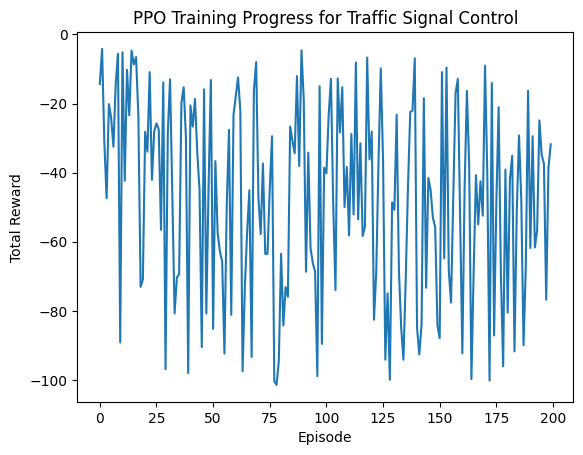

In [9]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("PPO Training Progress for Traffic Signal Control")
plt.show()


In [10]:
!pip install stable_baselines3

# Re-initialize the PPOAgent model structure
loaded_agent = PPOAgent(state_dim=len(data.columns)-1, action_dim=4)

# Load the state dictionary into the agent
loaded_agent.load_state_dict(torch.load("ppo_traffic_model.pt"))
loaded_agent.eval() # Set the model to evaluation mode

print("Model loaded successfully!")


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Model loaded successfully!


In [11]:
print("Continuing training for 500 more episodes...")
new_rewards = train_ppo(episodes=500)
rewards.extend(new_rewards)
print("Training complete.")

Continuing training for 500 more episodes...


  0%|          | 1/500 [00:00<02:10,  3.83it/s]

Episode 1 | Total Reward: -8.73


  0%|          | 2/500 [00:00<03:24,  2.43it/s]

Episode 2 | Total Reward: -16.60


  1%|          | 3/500 [00:01<04:43,  1.76it/s]

Episode 3 | Total Reward: -22.36


  1%|          | 4/500 [00:04<11:03,  1.34s/it]

Episode 4 | Total Reward: -79.88


  1%|          | 5/500 [00:05<10:34,  1.28s/it]

Episode 5 | Total Reward: -36.72


  1%|          | 6/500 [00:06<11:37,  1.41s/it]

Episode 6 | Total Reward: -51.47


  1%|▏         | 7/500 [00:09<14:18,  1.74s/it]

Episode 7 | Total Reward: -76.81


  2%|▏         | 8/500 [00:11<15:45,  1.92s/it]

Episode 8 | Total Reward: -72.60


  2%|▏         | 9/500 [00:13<15:45,  1.93s/it]

Episode 9 | Total Reward: -61.46


  2%|▏         | 10/500 [00:14<14:21,  1.76s/it]

Episode 10 | Total Reward: -43.04


  2%|▏         | 11/500 [00:17<17:12,  2.11s/it]

Episode 11 | Total Reward: -94.94


  2%|▏         | 12/500 [00:19<16:02,  1.97s/it]

Episode 12 | Total Reward: -50.87


  3%|▎         | 13/500 [00:20<13:52,  1.71s/it]

Episode 13 | Total Reward: -35.10


  3%|▎         | 14/500 [00:22<15:05,  1.86s/it]

Episode 14 | Total Reward: -70.38


  3%|▎         | 15/500 [00:24<15:20,  1.90s/it]

Episode 15 | Total Reward: -61.66


  3%|▎         | 16/500 [00:26<16:00,  1.98s/it]

Episode 16 | Total Reward: -70.13


  3%|▎         | 17/500 [00:29<16:46,  2.08s/it]

Episode 17 | Total Reward: -73.59


  4%|▎         | 18/500 [00:31<18:09,  2.26s/it]

Episode 18 | Total Reward: -84.63


  4%|▍         | 19/500 [00:33<15:34,  1.94s/it]

Episode 19 | Total Reward: -38.42


  4%|▍         | 20/500 [00:36<18:09,  2.27s/it]

Episode 20 | Total Reward: -97.39


  4%|▍         | 21/500 [00:37<15:39,  1.96s/it]

Episode 21 | Total Reward: -39.29


  5%|▍         | 23/500 [00:38<09:58,  1.26s/it]

Episode 22 | Total Reward: -35.65
Episode 23 | Total Reward: -6.83


  5%|▍         | 24/500 [00:41<12:20,  1.56s/it]

Episode 24 | Total Reward: -71.51


  5%|▌         | 25/500 [00:42<12:12,  1.54s/it]

Episode 25 | Total Reward: -46.47


  5%|▌         | 26/500 [00:44<14:02,  1.78s/it]

Episode 26 | Total Reward: -73.55


  5%|▌         | 27/500 [00:45<12:25,  1.58s/it]

Episode 27 | Total Reward: -34.37


  6%|▌         | 28/500 [00:46<10:56,  1.39s/it]

Episode 28 | Total Reward: -29.19


  6%|▌         | 29/500 [00:50<14:55,  1.90s/it]

Episode 29 | Total Reward: -100.16


  6%|▌         | 30/500 [00:51<14:20,  1.83s/it]

Episode 30 | Total Reward: -50.70


  6%|▌         | 31/500 [00:53<14:06,  1.81s/it]

Episode 31 | Total Reward: -53.04


  6%|▋         | 32/500 [00:55<14:26,  1.85s/it]

Episode 32 | Total Reward: -61.68


  7%|▋         | 33/500 [00:55<10:33,  1.36s/it]

Episode 33 | Total Reward: -7.40


  7%|▋         | 34/500 [00:56<09:24,  1.21s/it]

Episode 34 | Total Reward: -27.13


  7%|▋         | 35/500 [00:57<08:34,  1.11s/it]

Episode 35 | Total Reward: -26.61


  7%|▋         | 36/500 [00:58<08:42,  1.13s/it]

Episode 36 | Total Reward: -37.37


  7%|▋         | 37/500 [01:00<11:02,  1.43s/it]

Episode 37 | Total Reward: -67.74


  8%|▊         | 38/500 [01:03<13:16,  1.72s/it]

Episode 38 | Total Reward: -74.94


  8%|▊         | 39/500 [01:05<14:36,  1.90s/it]

Episode 39 | Total Reward: -71.58


  8%|▊         | 40/500 [01:07<15:35,  2.03s/it]

Episode 40 | Total Reward: -73.10


  8%|▊         | 41/500 [01:08<12:28,  1.63s/it]

Episode 41 | Total Reward: -21.90


  8%|▊         | 42/500 [01:08<09:58,  1.31s/it]

Episode 42 | Total Reward: -17.53


  9%|▊         | 43/500 [01:09<08:47,  1.15s/it]

Episode 43 | Total Reward: -23.34


  9%|▉         | 44/500 [01:10<08:51,  1.17s/it]

Episode 44 | Total Reward: -34.83


  9%|▉         | 45/500 [01:11<08:33,  1.13s/it]

Episode 45 | Total Reward: -29.18


  9%|▉         | 46/500 [01:15<13:08,  1.74s/it]

Episode 46 | Total Reward: -97.08


  9%|▉         | 47/500 [01:15<10:59,  1.46s/it]

Episode 47 | Total Reward: -24.83


 10%|▉         | 48/500 [01:17<12:14,  1.63s/it]

Episode 48 | Total Reward: -60.74


 10%|▉         | 49/500 [01:18<09:17,  1.24s/it]

Episode 49 | Total Reward: -9.41


 10%|█         | 50/500 [01:18<07:47,  1.04s/it]

Episode 50 | Total Reward: -13.95


 10%|█         | 51/500 [01:20<08:31,  1.14s/it]

Episode 51 | Total Reward: -34.16


 10%|█         | 52/500 [01:20<06:42,  1.11it/s]

Episode 52 | Total Reward: -10.53


 11%|█         | 53/500 [01:21<07:13,  1.03it/s]

Episode 53 | Total Reward: -35.89


 11%|█         | 54/500 [01:22<06:07,  1.21it/s]

Episode 54 | Total Reward: -15.30


 11%|█         | 55/500 [01:24<09:54,  1.34s/it]

Episode 55 | Total Reward: -78.83


 11%|█         | 56/500 [01:26<11:46,  1.59s/it]

Episode 56 | Total Reward: -70.36


 11%|█▏        | 57/500 [01:27<09:50,  1.33s/it]

Episode 57 | Total Reward: -22.59


 12%|█▏        | 58/500 [01:30<12:20,  1.68s/it]

Episode 58 | Total Reward: -78.06


 12%|█▏        | 59/500 [01:30<09:12,  1.25s/it]

Episode 59 | Total Reward: -9.24


 12%|█▏        | 60/500 [01:33<12:48,  1.75s/it]

Episode 60 | Total Reward: -92.58


 12%|█▏        | 61/500 [01:35<12:44,  1.74s/it]

Episode 61 | Total Reward: -52.24


 12%|█▏        | 62/500 [01:35<10:12,  1.40s/it]

Episode 62 | Total Reward: -18.83


 13%|█▎        | 63/500 [01:37<10:32,  1.45s/it]

Episode 63 | Total Reward: -48.91


 13%|█▎        | 64/500 [01:37<08:28,  1.17s/it]

Episode 64 | Total Reward: -16.55


 13%|█▎        | 65/500 [01:40<11:20,  1.56s/it]

Episode 65 | Total Reward: -79.42


 13%|█▎        | 66/500 [01:40<08:58,  1.24s/it]

Episode 66 | Total Reward: -15.44


 13%|█▎        | 67/500 [01:41<07:27,  1.03s/it]

Episode 67 | Total Reward: -17.51


 14%|█▎        | 68/500 [01:43<09:17,  1.29s/it]

Episode 68 | Total Reward: -58.63


 14%|█▍        | 69/500 [01:46<13:17,  1.85s/it]

Episode 69 | Total Reward: -101.69


 14%|█▍        | 70/500 [01:47<11:08,  1.56s/it]

Episode 70 | Total Reward: -27.44


 14%|█▍        | 71/500 [01:50<14:30,  2.03s/it]

Episode 71 | Total Reward: -100.98


 14%|█▍        | 72/500 [01:53<16:15,  2.28s/it]

Episode 72 | Total Reward: -91.14


 15%|█▍        | 73/500 [01:54<13:45,  1.93s/it]

Episode 73 | Total Reward: -36.05


 15%|█▍        | 74/500 [01:55<12:05,  1.70s/it]

Episode 74 | Total Reward: -36.18


 15%|█▌        | 75/500 [01:56<10:36,  1.50s/it]

Episode 75 | Total Reward: -31.60


 15%|█▌        | 76/500 [01:58<12:04,  1.71s/it]

Episode 76 | Total Reward: -70.06


 15%|█▌        | 77/500 [02:00<11:52,  1.68s/it]

Episode 77 | Total Reward: -51.00


 16%|█▌        | 78/500 [02:00<09:25,  1.34s/it]

Episode 78 | Total Reward: -17.08


 16%|█▌        | 79/500 [02:02<10:03,  1.43s/it]

Episode 79 | Total Reward: -51.39


 16%|█▌        | 80/500 [02:05<12:32,  1.79s/it]

Episode 80 | Total Reward: -83.13


 16%|█▌        | 81/500 [02:06<11:40,  1.67s/it]

Episode 81 | Total Reward: -44.04


 16%|█▋        | 82/500 [02:08<11:50,  1.70s/it]

Episode 82 | Total Reward: -53.72


 17%|█▋        | 83/500 [02:10<12:48,  1.84s/it]

Episode 83 | Total Reward: -69.37


 17%|█▋        | 84/500 [02:12<14:02,  2.03s/it]

Episode 84 | Total Reward: -77.89


 17%|█▋        | 85/500 [02:13<12:00,  1.74s/it]

Episode 85 | Total Reward: -31.60


 17%|█▋        | 86/500 [02:16<13:36,  1.97s/it]

Episode 86 | Total Reward: -80.55


 17%|█▋        | 87/500 [02:19<15:20,  2.23s/it]

Episode 87 | Total Reward: -89.90


 18%|█▊        | 88/500 [02:22<16:34,  2.41s/it]

Episode 88 | Total Reward: -90.77


 18%|█▊        | 89/500 [02:23<13:27,  1.96s/it]

Episode 89 | Total Reward: -28.83


 18%|█▊        | 90/500 [02:24<11:48,  1.73s/it]

Episode 90 | Total Reward: -35.82


 18%|█▊        | 91/500 [02:27<14:23,  2.11s/it]

Episode 91 | Total Reward: -97.24


 18%|█▊        | 92/500 [02:29<14:47,  2.17s/it]

Episode 92 | Total Reward: -72.65


 19%|█▊        | 93/500 [02:29<11:06,  1.64s/it]

Episode 93 | Total Reward: -12.45


 19%|█▉        | 94/500 [02:30<08:18,  1.23s/it]

Episode 94 | Total Reward: -9.24


 19%|█▉        | 95/500 [02:33<11:39,  1.73s/it]

Episode 95 | Total Reward: -94.06


 19%|█▉        | 97/500 [02:34<08:20,  1.24s/it]

Episode 96 | Total Reward: -51.47
Episode 97 | Total Reward: -4.86


 20%|█▉        | 98/500 [02:37<11:12,  1.67s/it]

Episode 98 | Total Reward: -85.86


 20%|█▉        | 99/500 [02:39<12:27,  1.86s/it]

Episode 99 | Total Reward: -74.65


 20%|██        | 100/500 [02:40<10:40,  1.60s/it]

Episode 100 | Total Reward: -30.52


 20%|██        | 101/500 [02:41<08:05,  1.22s/it]

Episode 101 | Total Reward: -10.92


 20%|██        | 102/500 [02:42<07:20,  1.11s/it]

Episode 102 | Total Reward: -26.86


 21%|██        | 103/500 [02:44<09:47,  1.48s/it]

Episode 103 | Total Reward: -74.94


 21%|██        | 104/500 [02:44<07:36,  1.15s/it]

Episode 104 | Total Reward: -12.79


 21%|██        | 105/500 [02:46<08:39,  1.31s/it]

Episode 105 | Total Reward: -51.76


 21%|██        | 106/500 [02:48<10:06,  1.54s/it]

Episode 106 | Total Reward: -65.75


 21%|██▏       | 107/500 [02:51<12:45,  1.95s/it]

Episode 107 | Total Reward: -92.27


 22%|██▏       | 108/500 [02:54<15:12,  2.33s/it]

Episode 108 | Total Reward: -101.66


 22%|██▏       | 109/500 [02:56<14:35,  2.24s/it]

Episode 109 | Total Reward: -62.28


 22%|██▏       | 110/500 [02:58<13:08,  2.02s/it]

Episode 110 | Total Reward: -46.76


 22%|██▏       | 111/500 [02:58<10:23,  1.60s/it]

Episode 111 | Total Reward: -19.48


 22%|██▏       | 112/500 [03:00<11:02,  1.71s/it]

Episode 112 | Total Reward: -61.68


 23%|██▎       | 113/500 [03:01<09:37,  1.49s/it]

Episode 113 | Total Reward: -30.86


 23%|██▎       | 114/500 [03:02<08:01,  1.25s/it]

Episode 114 | Total Reward: -20.71


 23%|██▎       | 115/500 [03:03<08:30,  1.33s/it]

Episode 115 | Total Reward: -46.95


 23%|██▎       | 116/500 [03:04<07:08,  1.12s/it]

Episode 116 | Total Reward: -18.69


 23%|██▎       | 117/500 [03:05<06:39,  1.04s/it]

Episode 117 | Total Reward: -27.82


 24%|██▎       | 118/500 [03:07<08:48,  1.38s/it]

Episode 118 | Total Reward: -68.95


 24%|██▍       | 119/500 [03:09<10:07,  1.59s/it]

Episode 119 | Total Reward: -67.07


 24%|██▍       | 120/500 [03:11<11:11,  1.77s/it]

Episode 120 | Total Reward: -69.75


 24%|██▍       | 121/500 [03:14<12:11,  1.93s/it]

Episode 121 | Total Reward: -73.16


 24%|██▍       | 122/500 [03:15<11:32,  1.83s/it]

Episode 122 | Total Reward: -48.21


 25%|██▍       | 123/500 [03:18<13:02,  2.08s/it]

Episode 123 | Total Reward: -84.40


 25%|██▍       | 124/500 [03:20<13:30,  2.16s/it]

Episode 124 | Total Reward: -74.16


 25%|██▌       | 125/500 [03:23<14:47,  2.37s/it]

Episode 125 | Total Reward: -92.39


 25%|██▌       | 126/500 [03:26<14:55,  2.39s/it]

Episode 126 | Total Reward: -77.84


 25%|██▌       | 127/500 [03:29<16:15,  2.61s/it]

Episode 127 | Total Reward: -101.25


 26%|██▌       | 128/500 [03:31<14:42,  2.37s/it]

Episode 128 | Total Reward: -57.01


 26%|██▌       | 129/500 [03:31<11:45,  1.90s/it]

Episode 129 | Total Reward: -25.83


 26%|██▌       | 130/500 [03:32<09:07,  1.48s/it]

Episode 130 | Total Reward: -15.89


 26%|██▌       | 131/500 [03:34<11:10,  1.82s/it]

Episode 131 | Total Reward: -81.25


 26%|██▋       | 132/500 [03:37<13:10,  2.15s/it]

Episode 132 | Total Reward: -93.06


 27%|██▋       | 133/500 [03:38<10:20,  1.69s/it]

Episode 133 | Total Reward: -19.71


 27%|██▋       | 134/500 [03:41<12:32,  2.05s/it]

Episode 134 | Total Reward: -93.39


 27%|██▋       | 135/500 [03:43<13:08,  2.16s/it]

Episode 135 | Total Reward: -76.89


 27%|██▋       | 136/500 [03:45<12:14,  2.02s/it]

Episode 136 | Total Reward: -51.33


 27%|██▋       | 137/500 [03:47<11:49,  1.96s/it]

Episode 137 | Total Reward: -56.77


 28%|██▊       | 138/500 [03:50<13:36,  2.26s/it]

Episode 138 | Total Reward: -95.10


 28%|██▊       | 139/500 [03:51<10:56,  1.82s/it]

Episode 139 | Total Reward: -25.10


 28%|██▊       | 140/500 [03:52<10:27,  1.74s/it]

Episode 140 | Total Reward: -48.12


 28%|██▊       | 141/500 [03:53<08:33,  1.43s/it]

Episode 141 | Total Reward: -21.63


 28%|██▊       | 142/500 [03:54<07:14,  1.21s/it]

Episode 142 | Total Reward: -22.28


 29%|██▊       | 143/500 [03:56<09:17,  1.56s/it]

Episode 143 | Total Reward: -74.16


 29%|██▉       | 144/500 [03:58<10:34,  1.78s/it]

Episode 144 | Total Reward: -72.35


 29%|██▉       | 145/500 [04:01<12:12,  2.06s/it]

Episode 145 | Total Reward: -87.29


 29%|██▉       | 146/500 [04:03<11:38,  1.97s/it]

Episode 146 | Total Reward: -54.13


 29%|██▉       | 147/500 [04:03<09:04,  1.54s/it]

Episode 147 | Total Reward: -17.04


 30%|██▉       | 148/500 [04:06<11:02,  1.88s/it]

Episode 148 | Total Reward: -84.56


 30%|██▉       | 149/500 [04:08<10:44,  1.84s/it]

Episode 149 | Total Reward: -52.95


 30%|███       | 150/500 [04:09<10:38,  1.82s/it]

Episode 150 | Total Reward: -56.56


 30%|███       | 151/500 [04:12<12:41,  2.18s/it]

Episode 151 | Total Reward: -97.85


 30%|███       | 152/500 [04:14<11:05,  1.91s/it]

Episode 152 | Total Reward: -40.58


 31%|███       | 153/500 [04:14<08:57,  1.55s/it]

Episode 153 | Total Reward: -22.28


 31%|███       | 154/500 [04:15<07:24,  1.29s/it]

Episode 154 | Total Reward: -20.42


 31%|███       | 155/500 [04:17<09:09,  1.59s/it]

Episode 155 | Total Reward: -73.67


 31%|███       | 156/500 [04:19<08:36,  1.50s/it]

Episode 156 | Total Reward: -40.21


 31%|███▏      | 157/500 [04:20<08:29,  1.48s/it]

Episode 157 | Total Reward: -45.94


 32%|███▏      | 158/500 [04:22<08:18,  1.46s/it]

Episode 158 | Total Reward: -44.45


 32%|███▏      | 159/500 [04:24<10:47,  1.90s/it]

Episode 159 | Total Reward: -94.44


 32%|███▏      | 160/500 [04:26<09:28,  1.67s/it]

Episode 160 | Total Reward: -35.48


 32%|███▏      | 161/500 [04:27<08:07,  1.44s/it]

Episode 161 | Total Reward: -27.56


 32%|███▏      | 162/500 [04:29<10:37,  1.89s/it]

Episode 162 | Total Reward: -95.52


 33%|███▎      | 163/500 [04:32<11:17,  2.01s/it]

Episode 163 | Total Reward: -73.67


 33%|███▎      | 164/500 [04:35<12:44,  2.27s/it]

Episode 164 | Total Reward: -94.34


 33%|███▎      | 165/500 [04:37<12:25,  2.23s/it]

Episode 165 | Total Reward: -67.13


 33%|███▎      | 166/500 [04:38<11:02,  1.98s/it]

Episode 166 | Total Reward: -45.40


 33%|███▎      | 167/500 [04:39<09:03,  1.63s/it]

Episode 167 | Total Reward: -26.42


 34%|███▎      | 168/500 [04:40<07:25,  1.34s/it]

Episode 168 | Total Reward: -20.79


 34%|███▍      | 169/500 [04:42<09:46,  1.77s/it]

Episode 169 | Total Reward: -90.68


 34%|███▍      | 170/500 [04:44<10:06,  1.84s/it]

Episode 170 | Total Reward: -64.40


 34%|███▍      | 171/500 [04:47<10:53,  1.99s/it]

Episode 171 | Total Reward: -73.86


 35%|███▍      | 173/500 [04:49<07:52,  1.44s/it]

Episode 172 | Total Reward: -63.65
Episode 173 | Total Reward: -7.22


 35%|███▍      | 174/500 [04:51<09:15,  1.70s/it]

Episode 174 | Total Reward: -74.65


 35%|███▌      | 175/500 [04:53<08:41,  1.61s/it]

Episode 175 | Total Reward: -43.22


 35%|███▌      | 176/500 [04:55<10:25,  1.93s/it]

Episode 176 | Total Reward: -88.23


 35%|███▌      | 177/500 [04:57<09:43,  1.81s/it]

Episode 177 | Total Reward: -46.86


 36%|███▌      | 178/500 [04:59<10:59,  2.05s/it]

Episode 178 | Total Reward: -85.41


 36%|███▌      | 179/500 [05:00<09:10,  1.72s/it]

Episode 179 | Total Reward: -30.44


 36%|███▌      | 180/500 [05:02<09:36,  1.80s/it]

Episode 180 | Total Reward: -63.47


 36%|███▌      | 181/500 [05:03<07:19,  1.38s/it]

Episode 181 | Total Reward: -12.74


 36%|███▋      | 182/500 [05:06<09:56,  1.88s/it]

Episode 182 | Total Reward: -98.84


 37%|███▋      | 183/500 [05:08<11:04,  2.10s/it]

Episode 183 | Total Reward: -83.13


 37%|███▋      | 184/500 [05:11<12:30,  2.38s/it]

Episode 184 | Total Reward: -98.88


 37%|███▋      | 185/500 [05:13<11:27,  2.18s/it]

Episode 185 | Total Reward: -53.04


 37%|███▋      | 186/500 [05:16<12:47,  2.44s/it]

Episode 186 | Total Reward: -99.25


 37%|███▋      | 187/500 [05:18<11:00,  2.11s/it]

Episode 187 | Total Reward: -42.09


 38%|███▊      | 188/500 [05:19<10:21,  1.99s/it]

Episode 188 | Total Reward: -53.50


 38%|███▊      | 189/500 [05:22<11:46,  2.27s/it]

Episode 189 | Total Reward: -95.69


 38%|███▊      | 191/500 [05:24<07:25,  1.44s/it]

Episode 190 | Total Reward: -43.03
Episode 191 | Total Reward: -5.17


 38%|███▊      | 192/500 [05:24<06:20,  1.23s/it]

Episode 192 | Total Reward: -24.66


 39%|███▊      | 193/500 [05:25<05:58,  1.17s/it]

Episode 193 | Total Reward: -32.20


 39%|███▉      | 194/500 [05:28<08:10,  1.60s/it]

Episode 194 | Total Reward: -84.63


 39%|███▉      | 195/500 [05:29<07:02,  1.38s/it]

Episode 195 | Total Reward: -27.56


 39%|███▉      | 196/500 [05:32<09:23,  1.85s/it]

Episode 196 | Total Reward: -96.17


 39%|███▉      | 197/500 [05:34<09:49,  1.94s/it]

Episode 197 | Total Reward: -69.57


 40%|███▉      | 198/500 [05:36<09:55,  1.97s/it]

Episode 198 | Total Reward: -66.27


 40%|███▉      | 199/500 [05:38<09:22,  1.87s/it]

Episode 199 | Total Reward: -50.48


 40%|████      | 200/500 [05:39<08:58,  1.79s/it]

Episode 200 | Total Reward: -51.51


 40%|████      | 201/500 [05:42<10:17,  2.07s/it]

Episode 201 | Total Reward: -87.19


 40%|████      | 202/500 [05:43<08:35,  1.73s/it]

Episode 202 | Total Reward: -30.47


 41%|████      | 203/500 [05:45<08:50,  1.79s/it]

Episode 203 | Total Reward: -61.97


 41%|████      | 204/500 [05:46<07:08,  1.45s/it]

Episode 204 | Total Reward: -19.92


 41%|████      | 205/500 [05:46<06:01,  1.22s/it]

Episode 205 | Total Reward: -22.59


 41%|████      | 206/500 [05:49<08:32,  1.74s/it]

Episode 206 | Total Reward: -96.61


 41%|████▏     | 207/500 [05:51<08:13,  1.68s/it]

Episode 207 | Total Reward: -48.91


 42%|████▏     | 208/500 [05:53<09:41,  1.99s/it]

Episode 208 | Total Reward: -88.58


 42%|████▏     | 209/500 [05:56<10:29,  2.16s/it]

Episode 209 | Total Reward: -84.40


 42%|████▏     | 210/500 [05:58<10:37,  2.20s/it]

Episode 210 | Total Reward: -72.65


 42%|████▏     | 211/500 [06:01<11:29,  2.39s/it]

Episode 211 | Total Reward: -93.99


 42%|████▏     | 212/500 [06:04<11:36,  2.42s/it]

Episode 212 | Total Reward: -80.19


 43%|████▎     | 213/500 [06:05<09:54,  2.07s/it]

Episode 213 | Total Reward: -40.43


 43%|████▎     | 214/500 [06:07<09:19,  1.96s/it]

Episode 214 | Total Reward: -53.98


 43%|████▎     | 215/500 [06:08<08:38,  1.82s/it]

Episode 215 | Total Reward: -46.26


 43%|████▎     | 216/500 [06:11<09:46,  2.06s/it]

Episode 216 | Total Reward: -87.05


 43%|████▎     | 217/500 [06:13<10:27,  2.22s/it]

Episode 217 | Total Reward: -83.36


 44%|████▎     | 218/500 [06:16<10:47,  2.29s/it]

Episode 218 | Total Reward: -81.65


 44%|████▍     | 219/500 [06:18<10:21,  2.21s/it]

Episode 219 | Total Reward: -64.62


 44%|████▍     | 220/500 [06:18<07:47,  1.67s/it]

Episode 220 | Total Reward: -13.15


 44%|████▍     | 221/500 [06:18<05:48,  1.25s/it]

Episode 221 | Total Reward: -9.20


 44%|████▍     | 222/500 [06:21<07:22,  1.59s/it]

Episode 222 | Total Reward: -77.92


 45%|████▍     | 223/500 [06:23<07:38,  1.66s/it]

Episode 223 | Total Reward: -57.40


 45%|████▌     | 225/500 [06:23<04:33,  1.01it/s]

Episode 224 | Total Reward: -19.71
Episode 225 | Total Reward: -5.74


 45%|████▌     | 226/500 [06:24<04:37,  1.01s/it]

Episode 226 | Total Reward: -34.00


 45%|████▌     | 227/500 [06:28<07:20,  1.62s/it]

Episode 227 | Total Reward: -98.39


 46%|████▌     | 228/500 [06:29<07:41,  1.70s/it]

Episode 228 | Total Reward: -59.47


 46%|████▌     | 229/500 [06:31<07:11,  1.59s/it]

Episode 229 | Total Reward: -43.63


 46%|████▌     | 230/500 [06:31<05:48,  1.29s/it]

Episode 230 | Total Reward: -18.68


 46%|████▌     | 231/500 [06:34<07:18,  1.63s/it]

Episode 231 | Total Reward: -77.92


 46%|████▋     | 232/500 [06:36<08:44,  1.96s/it]

Episode 232 | Total Reward: -89.00


 47%|████▋     | 233/500 [06:38<07:46,  1.75s/it]

Episode 233 | Total Reward: -38.92


 47%|████▋     | 234/500 [06:41<09:27,  2.13s/it]

Episode 234 | Total Reward: -99.25


 47%|████▋     | 235/500 [06:43<08:56,  2.02s/it]

Episode 235 | Total Reward: -56.32


 47%|████▋     | 236/500 [06:44<07:56,  1.81s/it]

Episode 236 | Total Reward: -40.95


 47%|████▋     | 237/500 [06:44<06:24,  1.46s/it]

Episode 237 | Total Reward: -21.34


 48%|████▊     | 238/500 [06:47<07:31,  1.72s/it]

Episode 238 | Total Reward: -75.83


 48%|████▊     | 239/500 [06:49<08:19,  1.91s/it]

Episode 239 | Total Reward: -76.44


 48%|████▊     | 240/500 [06:50<07:30,  1.73s/it]

Episode 240 | Total Reward: -41.96


 48%|████▊     | 241/500 [06:53<08:47,  2.04s/it]

Episode 241 | Total Reward: -90.56


 48%|████▊     | 242/500 [06:54<07:01,  1.63s/it]

Episode 242 | Total Reward: -21.34


 49%|████▊     | 243/500 [06:56<07:57,  1.86s/it]

Episode 243 | Total Reward: -76.40


 49%|████▉     | 244/500 [06:59<09:04,  2.13s/it]

Episode 244 | Total Reward: -88.11


 49%|████▉     | 245/500 [07:02<09:29,  2.23s/it]

Episode 245 | Total Reward: -80.76


 49%|████▉     | 246/500 [07:02<07:35,  1.79s/it]

Episode 246 | Total Reward: -25.22


 49%|████▉     | 247/500 [07:05<08:19,  1.97s/it]

Episode 247 | Total Reward: -77.72


 50%|████▉     | 248/500 [07:08<09:37,  2.29s/it]

Episode 248 | Total Reward: -98.77


 50%|████▉     | 249/500 [07:09<07:40,  1.83s/it]

Episode 249 | Total Reward: -24.39


 50%|█████     | 250/500 [07:10<07:47,  1.87s/it]

Episode 250 | Total Reward: -63.92


 50%|█████     | 251/500 [07:11<06:20,  1.53s/it]

Episode 251 | Total Reward: -23.34


 50%|█████     | 252/500 [07:13<06:48,  1.65s/it]

Episode 252 | Total Reward: -61.89


 51%|█████     | 253/500 [07:15<07:17,  1.77s/it]

Episode 253 | Total Reward: -66.50


 51%|█████     | 254/500 [07:18<08:36,  2.10s/it]

Episode 254 | Total Reward: -92.57


 51%|█████     | 255/500 [07:20<08:25,  2.06s/it]

Episode 255 | Total Reward: -63.65


 51%|█████     | 256/500 [07:22<07:56,  1.95s/it]

Episode 256 | Total Reward: -54.30


 51%|█████▏    | 257/500 [07:25<09:05,  2.24s/it]

Episode 257 | Total Reward: -94.94


 52%|█████▏    | 258/500 [07:27<09:37,  2.39s/it]

Episode 258 | Total Reward: -90.95


 52%|█████▏    | 259/500 [07:30<10:00,  2.49s/it]

Episode 259 | Total Reward: -88.58


 52%|█████▏    | 260/500 [07:31<07:59,  2.00s/it]

Episode 260 | Total Reward: -27.64


 52%|█████▏    | 261/500 [07:34<09:04,  2.28s/it]

Episode 261 | Total Reward: -96.61


 52%|█████▏    | 262/500 [07:36<09:23,  2.37s/it]

Episode 262 | Total Reward: -84.63


 53%|█████▎    | 263/500 [07:37<07:09,  1.81s/it]

Episode 263 | Total Reward: -17.19


 53%|█████▎    | 264/500 [07:38<05:42,  1.45s/it]

Episode 264 | Total Reward: -19.79


 53%|█████▎    | 265/500 [07:41<07:27,  1.90s/it]

Episode 265 | Total Reward: -94.39


 53%|█████▎    | 266/500 [07:41<05:54,  1.52s/it]

Episode 266 | Total Reward: -19.46


 53%|█████▎    | 267/500 [07:43<06:35,  1.70s/it]

Episode 267 | Total Reward: -68.66


 54%|█████▎    | 268/500 [07:45<07:02,  1.82s/it]

Episode 268 | Total Reward: -67.18


 54%|█████▍    | 269/500 [07:48<07:24,  1.93s/it]

Episode 269 | Total Reward: -70.78


 54%|█████▍    | 270/500 [07:49<07:22,  1.93s/it]

Episode 270 | Total Reward: -60.54


 54%|█████▍    | 271/500 [07:51<07:06,  1.86s/it]

Episode 271 | Total Reward: -54.13


 54%|█████▍    | 272/500 [07:52<05:32,  1.46s/it]

Episode 272 | Total Reward: -17.05


 55%|█████▍    | 273/500 [07:55<07:14,  1.91s/it]

Episode 273 | Total Reward: -97.10


 55%|█████▍    | 274/500 [07:56<06:11,  1.65s/it]

Episode 274 | Total Reward: -32.38


 55%|█████▌    | 275/500 [07:56<05:04,  1.35s/it]

Episode 275 | Total Reward: -20.69


 55%|█████▌    | 276/500 [07:59<06:35,  1.76s/it]

Episode 276 | Total Reward: -88.64


 55%|█████▌    | 277/500 [08:00<05:30,  1.48s/it]

Episode 277 | Total Reward: -26.95


 56%|█████▌    | 278/500 [08:01<04:57,  1.34s/it]

Episode 278 | Total Reward: -32.52


 56%|█████▌    | 279/500 [08:02<04:06,  1.12s/it]

Episode 279 | Total Reward: -18.68


 56%|█████▌    | 280/500 [08:04<05:23,  1.47s/it]

Episode 280 | Total Reward: -73.55


 56%|█████▋    | 282/500 [08:06<04:19,  1.19s/it]

Episode 281 | Total Reward: -65.75
Episode 282 | Total Reward: -5.29


 57%|█████▋    | 283/500 [08:08<05:03,  1.40s/it]

Episode 283 | Total Reward: -59.23


 57%|█████▋    | 284/500 [08:10<06:04,  1.69s/it]

Episode 284 | Total Reward: -75.81


 57%|█████▋    | 285/500 [08:11<05:21,  1.49s/it]

Episode 285 | Total Reward: -32.73


 57%|█████▋    | 286/500 [08:13<05:16,  1.48s/it]

Episode 286 | Total Reward: -45.38


 57%|█████▋    | 287/500 [08:13<03:58,  1.12s/it]

Episode 287 | Total Reward: -9.92


 58%|█████▊    | 288/500 [08:15<04:35,  1.30s/it]

Episode 288 | Total Reward: -53.09


 58%|█████▊    | 289/500 [08:17<05:54,  1.68s/it]

Episode 289 | Total Reward: -84.63


 58%|█████▊    | 290/500 [08:19<06:02,  1.73s/it]

Episode 290 | Total Reward: -55.63


 58%|█████▊    | 291/500 [08:21<06:30,  1.87s/it]

Episode 291 | Total Reward: -71.58


 58%|█████▊    | 292/500 [08:24<07:24,  2.14s/it]

Episode 292 | Total Reward: -90.09


 59%|█████▊    | 293/500 [08:27<08:03,  2.33s/it]

Episode 293 | Total Reward: -91.71


 59%|█████▉    | 294/500 [08:30<08:21,  2.44s/it]

Episode 294 | Total Reward: -85.31


 59%|█████▉    | 295/500 [08:31<07:46,  2.28s/it]

Episode 295 | Total Reward: -61.80


 59%|█████▉    | 296/500 [08:33<06:34,  1.93s/it]

Episode 296 | Total Reward: -36.30


 59%|█████▉    | 297/500 [08:35<07:18,  2.16s/it]

Episode 297 | Total Reward: -87.25


 60%|█████▉    | 298/500 [08:36<06:15,  1.86s/it]

Episode 298 | Total Reward: -37.20


 60%|█████▉    | 299/500 [08:38<06:21,  1.90s/it]

Episode 299 | Total Reward: -64.86


 60%|██████    | 300/500 [08:41<07:15,  2.18s/it]

Episode 300 | Total Reward: -90.77


 60%|██████    | 302/500 [08:43<05:03,  1.53s/it]

Episode 301 | Total Reward: -62.56
Episode 302 | Total Reward: -7.22


 61%|██████    | 303/500 [08:46<05:50,  1.78s/it]

Episode 303 | Total Reward: -76.44


 61%|██████    | 304/500 [08:49<06:51,  2.10s/it]

Episode 304 | Total Reward: -94.34


 61%|██████    | 305/500 [08:50<06:30,  2.00s/it]

Episode 305 | Total Reward: -55.00


 61%|██████    | 306/500 [08:53<07:07,  2.20s/it]

Episode 306 | Total Reward: -87.25


 61%|██████▏   | 307/500 [08:54<06:15,  1.95s/it]

Episode 307 | Total Reward: -42.31


 62%|██████▏   | 308/500 [08:56<06:14,  1.95s/it]

Episode 308 | Total Reward: -63.50


 62%|██████▏   | 309/500 [08:59<07:06,  2.24s/it]

Episode 309 | Total Reward: -95.98


 62%|██████▏   | 310/500 [09:02<07:38,  2.41s/it]

Episode 310 | Total Reward: -92.58


 62%|██████▏   | 311/500 [09:02<05:31,  1.76s/it]

Episode 311 | Total Reward: -8.05


 62%|██████▏   | 312/500 [09:05<05:55,  1.89s/it]

Episode 312 | Total Reward: -70.57


 63%|██████▎   | 313/500 [09:06<05:30,  1.77s/it]

Episode 313 | Total Reward: -47.01


 63%|██████▎   | 314/500 [09:08<05:57,  1.92s/it]

Episode 314 | Total Reward: -73.86


 63%|██████▎   | 315/500 [09:10<06:10,  2.00s/it]

Episode 315 | Total Reward: -69.86


 63%|██████▎   | 316/500 [09:11<05:07,  1.67s/it]

Episode 316 | Total Reward: -28.37


 63%|██████▎   | 317/500 [09:14<05:54,  1.94s/it]

Episode 317 | Total Reward: -83.36


 64%|██████▎   | 318/500 [09:15<05:25,  1.79s/it]

Episode 318 | Total Reward: -45.68


 64%|██████▍   | 319/500 [09:18<06:23,  2.12s/it]

Episode 319 | Total Reward: -94.06


 64%|██████▍   | 320/500 [09:19<04:59,  1.66s/it]

Episode 320 | Total Reward: -19.13


 64%|██████▍   | 321/500 [09:22<06:06,  2.05s/it]

Episode 321 | Total Reward: -97.24


 64%|██████▍   | 322/500 [09:25<06:45,  2.28s/it]

Episode 322 | Total Reward: -92.39


 65%|██████▍   | 323/500 [09:27<06:24,  2.17s/it]

Episode 323 | Total Reward: -62.77


 65%|██████▍   | 324/500 [09:27<05:12,  1.77s/it]

Episode 324 | Total Reward: -27.39


 65%|██████▌   | 325/500 [09:29<05:01,  1.72s/it]

Episode 325 | Total Reward: -51.29


 65%|██████▌   | 326/500 [09:32<06:09,  2.12s/it]

Episode 326 | Total Reward: -98.97


 65%|██████▌   | 327/500 [09:35<06:28,  2.25s/it]

Episode 327 | Total Reward: -81.13


 66%|██████▌   | 328/500 [09:37<06:46,  2.36s/it]

Episode 328 | Total Reward: -87.13


 66%|██████▌   | 329/500 [09:39<05:58,  2.10s/it]

Episode 329 | Total Reward: -47.58


 66%|██████▌   | 330/500 [09:40<05:41,  2.01s/it]

Episode 330 | Total Reward: -55.48


 66%|██████▌   | 331/500 [09:43<06:16,  2.23s/it]

Episode 331 | Total Reward: -90.98


 66%|██████▋   | 332/500 [09:46<06:51,  2.45s/it]

Episode 332 | Total Reward: -97.10


 67%|██████▋   | 333/500 [09:48<06:12,  2.23s/it]

Episode 333 | Total Reward: -55.06


 67%|██████▋   | 334/500 [09:49<05:32,  2.00s/it]

Episode 334 | Total Reward: -47.74


 67%|██████▋   | 335/500 [09:50<04:18,  1.57s/it]

Episode 335 | Total Reward: -17.29


 67%|██████▋   | 336/500 [09:52<04:34,  1.67s/it]

Episode 336 | Total Reward: -61.31


 67%|██████▋   | 337/500 [09:53<04:14,  1.56s/it]

Episode 337 | Total Reward: -42.63


 68%|██████▊   | 338/500 [09:54<03:49,  1.41s/it]

Episode 338 | Total Reward: -34.32


 68%|██████▊   | 339/500 [09:56<03:49,  1.42s/it]

Episode 339 | Total Reward: -46.35


 68%|██████▊   | 340/500 [09:57<04:06,  1.54s/it]

Episode 340 | Total Reward: -57.76


 68%|██████▊   | 341/500 [09:58<03:26,  1.30s/it]

Episode 341 | Total Reward: -23.93


 68%|██████▊   | 342/500 [09:59<02:45,  1.04s/it]

Episode 342 | Total Reward: -15.22


 69%|██████▊   | 343/500 [10:00<03:09,  1.21s/it]

Episode 343 | Total Reward: -50.24


 69%|██████▉   | 344/500 [10:03<04:37,  1.78s/it]

Episode 344 | Total Reward: -101.42


 69%|██████▉   | 345/500 [10:05<04:35,  1.78s/it]

Episode 345 | Total Reward: -55.66


 69%|██████▉   | 346/500 [10:07<04:54,  1.91s/it]

Episode 346 | Total Reward: -72.46


 69%|██████▉   | 347/500 [10:08<03:54,  1.53s/it]

Episode 347 | Total Reward: -20.50


 70%|██████▉   | 348/500 [10:10<04:01,  1.59s/it]

Episode 348 | Total Reward: -55.24


 70%|██████▉   | 349/500 [10:11<03:49,  1.52s/it]

Episode 349 | Total Reward: -42.50


 70%|███████   | 350/500 [10:14<04:47,  1.92s/it]

Episode 350 | Total Reward: -93.75


 70%|███████   | 351/500 [10:15<03:54,  1.58s/it]

Episode 351 | Total Reward: -24.73


 70%|███████   | 352/500 [10:17<04:23,  1.78s/it]

Episode 352 | Total Reward: -73.05


 71%|███████   | 353/500 [10:19<04:53,  1.99s/it]

Episode 353 | Total Reward: -80.84


 71%|███████   | 354/500 [10:20<03:37,  1.49s/it]

Episode 354 | Total Reward: -10.25


 71%|███████   | 355/500 [10:21<03:18,  1.37s/it]

Episode 355 | Total Reward: -32.73


 71%|███████   | 356/500 [10:24<04:12,  1.75s/it]

Episode 356 | Total Reward: -85.69


 71%|███████▏  | 357/500 [10:25<03:46,  1.58s/it]

Episode 357 | Total Reward: -38.31


 72%|███████▏  | 358/500 [10:27<04:14,  1.79s/it]

Episode 358 | Total Reward: -73.29


 72%|███████▏  | 359/500 [10:30<04:45,  2.03s/it]

Episode 359 | Total Reward: -84.20


 72%|███████▏  | 360/500 [10:30<03:44,  1.60s/it]

Episode 360 | Total Reward: -19.23


 72%|███████▏  | 361/500 [10:33<04:19,  1.87s/it]

Episode 361 | Total Reward: -80.76


 72%|███████▏  | 362/500 [10:33<03:31,  1.53s/it]

Episode 362 | Total Reward: -24.60


 73%|███████▎  | 363/500 [10:34<02:35,  1.14s/it]

Episode 363 | Total Reward: -8.01


 73%|███████▎  | 364/500 [10:36<03:08,  1.39s/it]

Episode 364 | Total Reward: -61.80


 73%|███████▎  | 365/500 [10:39<04:13,  1.88s/it]

Episode 365 | Total Reward: -99.76


 73%|███████▎  | 366/500 [10:40<03:50,  1.72s/it]

Episode 366 | Total Reward: -42.52


 73%|███████▎  | 367/500 [10:41<03:11,  1.44s/it]

Episode 367 | Total Reward: -25.72


 74%|███████▍  | 369/500 [10:44<03:02,  1.39s/it]

Episode 368 | Total Reward: -97.47
Episode 369 | Total Reward: -7.22


 74%|███████▍  | 370/500 [10:46<03:34,  1.65s/it]

Episode 370 | Total Reward: -73.04


 74%|███████▍  | 372/500 [10:48<02:27,  1.15s/it]

Episode 371 | Total Reward: -46.86
Episode 372 | Total Reward: -4.18


 75%|███████▍  | 373/500 [10:49<02:30,  1.18s/it]

Episode 373 | Total Reward: -40.74


 75%|███████▍  | 374/500 [10:51<02:41,  1.28s/it]

Episode 374 | Total Reward: -47.81


 75%|███████▌  | 375/500 [10:53<03:26,  1.65s/it]

Episode 375 | Total Reward: -82.10


 75%|███████▌  | 376/500 [10:56<04:04,  1.97s/it]

Episode 376 | Total Reward: -89.00


 75%|███████▌  | 377/500 [10:59<04:34,  2.23s/it]

Episode 377 | Total Reward: -92.13


 76%|███████▌  | 378/500 [11:01<04:30,  2.22s/it]

Episode 378 | Total Reward: -70.58


 76%|███████▌  | 379/500 [11:04<04:54,  2.44s/it]

Episode 379 | Total Reward: -95.52


 76%|███████▌  | 380/500 [11:07<05:14,  2.62s/it]

Episode 380 | Total Reward: -98.97


 76%|███████▌  | 381/500 [11:07<03:52,  1.95s/it]

Episode 381 | Total Reward: -12.74


 76%|███████▋  | 382/500 [11:08<02:56,  1.50s/it]

Episode 382 | Total Reward: -14.23


 77%|███████▋  | 383/500 [11:09<03:07,  1.60s/it]

Episode 383 | Total Reward: -59.91


 77%|███████▋  | 384/500 [11:10<02:25,  1.25s/it]

Episode 384 | Total Reward: -14.36


 77%|███████▋  | 385/500 [11:11<02:24,  1.25s/it]

Episode 385 | Total Reward: -39.83


 77%|███████▋  | 386/500 [11:14<03:05,  1.63s/it]

Episode 386 | Total Reward: -81.21


 77%|███████▋  | 387/500 [11:16<03:13,  1.72s/it]

Episode 387 | Total Reward: -61.39


 78%|███████▊  | 388/500 [11:18<03:27,  1.85s/it]

Episode 388 | Total Reward: -69.86


 78%|███████▊  | 389/500 [11:19<03:13,  1.75s/it]

Episode 389 | Total Reward: -47.37


 78%|███████▊  | 390/500 [11:20<02:41,  1.47s/it]

Episode 390 | Total Reward: -26.29


 78%|███████▊  | 391/500 [11:22<02:50,  1.56s/it]

Episode 391 | Total Reward: -56.10


 78%|███████▊  | 392/500 [11:24<03:08,  1.75s/it]

Episode 392 | Total Reward: -70.23


 79%|███████▊  | 393/500 [11:26<03:20,  1.88s/it]

Episode 393 | Total Reward: -70.85


 79%|███████▉  | 394/500 [11:28<03:15,  1.85s/it]

Episode 394 | Total Reward: -57.45


 79%|███████▉  | 395/500 [11:30<03:07,  1.79s/it]

Episode 395 | Total Reward: -51.39


 79%|███████▉  | 396/500 [11:32<03:11,  1.84s/it]

Episode 396 | Total Reward: -62.08


 79%|███████▉  | 397/500 [11:33<02:59,  1.74s/it]

Episode 397 | Total Reward: -48.69


 80%|███████▉  | 398/500 [11:36<03:21,  1.97s/it]

Episode 398 | Total Reward: -81.25


 80%|███████▉  | 399/500 [11:38<03:35,  2.13s/it]

Episode 399 | Total Reward: -82.55


 80%|████████  | 400/500 [11:39<02:58,  1.79s/it]

Episode 400 | Total Reward: -32.00


 80%|████████  | 401/500 [11:40<02:43,  1.65s/it]

Episode 401 | Total Reward: -41.76


 80%|████████  | 402/500 [11:42<02:51,  1.75s/it]

Episode 402 | Total Reward: -62.28


 81%|████████  | 403/500 [11:45<03:13,  1.99s/it]

Episode 403 | Total Reward: -84.34


 81%|████████  | 404/500 [11:47<03:10,  1.98s/it]

Episode 404 | Total Reward: -62.18


 81%|████████  | 405/500 [11:49<03:13,  2.04s/it]

Episode 405 | Total Reward: -71.58


 81%|████████  | 406/500 [11:51<03:18,  2.11s/it]

Episode 406 | Total Reward: -73.29


 81%|████████▏ | 407/500 [11:54<03:31,  2.27s/it]

Episode 407 | Total Reward: -85.69


 82%|████████▏ | 408/500 [11:55<02:46,  1.81s/it]

Episode 408 | Total Reward: -23.25


 82%|████████▏ | 409/500 [11:55<02:03,  1.35s/it]

Episode 409 | Total Reward: -10.03


 82%|████████▏ | 410/500 [11:57<02:28,  1.65s/it]

Episode 410 | Total Reward: -74.06


 82%|████████▏ | 411/500 [11:59<02:30,  1.69s/it]

Episode 411 | Total Reward: -57.64


 82%|████████▏ | 412/500 [12:00<02:07,  1.45s/it]

Episode 412 | Total Reward: -28.96


 83%|████████▎ | 413/500 [12:03<02:36,  1.80s/it]

Episode 413 | Total Reward: -83.51


 83%|████████▎ | 414/500 [12:06<03:03,  2.14s/it]

Episode 414 | Total Reward: -95.85


 83%|████████▎ | 415/500 [12:07<02:41,  1.90s/it]

Episode 415 | Total Reward: -42.37


 83%|████████▎ | 416/500 [12:09<02:52,  2.05s/it]

Episode 416 | Total Reward: -78.91


 83%|████████▎ | 417/500 [12:11<02:43,  1.97s/it]

Episode 417 | Total Reward: -56.77


 84%|████████▎ | 418/500 [12:14<03:00,  2.20s/it]

Episode 418 | Total Reward: -88.30


 84%|████████▍ | 419/500 [12:16<02:52,  2.12s/it]

Episode 419 | Total Reward: -62.81


 84%|████████▍ | 420/500 [12:18<02:55,  2.20s/it]

Episode 420 | Total Reward: -74.80


 84%|████████▍ | 421/500 [12:19<02:22,  1.80s/it]

Episode 421 | Total Reward: -28.50


 84%|████████▍ | 422/500 [12:20<02:03,  1.59s/it]

Episode 422 | Total Reward: -34.74


 85%|████████▍ | 423/500 [12:21<01:45,  1.37s/it]

Episode 423 | Total Reward: -27.69


 85%|████████▍ | 424/500 [12:22<01:30,  1.19s/it]

Episode 424 | Total Reward: -24.26


 85%|████████▌ | 425/500 [12:24<01:45,  1.41s/it]

Episode 425 | Total Reward: -59.79


 85%|████████▌ | 426/500 [12:25<01:34,  1.27s/it]

Episode 426 | Total Reward: -30.96


 85%|████████▌ | 427/500 [12:26<01:41,  1.39s/it]

Episode 427 | Total Reward: -52.02


 86%|████████▌ | 428/500 [12:28<01:43,  1.44s/it]

Episode 428 | Total Reward: -49.50


 86%|████████▌ | 429/500 [12:30<01:59,  1.68s/it]

Episode 429 | Total Reward: -73.29


 86%|████████▌ | 430/500 [12:31<01:49,  1.57s/it]

Episode 430 | Total Reward: -42.07


 86%|████████▌ | 431/500 [12:32<01:24,  1.23s/it]

Episode 431 | Total Reward: -14.36


 86%|████████▋ | 432/500 [12:33<01:30,  1.33s/it]

Episode 432 | Total Reward: -48.91


 87%|████████▋ | 433/500 [12:36<02:01,  1.81s/it]

Episode 433 | Total Reward: -95.10


 87%|████████▋ | 434/500 [12:39<02:22,  2.16s/it]

Episode 434 | Total Reward: -97.24


 87%|████████▋ | 435/500 [12:40<01:51,  1.71s/it]

Episode 435 | Total Reward: -21.17


 87%|████████▋ | 436/500 [12:41<01:35,  1.49s/it]

Episode 436 | Total Reward: -31.03


 87%|████████▋ | 437/500 [12:44<01:58,  1.88s/it]

Episode 437 | Total Reward: -90.72


 88%|████████▊ | 439/500 [12:44<01:01,  1.00s/it]

Episode 438 | Total Reward: -7.52
Episode 439 | Total Reward: -4.46


 88%|████████▊ | 440/500 [12:47<01:28,  1.47s/it]

Episode 440 | Total Reward: -82.97


 88%|████████▊ | 441/500 [12:49<01:38,  1.68s/it]

Episode 441 | Total Reward: -70.13


 88%|████████▊ | 442/500 [12:49<01:18,  1.35s/it]

Episode 442 | Total Reward: -18.71


 89%|████████▊ | 443/500 [12:51<01:20,  1.41s/it]

Episode 443 | Total Reward: -47.81


 89%|████████▉ | 444/500 [12:52<01:18,  1.41s/it]

Episode 444 | Total Reward: -43.96


 89%|████████▉ | 445/500 [12:53<01:09,  1.27s/it]

Episode 445 | Total Reward: -29.46


 89%|████████▉ | 446/500 [12:56<01:23,  1.55s/it]

Episode 446 | Total Reward: -70.23


 89%|████████▉ | 447/500 [12:57<01:20,  1.52s/it]

Episode 447 | Total Reward: -45.94


 90%|████████▉ | 448/500 [12:58<01:12,  1.39s/it]

Episode 448 | Total Reward: -34.96


 90%|████████▉ | 449/500 [12:58<00:55,  1.10s/it]

Episode 449 | Total Reward: -13.60


 90%|█████████ | 450/500 [13:00<01:03,  1.28s/it]

Episode 450 | Total Reward: -54.47


 90%|█████████ | 451/500 [13:03<01:28,  1.80s/it]

Episode 451 | Total Reward: -97.42


 90%|█████████ | 452/500 [13:05<01:21,  1.70s/it]

Episode 452 | Total Reward: -46.35


 91%|█████████ | 453/500 [13:07<01:23,  1.77s/it]

Episode 453 | Total Reward: -61.80


 91%|█████████ | 454/500 [13:07<01:08,  1.48s/it]

Episode 454 | Total Reward: -24.83


 91%|█████████ | 455/500 [13:09<01:01,  1.37s/it]

Episode 455 | Total Reward: -36.68


 91%|█████████ | 456/500 [13:09<00:48,  1.10s/it]

Episode 456 | Total Reward: -14.62


 91%|█████████▏| 457/500 [13:10<00:52,  1.21s/it]

Episode 457 | Total Reward: -47.30


 92%|█████████▏| 458/500 [13:11<00:45,  1.09s/it]

Episode 458 | Total Reward: -25.63


 92%|█████████▏| 459/500 [13:12<00:40,  1.01it/s]

Episode 459 | Total Reward: -23.39


 92%|█████████▏| 460/500 [13:13<00:34,  1.15it/s]

Episode 460 | Total Reward: -18.68


 92%|█████████▏| 461/500 [13:13<00:30,  1.29it/s]

Episode 461 | Total Reward: -17.55


 92%|█████████▏| 462/500 [13:14<00:31,  1.21it/s]

Episode 462 | Total Reward: -29.01


 93%|█████████▎| 463/500 [13:16<00:37,  1.01s/it]

Episode 463 | Total Reward: -46.35


 93%|█████████▎| 464/500 [13:18<00:47,  1.32s/it]

Episode 464 | Total Reward: -64.86


 93%|█████████▎| 465/500 [13:19<00:43,  1.24s/it]

Episode 465 | Total Reward: -34.00


 93%|█████████▎| 466/500 [13:20<00:41,  1.23s/it]

Episode 466 | Total Reward: -38.72


 93%|█████████▎| 467/500 [13:22<00:45,  1.37s/it]

Episode 467 | Total Reward: -53.72


 94%|█████████▎| 468/500 [13:24<00:52,  1.63s/it]

Episode 468 | Total Reward: -71.22


 94%|█████████▍| 470/500 [13:26<00:36,  1.21s/it]

Episode 469 | Total Reward: -52.61
Episode 470 | Total Reward: -6.83


 94%|█████████▍| 471/500 [13:28<00:42,  1.46s/it]

Episode 471 | Total Reward: -66.47


 94%|█████████▍| 472/500 [13:29<00:38,  1.38s/it]

Episode 472 | Total Reward: -38.42


 95%|█████████▍| 473/500 [13:30<00:34,  1.28s/it]

Episode 473 | Total Reward: -33.93


 95%|█████████▍| 474/500 [13:32<00:36,  1.40s/it]

Episode 474 | Total Reward: -53.04


 95%|█████████▌| 475/500 [13:32<00:30,  1.21s/it]

Episode 475 | Total Reward: -24.12


 95%|█████████▌| 476/500 [13:34<00:33,  1.40s/it]

Episode 476 | Total Reward: -57.76


 95%|█████████▌| 477/500 [13:36<00:32,  1.42s/it]

Episode 477 | Total Reward: -46.24


 96%|█████████▌| 478/500 [13:38<00:39,  1.79s/it]

Episode 478 | Total Reward: -86.45


 96%|█████████▌| 479/500 [13:41<00:39,  1.90s/it]

Episode 479 | Total Reward: -69.63


 96%|█████████▌| 480/500 [13:43<00:38,  1.94s/it]

Episode 480 | Total Reward: -65.70


 96%|█████████▌| 481/500 [13:45<00:40,  2.15s/it]

Episode 481 | Total Reward: -86.47


 96%|█████████▋| 482/500 [13:46<00:29,  1.62s/it]

Episode 482 | Total Reward: -12.57


 97%|█████████▋| 483/500 [13:47<00:24,  1.45s/it]

Episode 483 | Total Reward: -34.74


 97%|█████████▋| 484/500 [13:47<00:18,  1.15s/it]

Episode 484 | Total Reward: -14.98


 97%|█████████▋| 485/500 [13:48<00:16,  1.08s/it]

Episode 485 | Total Reward: -28.83


 97%|█████████▋| 486/500 [13:48<00:12,  1.13it/s]

Episode 486 | Total Reward: -14.32


 98%|█████████▊| 488/500 [13:50<00:10,  1.14it/s]

Episode 487 | Total Reward: -62.24
Episode 488 | Total Reward: -4.90


 98%|█████████▊| 489/500 [13:51<00:09,  1.21it/s]

Episode 489 | Total Reward: -21.95


 98%|█████████▊| 490/500 [13:53<00:10,  1.07s/it]

Episode 490 | Total Reward: -51.29


 98%|█████████▊| 491/500 [13:54<00:09,  1.07s/it]

Episode 491 | Total Reward: -34.32


 98%|█████████▊| 492/500 [13:54<00:06,  1.16it/s]

Episode 492 | Total Reward: -12.74


 99%|█████████▊| 493/500 [13:56<00:08,  1.25s/it]

Episode 493 | Total Reward: -67.42


 99%|█████████▉| 494/500 [13:59<00:10,  1.79s/it]

Episode 494 | Total Reward: -100.63


 99%|█████████▉| 495/500 [14:00<00:07,  1.43s/it]

Episode 495 | Total Reward: -18.48


 99%|█████████▉| 496/500 [14:00<00:04,  1.11s/it]

Episode 496 | Total Reward: -13.15


 99%|█████████▉| 497/500 [14:02<00:03,  1.24s/it]

Episode 497 | Total Reward: -47.74


100%|█████████▉| 498/500 [14:03<00:02,  1.06s/it]

Episode 498 | Total Reward: -19.79


100%|█████████▉| 499/500 [14:04<00:01,  1.05s/it]

Episode 499 | Total Reward: -32.69


100%|██████████| 500/500 [14:04<00:00,  1.69s/it]

Episode 500 | Total Reward: -19.71
Training complete.


In [12]:
torch.save(agent.state_dict(), "ppo_traffic_model.pt")
print("Model saved successfully!")

Model saved successfully!


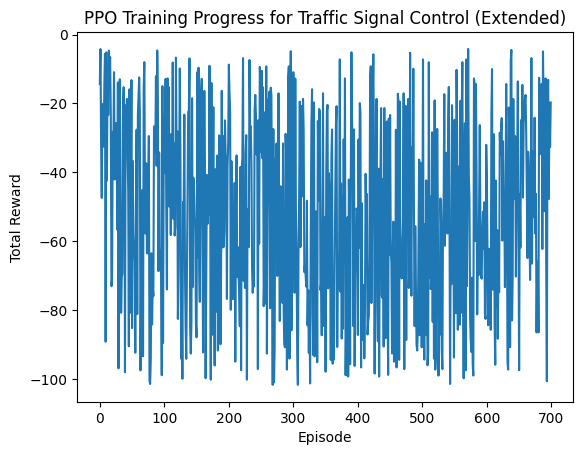

In [13]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("PPO Training Progress for Traffic Signal Control (Extended)")
plt.show()

In [14]:
# Re-initialize the PPOAgent model structure
loaded_agent = PPOAgent(state_dim=len(data.columns)-1, action_dim=4)

# Load the state dictionary into the agent
loaded_agent.load_state_dict(torch.load("ppo_traffic_model.pt"))
loaded_agent.eval() # Set the model to evaluation mode

print("Model loaded successfully!")

Model loaded successfully!


In [15]:
print("Continuing training for 1000 more episodes...")
new_rewards = train_ppo(episodes=1000)
rewards.extend(new_rewards)
print("Training complete.")

Continuing training for 1000 more episodes...


  0%|          | 1/1000 [00:00<13:54,  1.20it/s]

Episode 1 | Total Reward: -26.86


  0%|          | 2/1000 [00:01<11:48,  1.41it/s]

Episode 2 | Total Reward: -20.08


  0%|          | 3/1000 [00:02<10:59,  1.51it/s]

Episode 3 | Total Reward: -18.98


  0%|          | 4/1000 [00:03<14:07,  1.18it/s]

Episode 4 | Total Reward: -36.60


  0%|          | 5/1000 [00:05<24:19,  1.47s/it]

Episode 5 | Total Reward: -82.17


  1%|          | 6/1000 [00:06<18:59,  1.15s/it]

Episode 6 | Total Reward: -17.08


  1%|          | 7/1000 [00:07<17:53,  1.08s/it]

Episode 7 | Total Reward: -28.87


  1%|          | 8/1000 [00:08<18:25,  1.11s/it]

Episode 8 | Total Reward: -38.42


  1%|          | 9/1000 [00:10<23:57,  1.45s/it]

Episode 9 | Total Reward: -70.58


  1%|          | 11/1000 [00:11<15:30,  1.06it/s]

Episode 10 | Total Reward: -27.74
Episode 11 | Total Reward: -5.57


  1%|          | 12/1000 [00:14<24:09,  1.47s/it]

Episode 12 | Total Reward: -84.14


  1%|▏         | 13/1000 [00:15<20:45,  1.26s/it]

Episode 13 | Total Reward: -23.49


  1%|▏         | 14/1000 [00:15<15:38,  1.05it/s]

Episode 14 | Total Reward: -8.35


  2%|▏         | 15/1000 [00:17<18:56,  1.15s/it]

Episode 15 | Total Reward: -51.33


  2%|▏         | 16/1000 [00:19<24:33,  1.50s/it]

Episode 16 | Total Reward: -74.46


  2%|▏         | 17/1000 [00:20<22:58,  1.40s/it]

Episode 17 | Total Reward: -37.59


  2%|▏         | 18/1000 [00:21<22:57,  1.40s/it]

Episode 18 | Total Reward: -45.17


  2%|▏         | 19/1000 [00:22<18:32,  1.13s/it]

Episode 19 | Total Reward: -16.51


  2%|▏         | 20/1000 [00:24<21:33,  1.32s/it]

Episode 20 | Total Reward: -55.63


  2%|▏         | 22/1000 [00:27<21:54,  1.34s/it]

Episode 21 | Total Reward: -99.83
Episode 22 | Total Reward: -6.70


  2%|▏         | 23/1000 [00:28<18:46,  1.15s/it]

Episode 23 | Total Reward: -22.70


  2%|▏         | 24/1000 [00:30<26:05,  1.60s/it]

Episode 24 | Total Reward: -87.14


  2%|▎         | 25/1000 [00:33<29:28,  1.81s/it]

Episode 25 | Total Reward: -75.20


  3%|▎         | 26/1000 [00:34<29:52,  1.84s/it]

Episode 26 | Total Reward: -60.36


  3%|▎         | 27/1000 [00:35<25:47,  1.59s/it]

Episode 27 | Total Reward: -31.03


  3%|▎         | 28/1000 [00:37<27:14,  1.68s/it]

Episode 28 | Total Reward: -61.60


  3%|▎         | 29/1000 [00:39<25:58,  1.60s/it]

Episode 29 | Total Reward: -46.04


  3%|▎         | 30/1000 [00:40<26:08,  1.62s/it]

Episode 30 | Total Reward: -51.04


  3%|▎         | 31/1000 [00:42<28:15,  1.75s/it]

Episode 31 | Total Reward: -66.67


  3%|▎         | 32/1000 [00:45<32:49,  2.03s/it]

Episode 32 | Total Reward: -85.22


  3%|▎         | 33/1000 [00:46<29:15,  1.82s/it]

Episode 33 | Total Reward: -42.19


  3%|▎         | 34/1000 [00:47<23:48,  1.48s/it]

Episode 34 | Total Reward: -21.97


  4%|▎         | 35/1000 [00:48<18:38,  1.16s/it]

Episode 35 | Total Reward: -13.90


  4%|▎         | 36/1000 [00:50<25:59,  1.62s/it]

Episode 36 | Total Reward: -87.55


  4%|▎         | 37/1000 [00:52<25:28,  1.59s/it]

Episode 37 | Total Reward: -48.14


  4%|▍         | 38/1000 [00:53<24:52,  1.55s/it]

Episode 38 | Total Reward: -46.95


  4%|▍         | 39/1000 [00:54<19:47,  1.24s/it]

Episode 39 | Total Reward: -16.28


  4%|▍         | 40/1000 [00:55<17:41,  1.11s/it]

Episode 40 | Total Reward: -25.83


  4%|▍         | 41/1000 [00:55<16:46,  1.05s/it]

Episode 41 | Total Reward: -27.74


  4%|▍         | 42/1000 [00:58<23:02,  1.44s/it]

Episode 42 | Total Reward: -76.81


  4%|▍         | 43/1000 [01:00<25:10,  1.58s/it]

Episode 43 | Total Reward: -61.46


  4%|▍         | 44/1000 [01:01<22:17,  1.40s/it]

Episode 44 | Total Reward: -30.95


  4%|▍         | 45/1000 [01:01<19:15,  1.21s/it]

Episode 45 | Total Reward: -24.26


  5%|▍         | 46/1000 [01:04<27:17,  1.72s/it]

Episode 46 | Total Reward: -94.88


  5%|▍         | 47/1000 [01:06<27:41,  1.74s/it]

Episode 47 | Total Reward: -55.06


  5%|▍         | 48/1000 [01:08<26:19,  1.66s/it]

Episode 48 | Total Reward: -46.35


  5%|▍         | 49/1000 [01:11<33:01,  2.08s/it]

Episode 49 | Total Reward: -100.01


  5%|▌         | 50/1000 [01:12<31:25,  1.98s/it]

Episode 50 | Total Reward: -54.98


  5%|▌         | 51/1000 [01:13<26:34,  1.68s/it]

Episode 51 | Total Reward: -31.03


  5%|▌         | 52/1000 [01:16<29:48,  1.89s/it]

Episode 52 | Total Reward: -76.01


  5%|▌         | 53/1000 [01:17<24:32,  1.56s/it]

Episode 53 | Total Reward: -25.51


  5%|▌         | 54/1000 [01:19<26:10,  1.66s/it]

Episode 54 | Total Reward: -60.36


  6%|▌         | 55/1000 [01:20<25:37,  1.63s/it]

Episode 55 | Total Reward: -48.07


  6%|▌         | 56/1000 [01:21<21:02,  1.34s/it]

Episode 56 | Total Reward: -20.99


  6%|▌         | 57/1000 [01:23<25:36,  1.63s/it]

Episode 57 | Total Reward: -74.17


  6%|▌         | 58/1000 [01:24<20:15,  1.29s/it]

Episode 58 | Total Reward: -16.28


  6%|▌         | 59/1000 [01:26<25:39,  1.64s/it]

Episode 59 | Total Reward: -77.62


  6%|▌         | 60/1000 [01:27<24:14,  1.55s/it]

Episode 60 | Total Reward: -43.08


  6%|▌         | 61/1000 [01:29<23:22,  1.49s/it]

Episode 61 | Total Reward: -43.38


  6%|▌         | 62/1000 [01:31<28:43,  1.84s/it]

Episode 62 | Total Reward: -86.63


  6%|▋         | 63/1000 [01:34<33:51,  2.17s/it]

Episode 63 | Total Reward: -97.04


  6%|▋         | 64/1000 [01:35<28:53,  1.85s/it]

Episode 64 | Total Reward: -35.48


  6%|▋         | 65/1000 [01:36<21:29,  1.38s/it]

Episode 65 | Total Reward: -8.88


  7%|▋         | 66/1000 [01:39<28:57,  1.86s/it]

Episode 66 | Total Reward: -98.28


  7%|▋         | 67/1000 [01:39<24:06,  1.55s/it]

Episode 67 | Total Reward: -26.54


  7%|▋         | 68/1000 [01:42<26:54,  1.73s/it]

Episode 68 | Total Reward: -70.08


  7%|▋         | 69/1000 [01:43<24:32,  1.58s/it]

Episode 69 | Total Reward: -39.73


  7%|▋         | 70/1000 [01:44<20:31,  1.32s/it]

Episode 70 | Total Reward: -23.39


  7%|▋         | 71/1000 [01:44<16:33,  1.07s/it]

Episode 71 | Total Reward: -15.72


  7%|▋         | 72/1000 [01:46<19:37,  1.27s/it]

Episode 72 | Total Reward: -52.24


  7%|▋         | 73/1000 [01:46<16:17,  1.05s/it]

Episode 73 | Total Reward: -18.18


  7%|▋         | 74/1000 [01:49<22:24,  1.45s/it]

Episode 74 | Total Reward: -77.84


  8%|▊         | 75/1000 [01:49<18:04,  1.17s/it]

Episode 75 | Total Reward: -17.17


  8%|▊         | 77/1000 [01:52<17:21,  1.13s/it]

Episode 76 | Total Reward: -76.01
Episode 77 | Total Reward: -6.92


  8%|▊         | 78/1000 [01:54<23:27,  1.53s/it]

Episode 78 | Total Reward: -81.17


  8%|▊         | 79/1000 [01:55<20:34,  1.34s/it]

Episode 79 | Total Reward: -28.01


  8%|▊         | 80/1000 [01:58<25:47,  1.68s/it]

Episode 80 | Total Reward: -79.46


  8%|▊         | 81/1000 [01:59<24:21,  1.59s/it]

Episode 81 | Total Reward: -44.69


  8%|▊         | 82/1000 [02:01<26:36,  1.74s/it]

Episode 82 | Total Reward: -66.39


  8%|▊         | 83/1000 [02:02<20:33,  1.35s/it]

Episode 83 | Total Reward: -13.95


  8%|▊         | 84/1000 [02:02<18:43,  1.23s/it]

Episode 84 | Total Reward: -30.37


  8%|▊         | 85/1000 [02:05<23:11,  1.52s/it]

Episode 85 | Total Reward: -71.02


  9%|▊         | 86/1000 [02:06<20:47,  1.36s/it]

Episode 86 | Total Reward: -31.33


  9%|▊         | 87/1000 [02:07<22:34,  1.48s/it]

Episode 87 | Total Reward: -54.73


  9%|▉         | 88/1000 [02:09<24:11,  1.59s/it]

Episode 88 | Total Reward: -58.91


  9%|▉         | 89/1000 [02:11<22:30,  1.48s/it]

Episode 89 | Total Reward: -38.42


  9%|▉         | 90/1000 [02:11<20:12,  1.33s/it]

Episode 90 | Total Reward: -30.96


  9%|▉         | 91/1000 [02:13<19:55,  1.32s/it]

Episode 91 | Total Reward: -40.19


  9%|▉         | 92/1000 [02:13<15:19,  1.01s/it]

Episode 92 | Total Reward: -10.53


  9%|▉         | 93/1000 [02:15<19:35,  1.30s/it]

Episode 93 | Total Reward: -62.76


  9%|▉         | 94/1000 [02:16<17:13,  1.14s/it]

Episode 94 | Total Reward: -24.83


 10%|▉         | 95/1000 [02:17<17:15,  1.14s/it]

Episode 95 | Total Reward: -35.89


 10%|▉         | 96/1000 [02:19<19:39,  1.31s/it]

Episode 96 | Total Reward: -51.76


 10%|▉         | 97/1000 [02:19<16:59,  1.13s/it]

Episode 97 | Total Reward: -22.87


 10%|▉         | 98/1000 [02:20<15:24,  1.02s/it]

Episode 98 | Total Reward: -25.22


 10%|▉         | 99/1000 [02:21<16:29,  1.10s/it]

Episode 99 | Total Reward: -40.21


 10%|█         | 100/1000 [02:22<15:30,  1.03s/it]

Episode 100 | Total Reward: -28.12


 10%|█         | 101/1000 [02:25<22:34,  1.51s/it]

Episode 101 | Total Reward: -84.20


 10%|█         | 103/1000 [02:26<13:29,  1.11it/s]

Episode 102 | Total Reward: -18.02
Episode 103 | Total Reward: -4.81


 10%|█         | 104/1000 [02:27<16:52,  1.13s/it]

Episode 104 | Total Reward: -51.69


 10%|█         | 105/1000 [02:29<21:24,  1.44s/it]

Episode 105 | Total Reward: -69.57


 11%|█         | 106/1000 [02:33<28:40,  1.92s/it]

Episode 106 | Total Reward: -99.31


 11%|█         | 107/1000 [02:34<26:22,  1.77s/it]

Episode 107 | Total Reward: -44.81


 11%|█         | 108/1000 [02:35<24:37,  1.66s/it]

Episode 108 | Total Reward: -44.45


 11%|█         | 109/1000 [02:38<30:39,  2.06s/it]

Episode 109 | Total Reward: -97.42


 11%|█         | 110/1000 [02:40<27:48,  1.87s/it]

Episode 110 | Total Reward: -45.08


 11%|█         | 111/1000 [02:42<30:45,  2.08s/it]

Episode 111 | Total Reward: -82.00


 11%|█         | 112/1000 [02:44<26:59,  1.82s/it]

Episode 112 | Total Reward: -39.77


 11%|█▏        | 113/1000 [02:44<21:52,  1.48s/it]

Episode 113 | Total Reward: -21.17


 12%|█▏        | 115/1000 [02:47<18:09,  1.23s/it]

Episode 114 | Total Reward: -70.49
Episode 115 | Total Reward: -5.06


 12%|█▏        | 116/1000 [02:49<24:51,  1.69s/it]

Episode 116 | Total Reward: -89.15


 12%|█▏        | 117/1000 [02:51<23:25,  1.59s/it]

Episode 117 | Total Reward: -42.69


 12%|█▏        | 118/1000 [02:53<26:28,  1.80s/it]

Episode 118 | Total Reward: -74.16


 12%|█▏        | 119/1000 [02:56<30:04,  2.05s/it]

Episode 119 | Total Reward: -85.18


 12%|█▏        | 121/1000 [02:58<21:33,  1.47s/it]

Episode 120 | Total Reward: -61.39
Episode 121 | Total Reward: -6.47


 12%|█▏        | 122/1000 [02:59<19:14,  1.31s/it]

Episode 122 | Total Reward: -29.18


 12%|█▏        | 123/1000 [03:00<20:04,  1.37s/it]

Episode 123 | Total Reward: -47.98


 12%|█▏        | 124/1000 [03:01<18:27,  1.26s/it]

Episode 124 | Total Reward: -30.09


 12%|█▎        | 125/1000 [03:04<25:39,  1.76s/it]

Episode 125 | Total Reward: -95.69


 13%|█▎        | 126/1000 [03:06<27:39,  1.90s/it]

Episode 126 | Total Reward: -70.58


 13%|█▎        | 127/1000 [03:09<31:38,  2.17s/it]

Episode 127 | Total Reward: -91.28


 13%|█▎        | 128/1000 [03:12<33:16,  2.29s/it]

Episode 128 | Total Reward: -83.63


 13%|█▎        | 129/1000 [03:12<25:19,  1.74s/it]

Episode 129 | Total Reward: -15.29


 13%|█▎        | 130/1000 [03:14<27:34,  1.90s/it]

Episode 130 | Total Reward: -74.06


 13%|█▎        | 131/1000 [03:17<31:57,  2.21s/it]

Episode 131 | Total Reward: -93.39


 13%|█▎        | 132/1000 [03:18<23:56,  1.66s/it]

Episode 132 | Total Reward: -12.07


 13%|█▎        | 133/1000 [03:19<21:48,  1.51s/it]

Episode 133 | Total Reward: -38.01


 13%|█▎        | 134/1000 [03:20<21:03,  1.46s/it]

Episode 134 | Total Reward: -43.62


 14%|█▎        | 135/1000 [03:23<26:50,  1.86s/it]

Episode 135 | Total Reward: -90.35


 14%|█▎        | 136/1000 [03:24<24:25,  1.70s/it]

Episode 136 | Total Reward: -42.19


 14%|█▎        | 137/1000 [03:27<28:13,  1.96s/it]

Episode 137 | Total Reward: -83.63


 14%|█▍        | 138/1000 [03:30<30:51,  2.15s/it]

Episode 138 | Total Reward: -82.66


 14%|█▍        | 139/1000 [03:31<28:52,  2.01s/it]

Episode 139 | Total Reward: -52.31


 14%|█▍        | 140/1000 [03:33<27:33,  1.92s/it]

Episode 140 | Total Reward: -54.98


 14%|█▍        | 141/1000 [03:35<28:24,  1.98s/it]

Episode 141 | Total Reward: -68.05


 14%|█▍        | 142/1000 [03:37<30:07,  2.11s/it]

Episode 142 | Total Reward: -75.61


 14%|█▍        | 144/1000 [03:39<20:37,  1.45s/it]

Episode 143 | Total Reward: -52.48
Episode 144 | Total Reward: -7.22


 14%|█▍        | 145/1000 [03:42<23:37,  1.66s/it]

Episode 145 | Total Reward: -69.92


 15%|█▍        | 146/1000 [03:43<23:53,  1.68s/it]

Episode 146 | Total Reward: -55.57


 15%|█▍        | 147/1000 [03:44<18:00,  1.27s/it]

Episode 147 | Total Reward: -10.10


 15%|█▍        | 148/1000 [03:44<15:08,  1.07s/it]

Episode 148 | Total Reward: -19.13


 15%|█▍        | 149/1000 [03:46<20:30,  1.45s/it]

Episode 149 | Total Reward: -74.80


 15%|█▌        | 150/1000 [03:47<18:22,  1.30s/it]

Episode 150 | Total Reward: -30.86


 15%|█▌        | 151/1000 [03:49<19:48,  1.40s/it]

Episode 151 | Total Reward: -51.10


 15%|█▌        | 152/1000 [03:50<18:22,  1.30s/it]

Episode 152 | Total Reward: -33.46


 15%|█▌        | 153/1000 [03:51<14:34,  1.03s/it]

Episode 153 | Total Reward: -13.60


 15%|█▌        | 154/1000 [03:53<21:56,  1.56s/it]

Episode 154 | Total Reward: -90.72


 16%|█▌        | 155/1000 [03:54<19:20,  1.37s/it]

Episode 155 | Total Reward: -30.49


 16%|█▌        | 156/1000 [03:57<24:19,  1.73s/it]

Episode 156 | Total Reward: -80.84


 16%|█▌        | 157/1000 [03:59<26:52,  1.91s/it]

Episode 157 | Total Reward: -75.31


 16%|█▌        | 158/1000 [04:00<20:19,  1.45s/it]

Episode 158 | Total Reward: -12.12


 16%|█▌        | 159/1000 [04:01<21:32,  1.54s/it]

Episode 159 | Total Reward: -53.76


 16%|█▌        | 160/1000 [04:04<24:45,  1.77s/it]

Episode 160 | Total Reward: -74.16


 16%|█▌        | 161/1000 [04:07<29:42,  2.12s/it]

Episode 161 | Total Reward: -95.91


 16%|█▋        | 163/1000 [04:07<15:57,  1.14s/it]

Episode 162 | Total Reward: -7.45
Episode 163 | Total Reward: -7.22


 16%|█▋        | 164/1000 [04:07<13:10,  1.06it/s]

Episode 164 | Total Reward: -16.01


 16%|█▋        | 165/1000 [04:08<13:37,  1.02it/s]

Episode 165 | Total Reward: -32.69


 17%|█▋        | 166/1000 [04:10<15:34,  1.12s/it]

Episode 166 | Total Reward: -46.32


 17%|█▋        | 167/1000 [04:13<23:30,  1.69s/it]

Episode 167 | Total Reward: -97.08


 17%|█▋        | 168/1000 [04:14<20:59,  1.51s/it]

Episode 168 | Total Reward: -35.48


 17%|█▋        | 169/1000 [04:15<18:45,  1.35s/it]

Episode 169 | Total Reward: -31.03


 17%|█▋        | 170/1000 [04:16<15:53,  1.15s/it]

Episode 170 | Total Reward: -21.41


 17%|█▋        | 171/1000 [04:17<14:38,  1.06s/it]

Episode 171 | Total Reward: -27.13


 17%|█▋        | 172/1000 [04:18<17:34,  1.27s/it]

Episode 172 | Total Reward: -54.98


 17%|█▋        | 173/1000 [04:21<21:57,  1.59s/it]

Episode 173 | Total Reward: -76.73


 17%|█▋        | 174/1000 [04:22<22:04,  1.60s/it]

Episode 174 | Total Reward: -51.55


 18%|█▊        | 175/1000 [04:25<27:18,  1.99s/it]

Episode 175 | Total Reward: -94.39


 18%|█▊        | 176/1000 [04:28<29:03,  2.12s/it]

Episode 176 | Total Reward: -78.83


 18%|█▊        | 177/1000 [04:29<25:13,  1.84s/it]

Episode 177 | Total Reward: -36.72


 18%|█▊        | 178/1000 [04:30<22:48,  1.66s/it]

Episode 178 | Total Reward: -40.95


 18%|█▊        | 179/1000 [04:33<27:12,  1.99s/it]

Episode 179 | Total Reward: -89.85


 18%|█▊        | 180/1000 [04:35<26:55,  1.97s/it]

Episode 180 | Total Reward: -61.60


 18%|█▊        | 181/1000 [04:35<20:37,  1.51s/it]

Episode 181 | Total Reward: -14.23


 18%|█▊        | 182/1000 [04:36<19:21,  1.42s/it]

Episode 182 | Total Reward: -38.37


 18%|█▊        | 183/1000 [04:37<16:16,  1.19s/it]

Episode 183 | Total Reward: -20.71


 18%|█▊        | 185/1000 [04:38<11:04,  1.23it/s]

Episode 184 | Total Reward: -26.54
Episode 185 | Total Reward: -7.45


 19%|█▊        | 186/1000 [04:40<14:07,  1.04s/it]

Episode 186 | Total Reward: -48.21


 19%|█▊        | 187/1000 [04:41<16:36,  1.23s/it]

Episode 187 | Total Reward: -52.56


 19%|█▉        | 188/1000 [04:42<16:06,  1.19s/it]

Episode 188 | Total Reward: -34.78


 19%|█▉        | 189/1000 [04:44<19:36,  1.45s/it]

Episode 189 | Total Reward: -66.86


 19%|█▉        | 190/1000 [04:47<25:25,  1.88s/it]

Episode 190 | Total Reward: -94.40


 19%|█▉        | 191/1000 [04:50<28:48,  2.14s/it]

Episode 191 | Total Reward: -89.00


 19%|█▉        | 192/1000 [04:51<23:04,  1.71s/it]

Episode 192 | Total Reward: -23.06


 19%|█▉        | 193/1000 [04:54<28:33,  2.12s/it]

Episode 193 | Total Reward: -100.63


 19%|█▉        | 194/1000 [04:56<29:46,  2.22s/it]

Episode 194 | Total Reward: -78.31


 20%|█▉        | 195/1000 [04:58<28:04,  2.09s/it]

Episode 195 | Total Reward: -57.45


 20%|█▉        | 196/1000 [05:01<30:21,  2.27s/it]

Episode 196 | Total Reward: -85.95


 20%|█▉        | 197/1000 [05:03<29:27,  2.20s/it]

Episode 197 | Total Reward: -66.48


 20%|█▉        | 198/1000 [05:05<27:43,  2.07s/it]

Episode 198 | Total Reward: -57.45


 20%|█▉        | 199/1000 [05:06<26:12,  1.96s/it]

Episode 199 | Total Reward: -54.21


 20%|██        | 200/1000 [05:09<28:38,  2.15s/it]

Episode 200 | Total Reward: -83.66


 20%|██        | 201/1000 [05:11<29:50,  2.24s/it]

Episode 201 | Total Reward: -79.90


 20%|██        | 202/1000 [05:12<24:28,  1.84s/it]

Episode 202 | Total Reward: -27.90


 20%|██        | 203/1000 [05:14<22:39,  1.71s/it]

Episode 203 | Total Reward: -45.08


 20%|██        | 204/1000 [05:16<23:50,  1.80s/it]

Episode 204 | Total Reward: -65.84


 20%|██        | 205/1000 [05:16<19:01,  1.44s/it]

Episode 205 | Total Reward: -18.92


 21%|██        | 206/1000 [05:18<21:43,  1.64s/it]

Episode 206 | Total Reward: -67.97


 21%|██        | 207/1000 [05:19<16:57,  1.28s/it]

Episode 207 | Total Reward: -14.62


 21%|██        | 208/1000 [05:20<15:56,  1.21s/it]

Episode 208 | Total Reward: -32.22


 21%|██        | 209/1000 [05:23<23:22,  1.77s/it]

Episode 209 | Total Reward: -100.27


 21%|██        | 210/1000 [05:24<22:06,  1.68s/it]

Episode 210 | Total Reward: -46.40


 21%|██        | 211/1000 [05:26<20:59,  1.60s/it]

Episode 211 | Total Reward: -45.17


 21%|██        | 212/1000 [05:27<18:36,  1.42s/it]

Episode 212 | Total Reward: -31.40


 21%|██▏       | 213/1000 [05:29<23:14,  1.77s/it]

Episode 213 | Total Reward: -82.66


 21%|██▏       | 214/1000 [05:32<25:34,  1.95s/it]

Episode 214 | Total Reward: -77.44


 22%|██▏       | 216/1000 [05:33<15:32,  1.19s/it]

Episode 215 | Total Reward: -26.93
Episode 216 | Total Reward: -6.83


 22%|██▏       | 217/1000 [05:35<19:04,  1.46s/it]

Episode 217 | Total Reward: -67.07


 22%|██▏       | 218/1000 [05:36<17:43,  1.36s/it]

Episode 218 | Total Reward: -36.18


 22%|██▏       | 219/1000 [05:39<23:18,  1.79s/it]

Episode 219 | Total Reward: -91.42


 22%|██▏       | 220/1000 [05:39<18:22,  1.41s/it]

Episode 220 | Total Reward: -16.55


 22%|██▏       | 222/1000 [05:42<15:49,  1.22s/it]

Episode 221 | Total Reward: -71.51
Episode 222 | Total Reward: -6.70


 22%|██▏       | 223/1000 [05:43<16:39,  1.29s/it]

Episode 223 | Total Reward: -45.98


 22%|██▏       | 224/1000 [05:45<17:16,  1.34s/it]

Episode 224 | Total Reward: -46.20


 22%|██▎       | 225/1000 [05:45<15:10,  1.18s/it]

Episode 225 | Total Reward: -25.90


 23%|██▎       | 226/1000 [05:46<14:02,  1.09s/it]

Episode 226 | Total Reward: -28.62


 23%|██▎       | 227/1000 [05:47<12:03,  1.07it/s]

Episode 227 | Total Reward: -18.18


 23%|██▎       | 228/1000 [05:48<12:18,  1.05it/s]

Episode 228 | Total Reward: -31.48


 23%|██▎       | 229/1000 [05:51<20:18,  1.58s/it]

Episode 229 | Total Reward: -98.65


 23%|██▎       | 230/1000 [05:52<17:43,  1.38s/it]

Episode 230 | Total Reward: -28.87


 23%|██▎       | 231/1000 [05:55<24:19,  1.90s/it]

Episode 231 | Total Reward: -101.69


 23%|██▎       | 232/1000 [05:57<25:24,  1.99s/it]

Episode 232 | Total Reward: -70.36


 23%|██▎       | 233/1000 [05:59<23:00,  1.80s/it]

Episode 233 | Total Reward: -42.81


 23%|██▎       | 234/1000 [06:00<20:43,  1.62s/it]

Episode 234 | Total Reward: -37.93


 24%|██▎       | 235/1000 [06:02<23:29,  1.84s/it]

Episode 235 | Total Reward: -75.31


 24%|██▎       | 236/1000 [06:02<17:40,  1.39s/it]

Episode 236 | Total Reward: -11.08


 24%|██▎       | 237/1000 [06:04<17:46,  1.40s/it]

Episode 237 | Total Reward: -45.26


 24%|██▍       | 238/1000 [06:07<22:44,  1.79s/it]

Episode 238 | Total Reward: -88.23


 24%|██▍       | 239/1000 [06:09<24:20,  1.92s/it]

Episode 239 | Total Reward: -70.85


 24%|██▍       | 240/1000 [06:10<19:56,  1.57s/it]

Episode 240 | Total Reward: -24.79


 24%|██▍       | 241/1000 [06:12<24:24,  1.93s/it]

Episode 241 | Total Reward: -87.55


 24%|██▍       | 242/1000 [06:13<20:15,  1.60s/it]

Episode 242 | Total Reward: -26.61


 24%|██▍       | 243/1000 [06:13<15:21,  1.22s/it]

Episode 243 | Total Reward: -10.41


 24%|██▍       | 244/1000 [06:15<15:11,  1.21s/it]

Episode 244 | Total Reward: -37.93


 24%|██▍       | 245/1000 [06:18<21:51,  1.74s/it]

Episode 245 | Total Reward: -96.99


 25%|██▍       | 246/1000 [06:21<26:52,  2.14s/it]

Episode 246 | Total Reward: -99.70


 25%|██▍       | 247/1000 [06:22<21:45,  1.73s/it]

Episode 247 | Total Reward: -25.39


 25%|██▍       | 248/1000 [06:22<18:41,  1.49s/it]

Episode 248 | Total Reward: -28.87


 25%|██▍       | 249/1000 [06:23<14:27,  1.16s/it]

Episode 249 | Total Reward: -12.14


 25%|██▌       | 250/1000 [06:24<13:01,  1.04s/it]

Episode 250 | Total Reward: -24.17


 25%|██▌       | 251/1000 [06:26<18:57,  1.52s/it]

Episode 251 | Total Reward: -85.69


 25%|██▌       | 252/1000 [06:28<18:37,  1.49s/it]

Episode 252 | Total Reward: -45.26


 25%|██▌       | 253/1000 [06:29<18:20,  1.47s/it]

Episode 253 | Total Reward: -45.38


 25%|██▌       | 254/1000 [06:31<20:21,  1.64s/it]

Episode 254 | Total Reward: -65.11


 26%|██▌       | 255/1000 [06:32<16:42,  1.35s/it]

Episode 255 | Total Reward: -20.76


 26%|██▌       | 256/1000 [06:33<14:47,  1.19s/it]

Episode 256 | Total Reward: -27.05


 26%|██▌       | 257/1000 [06:35<19:46,  1.60s/it]

Episode 257 | Total Reward: -81.43


 26%|██▌       | 258/1000 [06:38<23:47,  1.92s/it]

Episode 258 | Total Reward: -87.78


 26%|██▌       | 259/1000 [06:39<22:34,  1.83s/it]

Episode 259 | Total Reward: -49.38


 26%|██▌       | 260/1000 [06:40<17:12,  1.40s/it]

Episode 260 | Total Reward: -13.15


 26%|██▌       | 261/1000 [06:41<15:05,  1.23s/it]

Episode 261 | Total Reward: -25.60


 26%|██▌       | 262/1000 [06:43<20:13,  1.64s/it]

Episode 262 | Total Reward: -85.12


 26%|██▋       | 263/1000 [06:45<20:51,  1.70s/it]

Episode 263 | Total Reward: -58.49


 26%|██▋       | 264/1000 [06:46<16:37,  1.36s/it]

Episode 264 | Total Reward: -18.18


 26%|██▋       | 265/1000 [06:48<20:38,  1.69s/it]

Episode 265 | Total Reward: -80.76


 27%|██▋       | 266/1000 [06:50<21:22,  1.75s/it]

Episode 266 | Total Reward: -60.42


 27%|██▋       | 267/1000 [06:52<21:55,  1.79s/it]

Episode 267 | Total Reward: -60.24


 27%|██▋       | 268/1000 [06:52<16:52,  1.38s/it]

Episode 268 | Total Reward: -13.60


 27%|██▋       | 270/1000 [06:54<12:34,  1.03s/it]

Episode 269 | Total Reward: -46.76
Episode 270 | Total Reward: -5.74


 27%|██▋       | 271/1000 [06:57<19:57,  1.64s/it]

Episode 271 | Total Reward: -100.06


 27%|██▋       | 272/1000 [06:58<16:58,  1.40s/it]

Episode 272 | Total Reward: -26.95


 27%|██▋       | 273/1000 [07:01<22:41,  1.87s/it]

Episode 273 | Total Reward: -97.10


 27%|██▋       | 274/1000 [07:04<26:17,  2.17s/it]

Episode 274 | Total Reward: -93.83


 28%|██▊       | 276/1000 [07:05<15:05,  1.25s/it]

Episode 275 | Total Reward: -21.97
Episode 276 | Total Reward: -5.02


 28%|██▊       | 277/1000 [07:07<19:37,  1.63s/it]

Episode 277 | Total Reward: -81.25


 28%|██▊       | 278/1000 [07:08<15:41,  1.30s/it]

Episode 278 | Total Reward: -17.65


 28%|██▊       | 279/1000 [07:10<17:57,  1.49s/it]

Episode 279 | Total Reward: -62.28


 28%|██▊       | 280/1000 [07:11<19:18,  1.61s/it]

Episode 280 | Total Reward: -59.31


 28%|██▊       | 281/1000 [07:12<16:41,  1.39s/it]

Episode 281 | Total Reward: -27.64


 28%|██▊       | 282/1000 [07:13<13:16,  1.11s/it]

Episode 282 | Total Reward: -14.46


 28%|██▊       | 283/1000 [07:14<13:51,  1.16s/it]

Episode 283 | Total Reward: -40.21


 28%|██▊       | 284/1000 [07:14<10:26,  1.14it/s]

Episode 284 | Total Reward: -7.67


 28%|██▊       | 285/1000 [07:17<16:34,  1.39s/it]

Episode 285 | Total Reward: -85.41


 29%|██▊       | 286/1000 [07:17<13:01,  1.09s/it]

Episode 286 | Total Reward: -12.74


 29%|██▊       | 287/1000 [07:20<18:37,  1.57s/it]

Episode 287 | Total Reward: -86.52


 29%|██▉       | 288/1000 [07:20<15:05,  1.27s/it]

Episode 288 | Total Reward: -18.83


 29%|██▉       | 289/1000 [07:23<20:44,  1.75s/it]

Episode 289 | Total Reward: -91.52


 29%|██▉       | 290/1000 [07:24<16:55,  1.43s/it]

Episode 290 | Total Reward: -21.45


 29%|██▉       | 291/1000 [07:25<15:11,  1.29s/it]

Episode 291 | Total Reward: -30.52


 29%|██▉       | 292/1000 [07:26<15:52,  1.35s/it]

Episode 292 | Total Reward: -47.49


 29%|██▉       | 293/1000 [07:29<20:23,  1.73s/it]

Episode 293 | Total Reward: -84.65


 29%|██▉       | 294/1000 [07:30<17:48,  1.51s/it]

Episode 294 | Total Reward: -32.52


 30%|██▉       | 295/1000 [07:31<14:35,  1.24s/it]

Episode 295 | Total Reward: -19.86


 30%|██▉       | 296/1000 [07:31<11:51,  1.01s/it]

Episode 296 | Total Reward: -14.98


 30%|██▉       | 297/1000 [07:34<19:24,  1.66s/it]

Episode 297 | Total Reward: -100.92


 30%|██▉       | 298/1000 [07:37<22:56,  1.96s/it]

Episode 298 | Total Reward: -87.55


 30%|██▉       | 299/1000 [07:38<21:18,  1.82s/it]

Episode 299 | Total Reward: -47.30


 30%|███       | 300/1000 [07:41<23:29,  2.01s/it]

Episode 300 | Total Reward: -78.96


 30%|███       | 301/1000 [07:42<19:55,  1.71s/it]

Episode 301 | Total Reward: -31.48


 30%|███       | 302/1000 [07:43<19:11,  1.65s/it]

Episode 302 | Total Reward: -48.30


 30%|███       | 303/1000 [07:45<19:37,  1.69s/it]

Episode 303 | Total Reward: -55.24


 30%|███       | 304/1000 [07:47<20:16,  1.75s/it]

Episode 304 | Total Reward: -60.74


 30%|███       | 305/1000 [07:48<16:04,  1.39s/it]

Episode 305 | Total Reward: -17.51


 31%|███       | 306/1000 [07:50<17:50,  1.54s/it]

Episode 306 | Total Reward: -60.83


 31%|███       | 307/1000 [07:50<14:42,  1.27s/it]

Episode 307 | Total Reward: -19.48


 31%|███       | 308/1000 [07:53<19:21,  1.68s/it]

Episode 308 | Total Reward: -83.90


 31%|███       | 309/1000 [07:56<23:04,  2.00s/it]

Episode 309 | Total Reward: -88.66


 31%|███       | 310/1000 [07:58<25:22,  2.21s/it]

Episode 310 | Total Reward: -87.05


 31%|███       | 311/1000 [07:59<18:46,  1.64s/it]

Episode 311 | Total Reward: -10.57


 31%|███       | 312/1000 [08:00<19:08,  1.67s/it]

Episode 312 | Total Reward: -55.09


 31%|███▏      | 313/1000 [08:03<21:54,  1.91s/it]

Episode 313 | Total Reward: -78.96


 31%|███▏      | 314/1000 [08:03<17:07,  1.50s/it]

Episode 314 | Total Reward: -17.17


 32%|███▏      | 315/1000 [08:04<15:01,  1.32s/it]

Episode 315 | Total Reward: -27.90


 32%|███▏      | 316/1000 [08:07<19:15,  1.69s/it]

Episode 316 | Total Reward: -83.07


 32%|███▏      | 317/1000 [08:10<24:01,  2.11s/it]

Episode 317 | Total Reward: -100.98


 32%|███▏      | 318/1000 [08:12<24:31,  2.16s/it]

Episode 318 | Total Reward: -71.66


 32%|███▏      | 319/1000 [08:15<26:19,  2.32s/it]

Episode 319 | Total Reward: -86.76


 32%|███▏      | 320/1000 [08:17<24:54,  2.20s/it]

Episode 320 | Total Reward: -61.66


 32%|███▏      | 322/1000 [08:20<19:59,  1.77s/it]

Episode 321 | Total Reward: -100.86
Episode 322 | Total Reward: -5.17


 32%|███▏      | 323/1000 [08:22<21:45,  1.93s/it]

Episode 323 | Total Reward: -73.29


 32%|███▎      | 325/1000 [08:25<17:31,  1.56s/it]

Episode 324 | Total Reward: -85.86
Episode 325 | Total Reward: -6.47


 33%|███▎      | 326/1000 [08:25<13:19,  1.19s/it]

Episode 326 | Total Reward: -11.01


 33%|███▎      | 327/1000 [08:27<14:53,  1.33s/it]

Episode 327 | Total Reward: -52.48


 33%|███▎      | 328/1000 [08:28<13:14,  1.18s/it]

Episode 328 | Total Reward: -27.12


 33%|███▎      | 329/1000 [08:30<16:16,  1.46s/it]

Episode 329 | Total Reward: -67.05


 33%|███▎      | 330/1000 [08:33<20:48,  1.86s/it]

Episode 330 | Total Reward: -91.07


 33%|███▎      | 331/1000 [08:35<22:14,  1.99s/it]

Episode 331 | Total Reward: -74.16


 33%|███▎      | 332/1000 [08:36<18:23,  1.65s/it]

Episode 332 | Total Reward: -27.61


 33%|███▎      | 333/1000 [08:37<15:10,  1.36s/it]

Episode 333 | Total Reward: -22.32


 33%|███▎      | 334/1000 [08:38<16:26,  1.48s/it]

Episode 334 | Total Reward: -55.09


 34%|███▎      | 335/1000 [08:39<13:39,  1.23s/it]

Episode 335 | Total Reward: -20.50


 34%|███▎      | 336/1000 [08:40<12:27,  1.13s/it]

Episode 336 | Total Reward: -27.47


 34%|███▎      | 337/1000 [08:43<18:47,  1.70s/it]

Episode 337 | Total Reward: -98.12


 34%|███▍      | 338/1000 [08:44<17:35,  1.59s/it]

Episode 338 | Total Reward: -43.04


 34%|███▍      | 339/1000 [08:47<21:49,  1.98s/it]

Episode 339 | Total Reward: -93.28


 34%|███▍      | 340/1000 [08:50<25:08,  2.29s/it]

Episode 340 | Total Reward: -97.85


 34%|███▍      | 341/1000 [08:50<18:14,  1.66s/it]

Episode 341 | Total Reward: -7.45


 34%|███▍      | 342/1000 [08:51<13:31,  1.23s/it]

Episode 342 | Total Reward: -8.44


 34%|███▍      | 343/1000 [08:53<17:43,  1.62s/it]

Episode 343 | Total Reward: -80.77


 34%|███▍      | 344/1000 [08:55<19:34,  1.79s/it]

Episode 344 | Total Reward: -69.80


 34%|███▍      | 345/1000 [08:56<16:34,  1.52s/it]

Episode 345 | Total Reward: -27.05


 35%|███▍      | 346/1000 [08:58<15:32,  1.43s/it]

Episode 346 | Total Reward: -38.66


 35%|███▍      | 347/1000 [09:00<19:17,  1.77s/it]

Episode 347 | Total Reward: -83.77


 35%|███▍      | 348/1000 [09:03<22:05,  2.03s/it]

Episode 348 | Total Reward: -85.22


 35%|███▍      | 349/1000 [09:03<17:35,  1.62s/it]

Episode 349 | Total Reward: -20.88


 35%|███▌      | 350/1000 [09:05<18:17,  1.69s/it]

Episode 350 | Total Reward: -58.49


 35%|███▌      | 351/1000 [09:06<13:51,  1.28s/it]

Episode 351 | Total Reward: -10.92


 35%|███▌      | 352/1000 [09:06<10:39,  1.01it/s]

Episode 352 | Total Reward: -10.00


 35%|███▌      | 353/1000 [09:09<16:14,  1.51s/it]

Episode 353 | Total Reward: -87.89


 35%|███▌      | 354/1000 [09:10<16:10,  1.50s/it]

Episode 354 | Total Reward: -47.30


 36%|███▌      | 355/1000 [09:13<19:13,  1.79s/it]

Episode 355 | Total Reward: -80.01


 36%|███▌      | 356/1000 [09:13<15:24,  1.44s/it]

Episode 356 | Total Reward: -18.50


 36%|███▌      | 357/1000 [09:14<14:48,  1.38s/it]

Episode 357 | Total Reward: -40.24


 36%|███▌      | 358/1000 [09:16<14:55,  1.40s/it]

Episode 358 | Total Reward: -45.26


 36%|███▌      | 359/1000 [09:18<18:10,  1.70s/it]

Episode 359 | Total Reward: -77.55


 36%|███▌      | 360/1000 [09:21<20:25,  1.91s/it]

Episode 360 | Total Reward: -77.72


 36%|███▌      | 361/1000 [09:22<20:04,  1.89s/it]

Episode 361 | Total Reward: -57.36


 36%|███▌      | 362/1000 [09:23<14:47,  1.39s/it]

Episode 362 | Total Reward: -8.45


 36%|███▋      | 363/1000 [09:25<16:02,  1.51s/it]

Episode 363 | Total Reward: -55.66


 36%|███▋      | 364/1000 [09:26<16:08,  1.52s/it]

Episode 364 | Total Reward: -47.91


 36%|███▋      | 365/1000 [09:29<20:40,  1.95s/it]

Episode 365 | Total Reward: -95.98


 37%|███▋      | 367/1000 [09:32<17:18,  1.64s/it]

Episode 366 | Total Reward: -98.97
Episode 367 | Total Reward: -6.47


 37%|███▋      | 368/1000 [09:34<17:57,  1.70s/it]

Episode 368 | Total Reward: -57.36


 37%|███▋      | 369/1000 [09:35<16:23,  1.56s/it]

Episode 369 | Total Reward: -38.42


 37%|███▋      | 370/1000 [09:37<16:03,  1.53s/it]

Episode 370 | Total Reward: -46.45


 37%|███▋      | 371/1000 [09:38<14:04,  1.34s/it]

Episode 371 | Total Reward: -28.67


 37%|███▋      | 372/1000 [09:39<13:55,  1.33s/it]

Episode 372 | Total Reward: -41.76


 37%|███▋      | 373/1000 [09:41<14:39,  1.40s/it]

Episode 373 | Total Reward: -49.06


 37%|███▋      | 374/1000 [09:42<14:56,  1.43s/it]

Episode 374 | Total Reward: -48.47


 38%|███▊      | 375/1000 [09:44<17:30,  1.68s/it]

Episode 375 | Total Reward: -71.58


 38%|███▊      | 376/1000 [09:47<21:43,  2.09s/it]

Episode 376 | Total Reward: -98.97


 38%|███▊      | 377/1000 [09:50<22:53,  2.21s/it]

Episode 377 | Total Reward: -80.55


 38%|███▊      | 378/1000 [09:52<24:00,  2.32s/it]

Episode 378 | Total Reward: -83.19


 38%|███▊      | 379/1000 [09:55<23:25,  2.26s/it]

Episode 379 | Total Reward: -68.05


 38%|███▊      | 380/1000 [09:56<21:47,  2.11s/it]

Episode 380 | Total Reward: -52.95


 38%|███▊      | 381/1000 [09:57<16:23,  1.59s/it]

Episode 381 | Total Reward: -12.79


 38%|███▊      | 382/1000 [09:58<15:57,  1.55s/it]

Episode 382 | Total Reward: -46.40


 38%|███▊      | 383/1000 [09:59<15:23,  1.50s/it]

Episode 383 | Total Reward: -43.62


 38%|███▊      | 384/1000 [10:01<14:13,  1.39s/it]

Episode 384 | Total Reward: -36.05


 38%|███▊      | 385/1000 [10:02<15:07,  1.48s/it]

Episode 385 | Total Reward: -52.67


 39%|███▊      | 386/1000 [10:04<14:55,  1.46s/it]

Episode 386 | Total Reward: -43.72


 39%|███▊      | 387/1000 [10:05<14:51,  1.45s/it]

Episode 387 | Total Reward: -46.04


 39%|███▉      | 388/1000 [10:07<15:03,  1.48s/it]

Episode 388 | Total Reward: -47.43


 39%|███▉      | 389/1000 [10:09<17:32,  1.72s/it]

Episode 389 | Total Reward: -74.64


 39%|███▉      | 390/1000 [10:12<20:26,  2.01s/it]

Episode 390 | Total Reward: -87.05


 39%|███▉      | 391/1000 [10:12<16:19,  1.61s/it]

Episode 391 | Total Reward: -20.69


 39%|███▉      | 392/1000 [10:13<13:58,  1.38s/it]

Episode 392 | Total Reward: -27.22


 39%|███▉      | 393/1000 [10:14<10:56,  1.08s/it]

Episode 393 | Total Reward: -12.07


 39%|███▉      | 394/1000 [10:16<16:24,  1.62s/it]

Episode 394 | Total Reward: -93.99


 40%|███▉      | 395/1000 [10:18<15:48,  1.57s/it]

Episode 395 | Total Reward: -45.94


 40%|███▉      | 396/1000 [10:19<14:56,  1.48s/it]

Episode 396 | Total Reward: -41.76


 40%|███▉      | 397/1000 [10:21<16:08,  1.61s/it]

Episode 397 | Total Reward: -60.93


 40%|███▉      | 399/1000 [10:22<09:12,  1.09it/s]

Episode 398 | Total Reward: -14.85
Episode 399 | Total Reward: -4.21


 40%|████      | 400/1000 [10:24<14:19,  1.43s/it]

Episode 400 | Total Reward: -84.20


 40%|████      | 401/1000 [10:26<16:27,  1.65s/it]

Episode 401 | Total Reward: -69.86


 40%|████      | 402/1000 [10:29<18:37,  1.87s/it]

Episode 402 | Total Reward: -76.68


 40%|████      | 403/1000 [10:30<15:53,  1.60s/it]

Episode 403 | Total Reward: -30.47


 40%|████      | 404/1000 [10:32<17:31,  1.76s/it]

Episode 404 | Total Reward: -69.10


 40%|████      | 405/1000 [10:33<15:37,  1.58s/it]

Episode 405 | Total Reward: -36.18


 41%|████      | 406/1000 [10:35<16:24,  1.66s/it]

Episode 406 | Total Reward: -57.36


 41%|████      | 407/1000 [10:37<16:42,  1.69s/it]

Episode 407 | Total Reward: -55.48


 41%|████      | 408/1000 [10:37<12:37,  1.28s/it]

Episode 408 | Total Reward: -10.57


 41%|████      | 409/1000 [10:39<15:43,  1.60s/it]

Episode 409 | Total Reward: -74.80


 41%|████      | 410/1000 [10:42<19:29,  1.98s/it]

Episode 410 | Total Reward: -93.06


 41%|████      | 411/1000 [10:45<22:29,  2.29s/it]

Episode 411 | Total Reward: -97.10


 41%|████      | 412/1000 [10:48<22:39,  2.31s/it]

Episode 412 | Total Reward: -76.27


 41%|████▏     | 413/1000 [10:50<22:26,  2.29s/it]

Episode 413 | Total Reward: -72.60


 41%|████▏     | 414/1000 [10:51<18:50,  1.93s/it]

Episode 414 | Total Reward: -33.31


 42%|████▏     | 415/1000 [10:53<17:52,  1.83s/it]

Episode 415 | Total Reward: -50.58


 42%|████▏     | 416/1000 [10:53<13:59,  1.44s/it]

Episode 416 | Total Reward: -17.08


 42%|████▏     | 417/1000 [10:54<13:35,  1.40s/it]

Episode 417 | Total Reward: -41.55


 42%|████▏     | 418/1000 [10:56<14:48,  1.53s/it]

Episode 418 | Total Reward: -55.57


 42%|████▏     | 419/1000 [10:57<11:57,  1.24s/it]

Episode 419 | Total Reward: -17.74


 42%|████▏     | 420/1000 [10:58<11:09,  1.15s/it]

Episode 420 | Total Reward: -31.03


 42%|████▏     | 421/1000 [11:00<15:53,  1.65s/it]

Episode 421 | Total Reward: -90.68


 42%|████▏     | 422/1000 [11:02<14:25,  1.50s/it]

Episode 422 | Total Reward: -35.82


 42%|████▏     | 423/1000 [11:03<13:02,  1.36s/it]

Episode 423 | Total Reward: -32.22


 42%|████▏     | 424/1000 [11:05<15:44,  1.64s/it]

Episode 424 | Total Reward: -73.59


 42%|████▎     | 425/1000 [11:08<19:18,  2.01s/it]

Episode 425 | Total Reward: -92.66


 43%|████▎     | 426/1000 [11:11<22:01,  2.30s/it]

Episode 426 | Total Reward: -97.04


 43%|████▎     | 427/1000 [11:12<17:53,  1.87s/it]

Episode 427 | Total Reward: -27.56


 43%|████▎     | 428/1000 [11:14<19:58,  2.09s/it]

Episode 428 | Total Reward: -85.18


 43%|████▎     | 429/1000 [11:16<19:32,  2.05s/it]

Episode 429 | Total Reward: -62.18


 43%|████▎     | 430/1000 [11:19<21:30,  2.26s/it]

Episode 430 | Total Reward: -89.85


 43%|████▎     | 431/1000 [11:20<16:37,  1.75s/it]

Episode 431 | Total Reward: -18.31


 43%|████▎     | 432/1000 [11:22<17:52,  1.89s/it]

Episode 432 | Total Reward: -70.85


 43%|████▎     | 433/1000 [11:23<16:50,  1.78s/it]

Episode 433 | Total Reward: -48.63


 43%|████▎     | 434/1000 [11:24<14:41,  1.56s/it]

Episode 434 | Total Reward: -33.31


 44%|████▎     | 435/1000 [11:25<13:13,  1.40s/it]

Episode 435 | Total Reward: -32.21


 44%|████▎     | 436/1000 [11:26<11:00,  1.17s/it]

Episode 436 | Total Reward: -20.33


 44%|████▎     | 437/1000 [11:29<14:45,  1.57s/it]

Episode 437 | Total Reward: -81.43


 44%|████▍     | 438/1000 [11:31<16:36,  1.77s/it]

Episode 438 | Total Reward: -73.04


 44%|████▍     | 439/1000 [11:32<16:01,  1.71s/it]

Episode 439 | Total Reward: -49.88


 44%|████▍     | 440/1000 [11:34<15:34,  1.67s/it]

Episode 440 | Total Reward: -49.48


 44%|████▍     | 441/1000 [11:35<12:46,  1.37s/it]

Episode 441 | Total Reward: -21.63


 44%|████▍     | 442/1000 [11:36<12:52,  1.38s/it]

Episode 442 | Total Reward: -45.10


 44%|████▍     | 443/1000 [11:38<15:43,  1.69s/it]

Episode 443 | Total Reward: -78.31


 44%|████▍     | 444/1000 [11:39<12:47,  1.38s/it]

Episode 444 | Total Reward: -20.35


 44%|████▍     | 445/1000 [11:40<11:38,  1.26s/it]

Episode 445 | Total Reward: -30.63


 45%|████▍     | 447/1000 [11:43<11:18,  1.23s/it]

Episode 446 | Total Reward: -85.52
Episode 447 | Total Reward: -7.26


 45%|████▍     | 448/1000 [11:43<09:31,  1.04s/it]

Episode 448 | Total Reward: -19.10


 45%|████▍     | 449/1000 [11:46<13:33,  1.48s/it]

Episode 449 | Total Reward: -80.30


 45%|████▌     | 450/1000 [11:47<12:44,  1.39s/it]

Episode 450 | Total Reward: -37.93


 45%|████▌     | 451/1000 [11:49<13:42,  1.50s/it]

Episode 451 | Total Reward: -56.14


 45%|████▌     | 452/1000 [11:51<15:13,  1.67s/it]

Episode 452 | Total Reward: -66.27


 45%|████▌     | 453/1000 [11:52<13:57,  1.53s/it]

Episode 453 | Total Reward: -38.42


 45%|████▌     | 454/1000 [11:55<16:19,  1.79s/it]

Episode 454 | Total Reward: -78.06


 46%|████▌     | 455/1000 [11:56<14:01,  1.54s/it]

Episode 455 | Total Reward: -29.25


 46%|████▌     | 456/1000 [11:56<11:12,  1.24s/it]

Episode 456 | Total Reward: -16.21


 46%|████▌     | 457/1000 [11:58<13:52,  1.53s/it]

Episode 457 | Total Reward: -71.51


 46%|████▌     | 458/1000 [11:59<12:58,  1.44s/it]

Episode 458 | Total Reward: -38.92


 46%|████▌     | 460/1000 [12:01<09:39,  1.07s/it]

Episode 459 | Total Reward: -46.86
Episode 460 | Total Reward: -6.47


 46%|████▌     | 461/1000 [12:04<13:18,  1.48s/it]

Episode 461 | Total Reward: -79.42


 46%|████▌     | 462/1000 [12:04<11:11,  1.25s/it]

Episode 462 | Total Reward: -22.28


 46%|████▋     | 463/1000 [12:05<09:00,  1.01s/it]

Episode 463 | Total Reward: -14.41


 46%|████▋     | 464/1000 [12:07<12:24,  1.39s/it]

Episode 464 | Total Reward: -71.71


 46%|████▋     | 465/1000 [12:09<14:05,  1.58s/it]

Episode 465 | Total Reward: -65.87


 47%|████▋     | 466/1000 [12:09<10:49,  1.22s/it]

Episode 466 | Total Reward: -12.12


 47%|████▋     | 467/1000 [12:11<12:53,  1.45s/it]

Episode 467 | Total Reward: -64.74


 47%|████▋     | 468/1000 [12:13<13:08,  1.48s/it]

Episode 468 | Total Reward: -48.21


 47%|████▋     | 469/1000 [12:16<16:19,  1.84s/it]

Episode 469 | Total Reward: -87.71


 47%|████▋     | 470/1000 [12:18<18:03,  2.05s/it]

Episode 470 | Total Reward: -79.76


 47%|████▋     | 471/1000 [12:20<16:08,  1.83s/it]

Episode 471 | Total Reward: -42.50


 47%|████▋     | 472/1000 [12:22<17:37,  2.00s/it]

Episode 472 | Total Reward: -77.62


 47%|████▋     | 473/1000 [12:24<17:44,  2.02s/it]

Episode 473 | Total Reward: -66.50


 47%|████▋     | 474/1000 [12:25<14:39,  1.67s/it]

Episode 474 | Total Reward: -27.44


 48%|████▊     | 475/1000 [12:26<12:43,  1.45s/it]

Episode 475 | Total Reward: -30.37


 48%|████▊     | 476/1000 [12:26<09:55,  1.14s/it]

Episode 476 | Total Reward: -12.23


 48%|████▊     | 477/1000 [12:28<11:57,  1.37s/it]

Episode 477 | Total Reward: -61.66


 48%|████▊     | 478/1000 [12:31<14:54,  1.71s/it]

Episode 478 | Total Reward: -82.42


 48%|████▊     | 479/1000 [12:33<16:35,  1.91s/it]

Episode 479 | Total Reward: -76.80


 48%|████▊     | 480/1000 [12:35<16:20,  1.89s/it]

Episode 480 | Total Reward: -57.97


 48%|████▊     | 481/1000 [12:37<17:47,  2.06s/it]

Episode 481 | Total Reward: -78.65


 48%|████▊     | 482/1000 [12:38<13:02,  1.51s/it]

Episode 482 | Total Reward: -8.46


 48%|████▊     | 483/1000 [12:39<13:28,  1.56s/it]

Episode 483 | Total Reward: -52.61


 48%|████▊     | 485/1000 [12:40<09:02,  1.05s/it]

Episode 484 | Total Reward: -36.68
Episode 485 | Total Reward: -5.87


 49%|████▊     | 486/1000 [12:44<14:11,  1.66s/it]

Episode 486 | Total Reward: -100.58


 49%|████▊     | 487/1000 [12:44<11:13,  1.31s/it]

Episode 487 | Total Reward: -16.68


 49%|████▉     | 488/1000 [12:46<12:08,  1.42s/it]

Episode 488 | Total Reward: -52.02


 49%|████▉     | 489/1000 [12:49<15:57,  1.87s/it]

Episode 489 | Total Reward: -94.87


 49%|████▉     | 490/1000 [12:50<15:41,  1.85s/it]

Episode 490 | Total Reward: -55.66


 49%|████▉     | 491/1000 [12:51<12:14,  1.44s/it]

Episode 491 | Total Reward: -16.41


 49%|████▉     | 492/1000 [12:53<14:41,  1.73s/it]

Episode 492 | Total Reward: -78.65


 49%|████▉     | 493/1000 [12:55<13:43,  1.62s/it]

Episode 493 | Total Reward: -43.91


 49%|████▉     | 494/1000 [12:58<17:06,  2.03s/it]

Episode 494 | Total Reward: -94.44


 50%|████▉     | 495/1000 [12:59<14:20,  1.70s/it]

Episode 495 | Total Reward: -30.44


 50%|████▉     | 496/1000 [13:00<12:39,  1.51s/it]

Episode 496 | Total Reward: -33.39


 50%|████▉     | 497/1000 [13:02<14:42,  1.75s/it]

Episode 497 | Total Reward: -75.61


 50%|████▉     | 498/1000 [13:05<17:48,  2.13s/it]

Episode 498 | Total Reward: -98.84


 50%|████▉     | 499/1000 [13:08<18:51,  2.26s/it]

Episode 499 | Total Reward: -81.43


 50%|█████     | 500/1000 [13:08<14:53,  1.79s/it]

Episode 500 | Total Reward: -22.05


 50%|█████     | 501/1000 [13:11<17:09,  2.06s/it]

Episode 501 | Total Reward: -88.80


 50%|█████     | 502/1000 [13:12<15:04,  1.82s/it]

Episode 502 | Total Reward: -39.01


 50%|█████     | 503/1000 [13:15<17:00,  2.05s/it]

Episode 503 | Total Reward: -85.41


 50%|█████     | 504/1000 [13:17<16:24,  1.98s/it]

Episode 504 | Total Reward: -58.43


 50%|█████     | 505/1000 [13:19<17:20,  2.10s/it]

Episode 505 | Total Reward: -75.39


 51%|█████     | 507/1000 [13:21<11:28,  1.40s/it]

Episode 506 | Total Reward: -47.98
Episode 507 | Total Reward: -5.74


 51%|█████     | 508/1000 [13:22<10:09,  1.24s/it]

Episode 508 | Total Reward: -27.82


 51%|█████     | 509/1000 [13:25<14:43,  1.80s/it]

Episode 509 | Total Reward: -100.58


 51%|█████     | 510/1000 [13:28<17:31,  2.15s/it]

Episode 510 | Total Reward: -96.99


 51%|█████     | 511/1000 [13:31<19:30,  2.39s/it]

Episode 511 | Total Reward: -97.80


 51%|█████     | 512/1000 [13:33<20:18,  2.50s/it]

Episode 512 | Total Reward: -89.90


 51%|█████▏    | 513/1000 [13:36<19:30,  2.40s/it]

Episode 513 | Total Reward: -70.85


 51%|█████▏    | 514/1000 [13:38<20:31,  2.53s/it]

Episode 514 | Total Reward: -92.46


 52%|█████▏    | 515/1000 [13:41<20:06,  2.49s/it]

Episode 515 | Total Reward: -77.05


 52%|█████▏    | 516/1000 [13:41<14:48,  1.84s/it]

Episode 516 | Total Reward: -10.79


 52%|█████▏    | 517/1000 [13:42<13:03,  1.62s/it]

Episode 517 | Total Reward: -36.18


 52%|█████▏    | 518/1000 [13:44<13:18,  1.66s/it]

Episode 518 | Total Reward: -54.98


 52%|█████▏    | 519/1000 [13:45<12:51,  1.60s/it]

Episode 519 | Total Reward: -46.45


 52%|█████▏    | 520/1000 [13:46<10:21,  1.29s/it]

Episode 520 | Total Reward: -18.38


 52%|█████▏    | 521/1000 [13:47<09:26,  1.18s/it]

Episode 521 | Total Reward: -29.01


 52%|█████▏    | 522/1000 [13:49<11:06,  1.39s/it]

Episode 522 | Total Reward: -59.79


 52%|█████▏    | 523/1000 [13:51<12:44,  1.60s/it]

Episode 523 | Total Reward: -67.27


 52%|█████▏    | 524/1000 [13:54<15:22,  1.94s/it]

Episode 524 | Total Reward: -88.23


 52%|█████▎    | 525/1000 [13:54<12:27,  1.57s/it]

Episode 525 | Total Reward: -23.49


 53%|█████▎    | 526/1000 [13:55<09:17,  1.18s/it]

Episode 526 | Total Reward: -8.59


 53%|█████▎    | 527/1000 [13:55<07:32,  1.05it/s]

Episode 527 | Total Reward: -14.20


 53%|█████▎    | 528/1000 [13:58<12:45,  1.62s/it]

Episode 528 | Total Reward: -101.25


 53%|█████▎    | 529/1000 [14:00<12:02,  1.53s/it]

Episode 529 | Total Reward: -42.81


 53%|█████▎    | 530/1000 [14:02<14:59,  1.91s/it]

Episode 530 | Total Reward: -91.52


 53%|█████▎    | 531/1000 [14:05<17:40,  2.26s/it]

Episode 531 | Total Reward: -100.92


 53%|█████▎    | 532/1000 [14:08<17:48,  2.28s/it]

Episode 532 | Total Reward: -74.70


 53%|█████▎    | 533/1000 [14:09<14:15,  1.83s/it]

Episode 533 | Total Reward: -25.10


 53%|█████▎    | 534/1000 [14:09<11:09,  1.44s/it]

Episode 534 | Total Reward: -17.05


 54%|█████▎    | 535/1000 [14:09<08:53,  1.15s/it]

Episode 535 | Total Reward: -15.68


 54%|█████▎    | 536/1000 [14:10<07:08,  1.08it/s]

Episode 536 | Total Reward: -13.21


 54%|█████▎    | 537/1000 [14:11<07:47,  1.01s/it]

Episode 537 | Total Reward: -39.29


 54%|█████▍    | 538/1000 [14:12<07:12,  1.07it/s]

Episode 538 | Total Reward: -23.83


 54%|█████▍    | 539/1000 [14:13<08:47,  1.15s/it]

Episode 539 | Total Reward: -50.63


 54%|█████▍    | 540/1000 [14:16<10:56,  1.43s/it]

Episode 540 | Total Reward: -66.47


 54%|█████▍    | 541/1000 [14:18<12:48,  1.67s/it]

Episode 541 | Total Reward: -70.71


 54%|█████▍    | 542/1000 [14:20<14:18,  1.87s/it]

Episode 542 | Total Reward: -76.01


 54%|█████▍    | 543/1000 [14:23<15:25,  2.02s/it]

Episode 543 | Total Reward: -77.72


 54%|█████▍    | 544/1000 [14:23<11:36,  1.53s/it]

Episode 544 | Total Reward: -11.87


 55%|█████▍    | 545/1000 [14:23<08:38,  1.14s/it]

Episode 545 | Total Reward: -8.12


 55%|█████▍    | 546/1000 [14:24<08:56,  1.18s/it]

Episode 546 | Total Reward: -40.61


 55%|█████▍    | 547/1000 [14:27<11:27,  1.52s/it]

Episode 547 | Total Reward: -74.64


 55%|█████▍    | 548/1000 [14:28<11:49,  1.57s/it]

Episode 548 | Total Reward: -51.35


 55%|█████▍    | 549/1000 [14:31<14:27,  1.92s/it]

Episode 549 | Total Reward: -90.81


 55%|█████▌    | 550/1000 [14:32<11:37,  1.55s/it]

Episode 550 | Total Reward: -21.34


 55%|█████▌    | 551/1000 [14:35<14:23,  1.92s/it]

Episode 551 | Total Reward: -90.83


 55%|█████▌    | 552/1000 [14:35<10:31,  1.41s/it]

Episode 552 | Total Reward: -7.59


 55%|█████▌    | 553/1000 [14:36<09:43,  1.30s/it]

Episode 553 | Total Reward: -33.68


 55%|█████▌    | 554/1000 [14:39<12:42,  1.71s/it]

Episode 554 | Total Reward: -86.47


 56%|█████▌    | 555/1000 [14:39<09:54,  1.34s/it]

Episode 555 | Total Reward: -14.62


 56%|█████▌    | 556/1000 [14:42<12:29,  1.69s/it]

Episode 556 | Total Reward: -81.21


 56%|█████▌    | 557/1000 [14:44<13:48,  1.87s/it]

Episode 557 | Total Reward: -73.98


 56%|█████▌    | 558/1000 [14:46<13:56,  1.89s/it]

Episode 558 | Total Reward: -61.89


 56%|█████▌    | 559/1000 [14:47<13:10,  1.79s/it]

Episode 559 | Total Reward: -49.64


 56%|█████▌    | 560/1000 [14:50<14:52,  2.03s/it]

Episode 560 | Total Reward: -83.51


 56%|█████▌    | 561/1000 [14:51<13:19,  1.82s/it]

Episode 561 | Total Reward: -42.37


 56%|█████▌    | 562/1000 [14:53<12:27,  1.71s/it]

Episode 562 | Total Reward: -46.20


 56%|█████▋    | 563/1000 [14:54<10:30,  1.44s/it]

Episode 563 | Total Reward: -26.20


 56%|█████▋    | 564/1000 [14:56<12:30,  1.72s/it]

Episode 564 | Total Reward: -75.86


 56%|█████▋    | 565/1000 [14:57<10:40,  1.47s/it]

Episode 565 | Total Reward: -28.23


 57%|█████▋    | 566/1000 [14:57<08:52,  1.23s/it]

Episode 566 | Total Reward: -20.79


 57%|█████▋    | 567/1000 [15:00<12:22,  1.71s/it]

Episode 567 | Total Reward: -91.27


 57%|█████▋    | 568/1000 [15:01<11:05,  1.54s/it]

Episode 568 | Total Reward: -35.65


 57%|█████▋    | 569/1000 [15:04<12:16,  1.71s/it]

Episode 569 | Total Reward: -67.56


 57%|█████▋    | 570/1000 [15:06<14:41,  2.05s/it]

Episode 570 | Total Reward: -92.76


 57%|█████▋    | 571/1000 [15:09<15:13,  2.13s/it]

Episode 571 | Total Reward: -72.24


 57%|█████▋    | 572/1000 [15:11<14:51,  2.08s/it]

Episode 572 | Total Reward: -62.57


 57%|█████▋    | 573/1000 [15:12<13:48,  1.94s/it]

Episode 573 | Total Reward: -50.33


 57%|█████▋    | 574/1000 [15:14<13:46,  1.94s/it]

Episode 574 | Total Reward: -62.08


 57%|█████▊    | 575/1000 [15:15<11:41,  1.65s/it]

Episode 575 | Total Reward: -30.75


 58%|█████▊    | 576/1000 [15:16<10:54,  1.54s/it]

Episode 576 | Total Reward: -41.80


 58%|█████▊    | 577/1000 [15:18<09:56,  1.41s/it]

Episode 577 | Total Reward: -34.22


 58%|█████▊    | 578/1000 [15:19<09:36,  1.37s/it]

Episode 578 | Total Reward: -38.91


 58%|█████▊    | 579/1000 [15:20<09:06,  1.30s/it]

Episode 579 | Total Reward: -36.95


 58%|█████▊    | 581/1000 [15:22<06:46,  1.03it/s]

Episode 580 | Total Reward: -41.50
Episode 581 | Total Reward: -7.22


 58%|█████▊    | 582/1000 [15:23<06:57,  1.00it/s]

Episode 582 | Total Reward: -34.22


 58%|█████▊    | 583/1000 [15:24<08:39,  1.25s/it]

Episode 583 | Total Reward: -57.08


 58%|█████▊    | 584/1000 [15:25<08:19,  1.20s/it]

Episode 584 | Total Reward: -34.56


 58%|█████▊    | 585/1000 [15:27<09:06,  1.32s/it]

Episode 585 | Total Reward: -50.12


 59%|█████▊    | 586/1000 [15:28<08:34,  1.24s/it]

Episode 586 | Total Reward: -33.80


 59%|█████▊    | 587/1000 [15:29<07:21,  1.07s/it]

Episode 587 | Total Reward: -20.33


 59%|█████▉    | 588/1000 [15:31<09:34,  1.39s/it]

Episode 588 | Total Reward: -68.24


 59%|█████▉    | 589/1000 [15:31<07:45,  1.13s/it]

Episode 589 | Total Reward: -16.91


 59%|█████▉    | 590/1000 [15:33<09:02,  1.32s/it]

Episode 590 | Total Reward: -56.14


 59%|█████▉    | 591/1000 [15:36<11:31,  1.69s/it]

Episode 591 | Total Reward: -81.07


 59%|█████▉    | 592/1000 [15:36<09:07,  1.34s/it]

Episode 592 | Total Reward: -17.05


 59%|█████▉    | 593/1000 [15:39<11:00,  1.62s/it]

Episode 593 | Total Reward: -73.86


 59%|█████▉    | 594/1000 [15:41<13:02,  1.93s/it]

Episode 594 | Total Reward: -83.77


 60%|█████▉    | 595/1000 [15:42<10:52,  1.61s/it]

Episode 595 | Total Reward: -27.74


 60%|█████▉    | 596/1000 [15:44<10:42,  1.59s/it]

Episode 596 | Total Reward: -48.98


 60%|█████▉    | 597/1000 [15:46<12:07,  1.80s/it]

Episode 597 | Total Reward: -73.82


 60%|█████▉    | 598/1000 [15:48<13:25,  2.00s/it]

Episode 598 | Total Reward: -80.30


 60%|█████▉    | 599/1000 [15:50<13:11,  1.97s/it]

Episode 599 | Total Reward: -58.43


 60%|██████    | 600/1000 [15:53<13:38,  2.05s/it]

Episode 600 | Total Reward: -71.48


 60%|██████    | 601/1000 [15:54<12:49,  1.93s/it]

Episode 601 | Total Reward: -51.83


 60%|██████    | 602/1000 [15:57<14:18,  2.16s/it]

Episode 602 | Total Reward: -86.52


 60%|██████    | 603/1000 [16:00<16:09,  2.44s/it]

Episode 603 | Total Reward: -100.33


 60%|██████    | 604/1000 [16:02<16:01,  2.43s/it]

Episode 604 | Total Reward: -76.57


 60%|██████    | 605/1000 [16:03<12:08,  1.84s/it]

Episode 605 | Total Reward: -15.72


 61%|██████    | 606/1000 [16:05<11:59,  1.83s/it]

Episode 606 | Total Reward: -56.69


 61%|██████    | 607/1000 [16:07<12:03,  1.84s/it]

Episode 607 | Total Reward: -59.79


 61%|██████    | 608/1000 [16:08<11:43,  1.79s/it]

Episode 608 | Total Reward: -53.04


 61%|██████    | 609/1000 [16:10<11:29,  1.76s/it]

Episode 609 | Total Reward: -52.07


 61%|██████    | 610/1000 [16:11<10:30,  1.62s/it]

Episode 610 | Total Reward: -40.74


 61%|██████    | 611/1000 [16:13<11:27,  1.77s/it]

Episode 611 | Total Reward: -68.35


 61%|██████    | 612/1000 [16:15<10:54,  1.69s/it]

Episode 612 | Total Reward: -47.01


 61%|██████▏   | 613/1000 [16:15<08:17,  1.29s/it]

Episode 613 | Total Reward: -11.70


 61%|██████▏   | 614/1000 [16:16<06:33,  1.02s/it]

Episode 614 | Total Reward: -12.98


 62%|██████▏   | 615/1000 [16:18<08:47,  1.37s/it]

Episode 615 | Total Reward: -70.13


 62%|██████▏   | 616/1000 [16:18<06:41,  1.05s/it]

Episode 616 | Total Reward: -10.00


 62%|██████▏   | 617/1000 [16:20<08:11,  1.28s/it]

Episode 617 | Total Reward: -57.45


 62%|██████▏   | 618/1000 [16:21<08:19,  1.31s/it]

Episode 618 | Total Reward: -43.10


 62%|██████▏   | 619/1000 [16:24<10:56,  1.72s/it]

Episode 619 | Total Reward: -87.62


 62%|██████▏   | 620/1000 [16:24<08:43,  1.38s/it]

Episode 620 | Total Reward: -18.18


 62%|██████▏   | 621/1000 [16:27<09:55,  1.57s/it]

Episode 621 | Total Reward: -64.86


 62%|██████▏   | 622/1000 [16:29<11:24,  1.81s/it]

Episode 622 | Total Reward: -76.27


 62%|██████▏   | 623/1000 [16:31<12:24,  1.98s/it]

Episode 623 | Total Reward: -75.13


 62%|██████▏   | 624/1000 [16:33<11:25,  1.82s/it]

Episode 624 | Total Reward: -46.45


 62%|██████▎   | 625/1000 [16:36<13:12,  2.11s/it]

Episode 625 | Total Reward: -89.84


 63%|██████▎   | 626/1000 [16:36<09:38,  1.55s/it]

Episode 626 | Total Reward: -8.05


 63%|██████▎   | 627/1000 [16:38<11:25,  1.84s/it]

Episode 627 | Total Reward: -81.76


 63%|██████▎   | 628/1000 [16:41<12:28,  2.01s/it]

Episode 628 | Total Reward: -75.83


 63%|██████▎   | 629/1000 [16:43<12:46,  2.07s/it]

Episode 629 | Total Reward: -70.71


 63%|██████▎   | 630/1000 [16:43<09:35,  1.56s/it]

Episode 630 | Total Reward: -12.05


 63%|██████▎   | 632/1000 [16:44<05:25,  1.13it/s]

Episode 631 | Total Reward: -10.07
Episode 632 | Total Reward: -6.85


 63%|██████▎   | 633/1000 [16:45<06:52,  1.12s/it]

Episode 633 | Total Reward: -52.43


 63%|██████▎   | 634/1000 [16:46<05:12,  1.17it/s]

Episode 634 | Total Reward: -8.05


 64%|██████▎   | 635/1000 [16:49<08:53,  1.46s/it]

Episode 635 | Total Reward: -94.77


 64%|██████▎   | 636/1000 [16:52<11:59,  1.98s/it]

Episode 636 | Total Reward: -101.20


 64%|██████▎   | 637/1000 [16:52<09:21,  1.55s/it]

Episode 637 | Total Reward: -17.78


 64%|██████▍   | 638/1000 [16:54<10:01,  1.66s/it]

Episode 638 | Total Reward: -62.04


 64%|██████▍   | 639/1000 [16:56<11:06,  1.85s/it]

Episode 639 | Total Reward: -71.08


 64%|██████▍   | 640/1000 [16:59<13:13,  2.20s/it]

Episode 640 | Total Reward: -99.31


 64%|██████▍   | 641/1000 [17:02<13:40,  2.29s/it]

Episode 641 | Total Reward: -77.89


 64%|██████▍   | 642/1000 [17:04<13:00,  2.18s/it]

Episode 642 | Total Reward: -62.28


 64%|██████▍   | 643/1000 [17:07<13:59,  2.35s/it]

Episode 643 | Total Reward: -88.38


 64%|██████▍   | 644/1000 [17:10<15:15,  2.57s/it]

Episode 644 | Total Reward: -101.69


 64%|██████▍   | 645/1000 [17:10<11:11,  1.89s/it]

Episode 645 | Total Reward: -10.10


 65%|██████▍   | 646/1000 [17:13<12:33,  2.13s/it]

Episode 646 | Total Reward: -86.45


 65%|██████▍   | 647/1000 [17:15<12:01,  2.04s/it]

Episode 647 | Total Reward: -59.39


 65%|██████▍   | 648/1000 [17:17<12:45,  2.18s/it]

Episode 648 | Total Reward: -79.90


 65%|██████▌   | 650/1000 [17:19<08:10,  1.40s/it]

Episode 649 | Total Reward: -43.04
Episode 650 | Total Reward: -6.24


 65%|██████▌   | 651/1000 [17:21<10:01,  1.72s/it]

Episode 651 | Total Reward: -79.16


 65%|██████▌   | 652/1000 [17:22<08:44,  1.51s/it]

Episode 652 | Total Reward: -31.81


 65%|██████▌   | 653/1000 [17:23<08:19,  1.44s/it]

Episode 653 | Total Reward: -40.43


 65%|██████▌   | 654/1000 [17:24<07:05,  1.23s/it]

Episode 654 | Total Reward: -24.17


 66%|██████▌   | 655/1000 [17:26<07:42,  1.34s/it]

Episode 655 | Total Reward: -50.63


 66%|██████▌   | 656/1000 [17:28<09:50,  1.72s/it]

Episode 656 | Total Reward: -84.34


 66%|██████▌   | 657/1000 [17:31<11:38,  2.04s/it]

Episode 657 | Total Reward: -90.09


 66%|██████▌   | 658/1000 [17:31<08:44,  1.53s/it]

Episode 658 | Total Reward: -12.00


 66%|██████▌   | 659/1000 [17:34<11:09,  1.96s/it]

Episode 659 | Total Reward: -96.43


 66%|██████▌   | 660/1000 [17:36<10:48,  1.91s/it]

Episode 660 | Total Reward: -56.77


 66%|██████▌   | 661/1000 [17:37<08:56,  1.58s/it]

Episode 661 | Total Reward: -26.86


 66%|██████▌   | 662/1000 [17:40<11:17,  2.00s/it]

Episode 662 | Total Reward: -97.39


 66%|██████▋   | 663/1000 [17:42<11:34,  2.06s/it]

Episode 663 | Total Reward: -69.97


 66%|██████▋   | 664/1000 [17:45<12:45,  2.28s/it]

Episode 664 | Total Reward: -90.35


 66%|██████▋   | 665/1000 [17:48<13:44,  2.46s/it]

Episode 665 | Total Reward: -94.88


 67%|██████▋   | 666/1000 [17:48<10:30,  1.89s/it]

Episode 666 | Total Reward: -17.74


 67%|██████▋   | 667/1000 [17:50<10:34,  1.90s/it]

Episode 667 | Total Reward: -61.91


 67%|██████▋   | 668/1000 [17:52<10:55,  1.97s/it]

Episode 668 | Total Reward: -67.42


 67%|██████▋   | 669/1000 [17:55<11:29,  2.08s/it]

Episode 669 | Total Reward: -76.01


 67%|██████▋   | 670/1000 [17:56<10:26,  1.90s/it]

Episode 670 | Total Reward: -45.51


 67%|██████▋   | 671/1000 [17:57<08:24,  1.53s/it]

Episode 671 | Total Reward: -21.34


 67%|██████▋   | 672/1000 [17:58<08:11,  1.50s/it]

Episode 672 | Total Reward: -45.68


 67%|██████▋   | 673/1000 [17:59<06:23,  1.17s/it]

Episode 673 | Total Reward: -13.21


 67%|██████▋   | 674/1000 [17:59<04:57,  1.10it/s]

Episode 674 | Total Reward: -10.79


 68%|██████▊   | 675/1000 [18:00<04:53,  1.11it/s]

Episode 675 | Total Reward: -28.37


 68%|██████▊   | 676/1000 [18:01<05:53,  1.09s/it]

Episode 676 | Total Reward: -46.32


 68%|██████▊   | 677/1000 [18:05<09:03,  1.68s/it]

Episode 677 | Total Reward: -100.63


 68%|██████▊   | 678/1000 [18:08<11:24,  2.13s/it]

Episode 678 | Total Reward: -101.25


 68%|██████▊   | 679/1000 [18:11<12:48,  2.40s/it]

Episode 679 | Total Reward: -98.88


 68%|██████▊   | 680/1000 [18:14<13:25,  2.52s/it]

Episode 680 | Total Reward: -90.56


 68%|██████▊   | 681/1000 [18:16<12:58,  2.44s/it]

Episode 681 | Total Reward: -72.60


 68%|██████▊   | 682/1000 [18:19<13:46,  2.60s/it]

Episode 682 | Total Reward: -97.85


 68%|██████▊   | 684/1000 [18:22<09:57,  1.89s/it]

Episode 683 | Total Reward: -86.52
Episode 684 | Total Reward: -5.02


 68%|██████▊   | 685/1000 [18:24<11:16,  2.15s/it]

Episode 685 | Total Reward: -88.30


 69%|██████▊   | 686/1000 [18:27<12:24,  2.37s/it]

Episode 686 | Total Reward: -94.12


 69%|██████▊   | 687/1000 [18:29<11:44,  2.25s/it]

Episode 687 | Total Reward: -62.56


 69%|██████▉   | 688/1000 [18:32<13:05,  2.52s/it]

Episode 688 | Total Reward: -101.20


 69%|██████▉   | 689/1000 [18:33<10:40,  2.06s/it]

Episode 689 | Total Reward: -31.41


 69%|██████▉   | 690/1000 [18:34<08:55,  1.73s/it]

Episode 690 | Total Reward: -29.69


 69%|██████▉   | 691/1000 [18:37<10:42,  2.08s/it]

Episode 691 | Total Reward: -95.05


 69%|██████▉   | 692/1000 [18:40<11:57,  2.33s/it]

Episode 692 | Total Reward: -95.10


 69%|██████▉   | 693/1000 [18:42<10:51,  2.12s/it]

Episode 693 | Total Reward: -51.39


 69%|██████▉   | 694/1000 [18:44<10:16,  2.02s/it]

Episode 694 | Total Reward: -55.57


 70%|██████▉   | 695/1000 [18:46<10:31,  2.07s/it]

Episode 695 | Total Reward: -70.78


 70%|██████▉   | 696/1000 [18:47<08:36,  1.70s/it]

Episode 696 | Total Reward: -26.53


 70%|██████▉   | 697/1000 [18:49<10:05,  2.00s/it]

Episode 697 | Total Reward: -88.80


 70%|██████▉   | 698/1000 [18:52<11:16,  2.24s/it]

Episode 698 | Total Reward: -89.84


 70%|██████▉   | 699/1000 [18:55<11:34,  2.31s/it]

Episode 699 | Total Reward: -80.79


 70%|███████   | 700/1000 [18:57<12:28,  2.49s/it]

Episode 700 | Total Reward: -94.30


 70%|███████   | 701/1000 [18:58<09:05,  1.82s/it]

Episode 701 | Total Reward: -9.00


 70%|███████   | 702/1000 [19:00<10:18,  2.07s/it]

Episode 702 | Total Reward: -87.14


 70%|███████   | 703/1000 [19:02<09:30,  1.92s/it]

Episode 703 | Total Reward: -48.63


 70%|███████   | 705/1000 [19:03<05:25,  1.10s/it]

Episode 704 | Total Reward: -16.60
Episode 705 | Total Reward: -5.38


 71%|███████   | 706/1000 [19:05<07:02,  1.44s/it]

Episode 706 | Total Reward: -71.77


 71%|███████   | 707/1000 [19:07<07:59,  1.64s/it]

Episode 707 | Total Reward: -66.47


 71%|███████   | 708/1000 [19:10<09:30,  1.95s/it]

Episode 708 | Total Reward: -88.18


 71%|███████   | 709/1000 [19:11<08:03,  1.66s/it]

Episode 709 | Total Reward: -31.20


 71%|███████   | 710/1000 [19:13<08:45,  1.81s/it]

Episode 710 | Total Reward: -66.50


 71%|███████   | 711/1000 [19:15<09:13,  1.92s/it]

Episode 711 | Total Reward: -69.80


 71%|███████   | 712/1000 [19:17<09:55,  2.07s/it]

Episode 712 | Total Reward: -76.89


 71%|███████▏  | 713/1000 [19:18<07:33,  1.58s/it]

Episode 713 | Total Reward: -14.41


 71%|███████▏  | 714/1000 [19:21<09:32,  2.00s/it]

Episode 714 | Total Reward: -98.97


 72%|███████▏  | 715/1000 [19:23<09:04,  1.91s/it]

Episode 715 | Total Reward: -52.15


 72%|███████▏  | 716/1000 [19:24<08:44,  1.85s/it]

Episode 716 | Total Reward: -52.56


 72%|███████▏  | 717/1000 [19:25<07:12,  1.53s/it]

Episode 717 | Total Reward: -25.31


 72%|███████▏  | 718/1000 [19:28<09:22,  1.99s/it]

Episode 718 | Total Reward: -100.27


 72%|███████▏  | 719/1000 [19:31<10:12,  2.18s/it]

Episode 719 | Total Reward: -84.63


 72%|███████▏  | 720/1000 [19:33<10:54,  2.34s/it]

Episode 720 | Total Reward: -86.76


 72%|███████▏  | 721/1000 [19:36<10:43,  2.31s/it]

Episode 721 | Total Reward: -72.39


 72%|███████▏  | 722/1000 [19:38<10:28,  2.26s/it]

Episode 722 | Total Reward: -69.33


 72%|███████▏  | 723/1000 [19:40<10:15,  2.22s/it]

Episode 723 | Total Reward: -68.05


 72%|███████▏  | 724/1000 [19:43<10:53,  2.37s/it]

Episode 724 | Total Reward: -87.29


 72%|███████▎  | 725/1000 [19:46<11:44,  2.56s/it]

Episode 725 | Total Reward: -97.24


 73%|███████▎  | 726/1000 [19:47<10:01,  2.19s/it]

Episode 726 | Total Reward: -42.55


 73%|███████▎  | 727/1000 [19:50<11:09,  2.45s/it]

Episode 727 | Total Reward: -99.70


 73%|███████▎  | 728/1000 [19:52<10:36,  2.34s/it]

Episode 728 | Total Reward: -66.39


 73%|███████▎  | 729/1000 [19:53<08:26,  1.87s/it]

Episode 729 | Total Reward: -25.10


 73%|███████▎  | 730/1000 [19:53<06:33,  1.46s/it]

Episode 730 | Total Reward: -14.85


 73%|███████▎  | 731/1000 [19:56<08:30,  1.90s/it]

Episode 731 | Total Reward: -95.85


 73%|███████▎  | 732/1000 [19:58<08:30,  1.90s/it]

Episode 732 | Total Reward: -61.66


 73%|███████▎  | 733/1000 [20:00<08:01,  1.80s/it]

Episode 733 | Total Reward: -50.12


 73%|███████▎  | 734/1000 [20:00<06:25,  1.45s/it]

Episode 734 | Total Reward: -19.86


 74%|███████▎  | 735/1000 [20:01<05:39,  1.28s/it]

Episode 735 | Total Reward: -27.56


 74%|███████▎  | 736/1000 [20:02<05:01,  1.14s/it]

Episode 736 | Total Reward: -25.47


 74%|███████▎  | 737/1000 [20:02<03:51,  1.14it/s]

Episode 737 | Total Reward: -9.37


 74%|███████▍  | 738/1000 [20:04<05:00,  1.15s/it]

Episode 738 | Total Reward: -55.53


 74%|███████▍  | 739/1000 [20:07<06:46,  1.56s/it]

Episode 739 | Total Reward: -81.17


 74%|███████▍  | 740/1000 [20:09<08:03,  1.86s/it]

Episode 740 | Total Reward: -82.36


 74%|███████▍  | 741/1000 [20:12<09:27,  2.19s/it]

Episode 741 | Total Reward: -95.05


 74%|███████▍  | 742/1000 [20:13<08:06,  1.89s/it]

Episode 742 | Total Reward: -37.37


 74%|███████▍  | 743/1000 [20:14<06:04,  1.42s/it]

Episode 743 | Total Reward: -10.10


 74%|███████▍  | 744/1000 [20:14<05:11,  1.22s/it]

Episode 744 | Total Reward: -23.93


 74%|███████▍  | 745/1000 [20:17<06:22,  1.50s/it]

Episode 745 | Total Reward: -69.78


 75%|███████▍  | 746/1000 [20:19<07:43,  1.83s/it]

Episode 746 | Total Reward: -83.63


 75%|███████▍  | 747/1000 [20:22<08:28,  2.01s/it]

Episode 747 | Total Reward: -80.01


 75%|███████▍  | 748/1000 [20:24<08:20,  1.98s/it]

Episode 748 | Total Reward: -59.31


 75%|███████▍  | 749/1000 [20:26<08:47,  2.10s/it]

Episode 749 | Total Reward: -76.89


 75%|███████▌  | 750/1000 [20:29<09:39,  2.32s/it]

Episode 750 | Total Reward: -90.98


 75%|███████▌  | 751/1000 [20:31<09:01,  2.18s/it]

Episode 751 | Total Reward: -59.39


 75%|███████▌  | 752/1000 [20:32<08:10,  1.98s/it]

Episode 752 | Total Reward: -47.67


 75%|███████▌  | 753/1000 [20:34<07:57,  1.93s/it]

Episode 753 | Total Reward: -56.14


 75%|███████▌  | 754/1000 [20:35<07:23,  1.80s/it]

Episode 754 | Total Reward: -48.12


 76%|███████▌  | 755/1000 [20:36<05:48,  1.42s/it]

Episode 755 | Total Reward: -17.05


 76%|███████▌  | 756/1000 [20:37<05:25,  1.34s/it]

Episode 756 | Total Reward: -36.18


 76%|███████▌  | 757/1000 [20:39<05:59,  1.48s/it]

Episode 757 | Total Reward: -57.15


 76%|███████▌  | 758/1000 [20:41<06:29,  1.61s/it]

Episode 758 | Total Reward: -61.33


 76%|███████▌  | 759/1000 [20:44<07:45,  1.93s/it]

Episode 759 | Total Reward: -87.59


 76%|███████▌  | 760/1000 [20:44<06:32,  1.64s/it]

Episode 760 | Total Reward: -28.83


 76%|███████▌  | 761/1000 [20:47<08:03,  2.02s/it]

Episode 761 | Total Reward: -92.13


 76%|███████▌  | 762/1000 [20:50<08:15,  2.08s/it]

Episode 762 | Total Reward: -71.22


 76%|███████▋  | 763/1000 [20:53<09:25,  2.38s/it]

Episode 763 | Total Reward: -99.76


 76%|███████▋  | 764/1000 [20:55<09:02,  2.30s/it]

Episode 764 | Total Reward: -66.47


 76%|███████▋  | 765/1000 [20:55<06:41,  1.71s/it]

Episode 765 | Total Reward: -11.08


 77%|███████▋  | 766/1000 [20:57<06:18,  1.62s/it]

Episode 766 | Total Reward: -44.11


 77%|███████▋  | 767/1000 [20:58<05:50,  1.50s/it]

Episode 767 | Total Reward: -38.90


 77%|███████▋  | 768/1000 [21:00<06:11,  1.60s/it]

Episode 768 | Total Reward: -58.38


 77%|███████▋  | 769/1000 [21:02<07:09,  1.86s/it]

Episode 769 | Total Reward: -79.85


 77%|███████▋  | 770/1000 [21:04<07:06,  1.86s/it]

Episode 770 | Total Reward: -58.46


 77%|███████▋  | 771/1000 [21:07<08:15,  2.16s/it]

Episode 771 | Total Reward: -92.58


 77%|███████▋  | 772/1000 [21:09<08:07,  2.14s/it]

Episode 772 | Total Reward: -65.70


 77%|███████▋  | 773/1000 [21:12<08:41,  2.30s/it]

Episode 773 | Total Reward: -86.36


 77%|███████▋  | 774/1000 [21:14<09:06,  2.42s/it]

Episode 774 | Total Reward: -87.78


 78%|███████▊  | 775/1000 [21:15<06:38,  1.77s/it]

Episode 775 | Total Reward: -8.07


 78%|███████▊  | 776/1000 [21:18<08:09,  2.18s/it]

Episode 776 | Total Reward: -101.66


 78%|███████▊  | 777/1000 [21:19<06:55,  1.86s/it]

Episode 777 | Total Reward: -35.25


 78%|███████▊  | 778/1000 [21:19<05:31,  1.49s/it]

Episode 778 | Total Reward: -19.79


 78%|███████▊  | 779/1000 [21:20<04:51,  1.32s/it]

Episode 779 | Total Reward: -29.01


 78%|███████▊  | 780/1000 [21:21<03:38,  1.01it/s]

Episode 780 | Total Reward: -8.53


 78%|███████▊  | 781/1000 [21:22<04:12,  1.15s/it]

Episode 781 | Total Reward: -47.91


 78%|███████▊  | 782/1000 [21:25<06:09,  1.69s/it]

Episode 782 | Total Reward: -94.88


 78%|███████▊  | 783/1000 [21:27<06:04,  1.68s/it]

Episode 783 | Total Reward: -52.02


 78%|███████▊  | 784/1000 [21:27<04:39,  1.30s/it]

Episode 784 | Total Reward: -13.22


 78%|███████▊  | 785/1000 [21:28<04:00,  1.12s/it]

Episode 785 | Total Reward: -21.10


 79%|███████▊  | 786/1000 [21:30<05:41,  1.60s/it]

Episode 786 | Total Reward: -88.48


 79%|███████▊  | 787/1000 [21:32<05:58,  1.68s/it]

Episode 787 | Total Reward: -60.01


 79%|███████▉  | 788/1000 [21:35<07:18,  2.07s/it]

Episode 788 | Total Reward: -96.55


 79%|███████▉  | 789/1000 [21:36<05:22,  1.53s/it]

Episode 789 | Total Reward: -9.62


 79%|███████▉  | 790/1000 [21:36<04:29,  1.28s/it]

Episode 790 | Total Reward: -22.05


 79%|███████▉  | 791/1000 [21:37<03:26,  1.01it/s]

Episode 791 | Total Reward: -9.92


 79%|███████▉  | 792/1000 [21:39<04:50,  1.40s/it]

Episode 792 | Total Reward: -75.39


 79%|███████▉  | 793/1000 [21:42<06:10,  1.79s/it]

Episode 793 | Total Reward: -88.61


 79%|███████▉  | 794/1000 [21:42<05:03,  1.47s/it]

Episode 794 | Total Reward: -22.87


 80%|███████▉  | 795/1000 [21:45<06:08,  1.80s/it]

Episode 795 | Total Reward: -83.07


 80%|███████▉  | 796/1000 [21:45<04:40,  1.38s/it]

Episode 796 | Total Reward: -13.21


 80%|███████▉  | 797/1000 [21:47<05:05,  1.51s/it]

Episode 797 | Total Reward: -58.32


 80%|███████▉  | 798/1000 [21:49<05:43,  1.70s/it]

Episode 798 | Total Reward: -69.78


 80%|███████▉  | 799/1000 [21:52<06:30,  1.94s/it]

Episode 799 | Total Reward: -80.23


 80%|████████  | 800/1000 [21:54<06:31,  1.96s/it]

Episode 800 | Total Reward: -63.69


 80%|████████  | 801/1000 [21:57<07:20,  2.21s/it]

Episode 801 | Total Reward: -90.25


 80%|████████  | 802/1000 [21:59<07:17,  2.21s/it]

Episode 802 | Total Reward: -70.58


 80%|████████  | 803/1000 [21:59<05:28,  1.67s/it]

Episode 803 | Total Reward: -13.84


 80%|████████  | 804/1000 [22:02<06:44,  2.06s/it]

Episode 804 | Total Reward: -97.47


 80%|████████  | 805/1000 [22:04<06:23,  1.97s/it]

Episode 805 | Total Reward: -54.78


 81%|████████  | 806/1000 [22:05<05:48,  1.80s/it]

Episode 806 | Total Reward: -43.72


 81%|████████  | 807/1000 [22:07<05:32,  1.72s/it]

Episode 807 | Total Reward: -48.07


 81%|████████  | 808/1000 [22:10<06:36,  2.06s/it]

Episode 808 | Total Reward: -93.28


 81%|████████  | 809/1000 [22:10<05:01,  1.58s/it]

Episode 809 | Total Reward: -14.85


 81%|████████  | 810/1000 [22:11<04:25,  1.40s/it]

Episode 810 | Total Reward: -30.86


 81%|████████  | 811/1000 [22:14<05:55,  1.88s/it]

Episode 811 | Total Reward: -97.10


 81%|████████  | 812/1000 [22:15<04:38,  1.48s/it]

Episode 812 | Total Reward: -17.55


 81%|████████▏ | 813/1000 [22:16<04:00,  1.29s/it]

Episode 813 | Total Reward: -26.42


 81%|████████▏ | 814/1000 [22:17<04:32,  1.47s/it]

Episode 814 | Total Reward: -59.91


 82%|████████▏ | 815/1000 [22:20<05:40,  1.84s/it]

Episode 815 | Total Reward: -87.78


 82%|████████▏ | 816/1000 [22:21<04:17,  1.40s/it]

Episode 816 | Total Reward: -12.14


 82%|████████▏ | 817/1000 [22:21<03:29,  1.15s/it]

Episode 817 | Total Reward: -17.78


 82%|████████▏ | 818/1000 [22:23<03:57,  1.30s/it]

Episode 818 | Total Reward: -52.07


 82%|████████▏ | 819/1000 [22:25<04:39,  1.54s/it]

Episode 819 | Total Reward: -67.74


 82%|████████▏ | 820/1000 [22:26<04:40,  1.56s/it]

Episode 820 | Total Reward: -49.78


 82%|████████▏ | 821/1000 [22:27<03:47,  1.27s/it]

Episode 821 | Total Reward: -18.83


 82%|████████▏ | 822/1000 [22:27<02:53,  1.03it/s]

Episode 822 | Total Reward: -9.62


 82%|████████▏ | 823/1000 [22:29<03:48,  1.29s/it]

Episode 823 | Total Reward: -65.11


 82%|████████▏ | 824/1000 [22:31<04:26,  1.52s/it]

Episode 824 | Total Reward: -66.39


 83%|████████▎ | 826/1000 [22:33<03:13,  1.11s/it]

Episode 825 | Total Reward: -48.91
Episode 826 | Total Reward: -5.38


 83%|████████▎ | 827/1000 [22:35<03:56,  1.37s/it]

Episode 827 | Total Reward: -61.89


 83%|████████▎ | 828/1000 [22:37<04:27,  1.56s/it]

Episode 828 | Total Reward: -64.18


 83%|████████▎ | 829/1000 [22:39<04:37,  1.62s/it]

Episode 829 | Total Reward: -54.98


 83%|████████▎ | 830/1000 [22:40<04:33,  1.61s/it]

Episode 830 | Total Reward: -49.66


 83%|████████▎ | 831/1000 [22:43<05:13,  1.85s/it]

Episode 831 | Total Reward: -78.81


 83%|████████▎ | 832/1000 [22:46<06:04,  2.17s/it]

Episode 832 | Total Reward: -93.51


 83%|████████▎ | 833/1000 [22:48<05:47,  2.08s/it]

Episode 833 | Total Reward: -59.96


 83%|████████▎ | 834/1000 [22:50<06:21,  2.30s/it]

Episode 834 | Total Reward: -91.18


 84%|████████▎ | 835/1000 [22:52<05:17,  1.92s/it]

Episode 835 | Total Reward: -34.37


 84%|████████▎ | 836/1000 [22:53<05:04,  1.86s/it]

Episode 836 | Total Reward: -53.04


 84%|████████▎ | 837/1000 [22:54<04:25,  1.63s/it]

Episode 837 | Total Reward: -35.10


 84%|████████▍ | 838/1000 [22:57<04:53,  1.81s/it]

Episode 838 | Total Reward: -71.08


 84%|████████▍ | 839/1000 [22:59<05:19,  1.98s/it]

Episode 839 | Total Reward: -76.89


 84%|████████▍ | 841/1000 [23:00<03:26,  1.30s/it]

Episode 840 | Total Reward: -43.96
Episode 841 | Total Reward: -4.86


 84%|████████▍ | 842/1000 [23:03<04:02,  1.53s/it]

Episode 842 | Total Reward: -66.39


 84%|████████▍ | 843/1000 [23:03<03:23,  1.30s/it]

Episode 843 | Total Reward: -24.66


 84%|████████▍ | 844/1000 [23:03<02:31,  1.03it/s]

Episode 844 | Total Reward: -7.59


 84%|████████▍ | 845/1000 [23:04<02:14,  1.15it/s]

Episode 845 | Total Reward: -18.97


 85%|████████▍ | 846/1000 [23:05<02:08,  1.20it/s]

Episode 846 | Total Reward: -25.22


 85%|████████▍ | 847/1000 [23:07<03:04,  1.21s/it]

Episode 847 | Total Reward: -65.95


 85%|████████▍ | 848/1000 [23:08<02:59,  1.18s/it]

Episode 848 | Total Reward: -35.61


 85%|████████▍ | 849/1000 [23:11<04:15,  1.69s/it]

Episode 849 | Total Reward: -94.06


 85%|████████▌ | 850/1000 [23:12<03:51,  1.54s/it]

Episode 850 | Total Reward: -37.37


 85%|████████▌ | 851/1000 [23:13<03:05,  1.25s/it]

Episode 851 | Total Reward: -18.23


 85%|████████▌ | 852/1000 [23:14<02:48,  1.14s/it]

Episode 852 | Total Reward: -28.62


 85%|████████▌ | 853/1000 [23:15<03:18,  1.35s/it]

Episode 853 | Total Reward: -58.91


 85%|████████▌ | 854/1000 [23:18<04:13,  1.74s/it]

Episode 854 | Total Reward: -84.41


 86%|████████▌ | 855/1000 [23:19<03:47,  1.57s/it]

Episode 855 | Total Reward: -37.44


 86%|████████▌ | 856/1000 [23:20<03:24,  1.42s/it]

Episode 856 | Total Reward: -34.32


 86%|████████▌ | 857/1000 [23:22<03:23,  1.43s/it]

Episode 857 | Total Reward: -46.40


 86%|████████▌ | 858/1000 [23:22<02:50,  1.20s/it]

Episode 858 | Total Reward: -20.79


 86%|████████▌ | 860/1000 [23:23<01:37,  1.44it/s]

Episode 859 | Total Reward: -9.65
Episode 860 | Total Reward: -4.81


 86%|████████▌ | 861/1000 [23:24<02:09,  1.08it/s]

Episode 861 | Total Reward: -46.85


 86%|████████▌ | 862/1000 [23:25<01:57,  1.17it/s]

Episode 862 | Total Reward: -21.10


 86%|████████▋ | 863/1000 [23:28<03:04,  1.35s/it]

Episode 863 | Total Reward: -81.65


 86%|████████▋ | 864/1000 [23:28<02:20,  1.04s/it]

Episode 864 | Total Reward: -10.10


 86%|████████▋ | 865/1000 [23:28<01:57,  1.15it/s]

Episode 865 | Total Reward: -14.47


 87%|████████▋ | 866/1000 [23:29<01:51,  1.20it/s]

Episode 866 | Total Reward: -24.12


 87%|████████▋ | 867/1000 [23:30<01:54,  1.16it/s]

Episode 867 | Total Reward: -29.06


 87%|████████▋ | 868/1000 [23:32<02:39,  1.21s/it]

Episode 868 | Total Reward: -65.84


 87%|████████▋ | 869/1000 [23:33<02:15,  1.04s/it]

Episode 869 | Total Reward: -20.14


 87%|████████▋ | 870/1000 [23:35<03:17,  1.52s/it]

Episode 870 | Total Reward: -85.56


 87%|████████▋ | 871/1000 [23:38<04:17,  1.99s/it]

Episode 871 | Total Reward: -100.63


 87%|████████▋ | 872/1000 [23:39<03:36,  1.69s/it]

Episode 872 | Total Reward: -30.49


 87%|████████▋ | 873/1000 [23:40<03:12,  1.52s/it]

Episode 873 | Total Reward: -35.89


 87%|████████▋ | 874/1000 [23:43<03:48,  1.81s/it]

Episode 874 | Total Reward: -81.17


 88%|████████▊ | 875/1000 [23:43<02:49,  1.35s/it]

Episode 875 | Total Reward: -9.69


 88%|████████▊ | 876/1000 [23:44<02:14,  1.09s/it]

Episode 876 | Total Reward: -14.98


 88%|████████▊ | 877/1000 [23:46<03:15,  1.59s/it]

Episode 877 | Total Reward: -89.84


 88%|████████▊ | 878/1000 [23:48<03:17,  1.62s/it]

Episode 878 | Total Reward: -52.31


 88%|████████▊ | 879/1000 [23:51<03:58,  1.97s/it]

Episode 879 | Total Reward: -90.98


 88%|████████▊ | 880/1000 [23:53<04:15,  2.13s/it]

Episode 880 | Total Reward: -81.34


 88%|████████▊ | 881/1000 [23:55<04:04,  2.06s/it]

Episode 881 | Total Reward: -59.60


 88%|████████▊ | 882/1000 [23:57<03:35,  1.83s/it]

Episode 882 | Total Reward: -39.80


 88%|████████▊ | 883/1000 [23:58<03:04,  1.58s/it]

Episode 883 | Total Reward: -29.81


 88%|████████▊ | 884/1000 [23:59<02:58,  1.54s/it]

Episode 884 | Total Reward: -46.32


 88%|████████▊ | 885/1000 [24:01<03:11,  1.67s/it]

Episode 885 | Total Reward: -62.28


 89%|████████▊ | 886/1000 [24:02<02:31,  1.33s/it]

Episode 886 | Total Reward: -17.19


 89%|████████▊ | 887/1000 [24:02<01:52,  1.00it/s]

Episode 887 | Total Reward: -8.05


 89%|████████▉ | 888/1000 [24:03<01:52,  1.00s/it]

Episode 888 | Total Reward: -32.00


 89%|████████▉ | 889/1000 [24:05<02:20,  1.26s/it]

Episode 889 | Total Reward: -58.91


 89%|████████▉ | 890/1000 [24:06<02:23,  1.30s/it]

Episode 890 | Total Reward: -43.87


 89%|████████▉ | 891/1000 [24:08<02:35,  1.43s/it]

Episode 891 | Total Reward: -52.50


 89%|████████▉ | 892/1000 [24:09<02:26,  1.35s/it]

Episode 892 | Total Reward: -38.12


 89%|████████▉ | 893/1000 [24:10<02:21,  1.32s/it]

Episode 893 | Total Reward: -39.12


 89%|████████▉ | 894/1000 [24:11<02:03,  1.17s/it]

Episode 894 | Total Reward: -26.61


 90%|████████▉ | 895/1000 [24:12<01:48,  1.03s/it]

Episode 895 | Total Reward: -22.36


 90%|████████▉ | 896/1000 [24:14<02:11,  1.26s/it]

Episode 896 | Total Reward: -57.76


 90%|████████▉ | 897/1000 [24:14<01:41,  1.02it/s]

Episode 897 | Total Reward: -11.01


 90%|████████▉ | 898/1000 [24:14<01:25,  1.19it/s]

Episode 898 | Total Reward: -16.55


 90%|████████▉ | 899/1000 [24:15<01:30,  1.11it/s]

Episode 899 | Total Reward: -32.69


 90%|█████████ | 900/1000 [24:18<02:06,  1.26s/it]

Episode 900 | Total Reward: -67.05


 90%|█████████ | 901/1000 [24:18<01:41,  1.03s/it]

Episode 901 | Total Reward: -15.82


 90%|█████████ | 902/1000 [24:20<01:53,  1.16s/it]

Episode 902 | Total Reward: -47.17


 90%|█████████ | 903/1000 [24:21<02:05,  1.29s/it]

Episode 903 | Total Reward: -50.12


 90%|█████████ | 904/1000 [24:24<02:45,  1.72s/it]

Episode 904 | Total Reward: -88.74


 90%|█████████ | 905/1000 [24:26<03:04,  1.94s/it]

Episode 905 | Total Reward: -79.90


 91%|█████████ | 906/1000 [24:28<02:54,  1.86s/it]

Episode 906 | Total Reward: -51.96


 91%|█████████ | 907/1000 [24:30<02:52,  1.85s/it]

Episode 907 | Total Reward: -58.06


 91%|█████████ | 909/1000 [24:32<02:14,  1.47s/it]

Episode 908 | Total Reward: -78.15
Episode 909 | Total Reward: -5.87


 91%|█████████ | 910/1000 [24:34<02:03,  1.37s/it]

Episode 910 | Total Reward: -36.60


 91%|█████████ | 911/1000 [24:34<01:40,  1.13s/it]

Episode 911 | Total Reward: -17.56


 91%|█████████ | 912/1000 [24:37<02:25,  1.66s/it]

Episode 912 | Total Reward: -94.30


 91%|█████████▏| 913/1000 [24:39<02:38,  1.83s/it]

Episode 913 | Total Reward: -70.58


 91%|█████████▏| 914/1000 [24:41<02:38,  1.85s/it]

Episode 914 | Total Reward: -61.65


 92%|█████████▏| 915/1000 [24:42<02:20,  1.65s/it]

Episode 915 | Total Reward: -38.37


 92%|█████████▏| 916/1000 [24:44<02:13,  1.59s/it]

Episode 916 | Total Reward: -46.04


 92%|█████████▏| 917/1000 [24:46<02:21,  1.70s/it]

Episode 917 | Total Reward: -62.36


 92%|█████████▏| 918/1000 [24:48<02:26,  1.79s/it]

Episode 918 | Total Reward: -63.93


 92%|█████████▏| 919/1000 [24:49<02:11,  1.63s/it]

Episode 919 | Total Reward: -39.17


 92%|█████████▏| 920/1000 [24:50<01:56,  1.46s/it]

Episode 920 | Total Reward: -33.68


 92%|█████████▏| 921/1000 [24:51<01:54,  1.45s/it]

Episode 921 | Total Reward: -45.08


 92%|█████████▏| 922/1000 [24:52<01:42,  1.31s/it]

Episode 922 | Total Reward: -31.33


 92%|█████████▏| 923/1000 [24:55<02:12,  1.72s/it]

Episode 923 | Total Reward: -87.62


 92%|█████████▏| 924/1000 [24:56<01:59,  1.57s/it]

Episode 924 | Total Reward: -38.01


 92%|█████████▎| 925/1000 [24:58<02:01,  1.62s/it]

Episode 925 | Total Reward: -54.73


 93%|█████████▎| 926/1000 [25:01<02:18,  1.88s/it]

Episode 926 | Total Reward: -80.19


 93%|█████████▎| 927/1000 [25:03<02:20,  1.92s/it]

Episode 927 | Total Reward: -64.80


 93%|█████████▎| 928/1000 [25:04<01:58,  1.64s/it]

Episode 928 | Total Reward: -31.51


 93%|█████████▎| 929/1000 [25:07<02:27,  2.08s/it]

Episode 929 | Total Reward: -100.86


 93%|█████████▎| 930/1000 [25:09<02:27,  2.11s/it]

Episode 930 | Total Reward: -69.78


 93%|█████████▎| 931/1000 [25:12<02:40,  2.32s/it]

Episode 931 | Total Reward: -91.27


 93%|█████████▎| 932/1000 [25:13<02:26,  2.15s/it]

Episode 932 | Total Reward: -56.14


 93%|█████████▎| 933/1000 [25:16<02:24,  2.15s/it]

Episode 933 | Total Reward: -68.66


 93%|█████████▎| 934/1000 [25:17<02:07,  1.93s/it]

Episode 934 | Total Reward: -45.08


 94%|█████████▎| 935/1000 [25:19<02:13,  2.05s/it]

Episode 935 | Total Reward: -75.31


 94%|█████████▎| 936/1000 [25:20<01:41,  1.59s/it]

Episode 936 | Total Reward: -16.41


 94%|█████████▎| 937/1000 [25:21<01:27,  1.38s/it]

Episode 937 | Total Reward: -28.42


 94%|█████████▍| 938/1000 [25:23<01:43,  1.67s/it]

Episode 938 | Total Reward: -75.78


 94%|█████████▍| 939/1000 [25:24<01:27,  1.44s/it]

Episode 939 | Total Reward: -28.21


 94%|█████████▍| 940/1000 [25:24<01:07,  1.13s/it]

Episode 940 | Total Reward: -13.60


 94%|█████████▍| 941/1000 [25:26<01:22,  1.39s/it]

Episode 941 | Total Reward: -65.11


 94%|█████████▍| 942/1000 [25:27<01:10,  1.21s/it]

Episode 942 | Total Reward: -25.51


 94%|█████████▍| 943/1000 [25:30<01:40,  1.76s/it]

Episode 943 | Total Reward: -98.18


 94%|█████████▍| 944/1000 [25:33<01:51,  1.99s/it]

Episode 944 | Total Reward: -82.22


 94%|█████████▍| 945/1000 [25:36<02:05,  2.28s/it]

Episode 945 | Total Reward: -96.17


 95%|█████████▍| 946/1000 [25:37<01:39,  1.85s/it]

Episode 946 | Total Reward: -27.39


 95%|█████████▍| 947/1000 [25:39<01:53,  2.14s/it]

Episode 947 | Total Reward: -90.81


 95%|█████████▍| 948/1000 [25:40<01:29,  1.72s/it]

Episode 948 | Total Reward: -24.12


 95%|█████████▍| 949/1000 [25:41<01:19,  1.55s/it]

Episode 949 | Total Reward: -37.12


 95%|█████████▌| 950/1000 [25:44<01:38,  1.96s/it]

Episode 950 | Total Reward: -94.88


 95%|█████████▌| 951/1000 [25:44<01:10,  1.44s/it]

Episode 951 | Total Reward: -8.45


 95%|█████████▌| 952/1000 [25:47<01:31,  1.91s/it]

Episode 952 | Total Reward: -98.49


 95%|█████████▌| 953/1000 [25:48<01:09,  1.49s/it]

Episode 953 | Total Reward: -16.41


 95%|█████████▌| 954/1000 [25:49<01:06,  1.45s/it]

Episode 954 | Total Reward: -42.19


 96%|█████████▌| 955/1000 [25:50<00:56,  1.26s/it]

Episode 955 | Total Reward: -26.07


 96%|█████████▌| 956/1000 [25:52<01:07,  1.52s/it]

Episode 956 | Total Reward: -69.63


 96%|█████████▌| 957/1000 [25:53<00:54,  1.26s/it]

Episode 957 | Total Reward: -20.08


 96%|█████████▌| 958/1000 [25:56<01:14,  1.76s/it]

Episode 958 | Total Reward: -95.92


 96%|█████████▌| 959/1000 [25:57<01:10,  1.73s/it]

Episode 959 | Total Reward: -51.96


 96%|█████████▌| 960/1000 [25:59<01:10,  1.75s/it]

Episode 960 | Total Reward: -57.08


 96%|█████████▌| 961/1000 [26:00<01:01,  1.59s/it]

Episode 961 | Total Reward: -39.39


 96%|█████████▌| 962/1000 [26:03<01:15,  1.99s/it]

Episode 962 | Total Reward: -94.94


 96%|█████████▋| 963/1000 [26:06<01:16,  2.07s/it]

Episode 963 | Total Reward: -72.92


 96%|█████████▋| 964/1000 [26:09<01:24,  2.33s/it]

Episode 964 | Total Reward: -95.91


 96%|█████████▋| 965/1000 [26:12<01:28,  2.54s/it]

Episode 965 | Total Reward: -97.32


 97%|█████████▋| 966/1000 [26:14<01:25,  2.51s/it]

Episode 966 | Total Reward: -78.65


 97%|█████████▋| 967/1000 [26:17<01:24,  2.56s/it]

Episode 967 | Total Reward: -87.62


 97%|█████████▋| 968/1000 [26:17<01:03,  1.98s/it]

Episode 968 | Total Reward: -18.92


 97%|█████████▋| 969/1000 [26:19<00:54,  1.76s/it]

Episode 969 | Total Reward: -40.21


 97%|█████████▋| 970/1000 [26:19<00:44,  1.49s/it]

Episode 970 | Total Reward: -26.79


 97%|█████████▋| 971/1000 [26:22<00:49,  1.70s/it]

Episode 971 | Total Reward: -70.49


 97%|█████████▋| 972/1000 [26:22<00:35,  1.26s/it]

Episode 972 | Total Reward: -9.00


 97%|█████████▋| 973/1000 [26:23<00:32,  1.21s/it]

Episode 973 | Total Reward: -33.80


 97%|█████████▋| 974/1000 [26:24<00:33,  1.30s/it]

Episode 974 | Total Reward: -48.63


 98%|█████████▊| 975/1000 [26:26<00:33,  1.35s/it]

Episode 975 | Total Reward: -46.76


 98%|█████████▊| 976/1000 [26:27<00:29,  1.24s/it]

Episode 976 | Total Reward: -29.86


 98%|█████████▊| 977/1000 [26:28<00:24,  1.04s/it]

Episode 977 | Total Reward: -18.83


 98%|█████████▊| 978/1000 [26:30<00:32,  1.46s/it]

Episode 978 | Total Reward: -77.09


 98%|█████████▊| 979/1000 [26:31<00:28,  1.35s/it]

Episode 979 | Total Reward: -35.41


 98%|█████████▊| 980/1000 [26:31<00:21,  1.07s/it]

Episode 980 | Total Reward: -12.12


 98%|█████████▊| 981/1000 [26:34<00:30,  1.60s/it]

Episode 981 | Total Reward: -91.37


 98%|█████████▊| 982/1000 [26:35<00:22,  1.23s/it]

Episode 982 | Total Reward: -13.21


 98%|█████████▊| 983/1000 [26:35<00:17,  1.05s/it]

Episode 983 | Total Reward: -19.46


 98%|█████████▊| 984/1000 [26:37<00:21,  1.36s/it]

Episode 984 | Total Reward: -66.48


 98%|█████████▊| 985/1000 [26:38<00:16,  1.10s/it]

Episode 985 | Total Reward: -16.33


 99%|█████████▊| 986/1000 [26:39<00:16,  1.20s/it]

Episode 986 | Total Reward: -43.91


 99%|█████████▊| 987/1000 [26:42<00:20,  1.56s/it]

Episode 987 | Total Reward: -76.81


 99%|█████████▉| 988/1000 [26:43<00:16,  1.41s/it]

Episode 988 | Total Reward: -33.17


 99%|█████████▉| 989/1000 [26:46<00:20,  1.83s/it]

Episode 989 | Total Reward: -92.06


 99%|█████████▉| 990/1000 [26:47<00:16,  1.62s/it]

Episode 990 | Total Reward: -36.59


 99%|█████████▉| 991/1000 [26:49<00:15,  1.74s/it]

Episode 991 | Total Reward: -66.17


 99%|█████████▉| 992/1000 [26:51<00:15,  1.91s/it]

Episode 992 | Total Reward: -73.29


 99%|█████████▉| 993/1000 [26:52<00:12,  1.76s/it]

Episode 993 | Total Reward: -44.69


 99%|█████████▉| 994/1000 [26:55<00:11,  1.88s/it]

Episode 994 | Total Reward: -70.13


100%|█████████▉| 995/1000 [26:55<00:07,  1.48s/it]

Episode 995 | Total Reward: -18.02


100%|█████████▉| 996/1000 [26:57<00:06,  1.56s/it]

Episode 996 | Total Reward: -54.47


100%|█████████▉| 997/1000 [27:00<00:05,  1.94s/it]

Episode 997 | Total Reward: -91.18


100%|█████████▉| 998/1000 [27:00<00:03,  1.53s/it]

Episode 998 | Total Reward: -18.23


100%|█████████▉| 999/1000 [27:01<00:01,  1.19s/it]

Episode 999 | Total Reward: -12.12


100%|██████████| 1000/1000 [27:02<00:00,  1.62s/it]

Episode 1000 | Total Reward: -43.02
Training complete.


In [16]:
torch.save(agent.state_dict(), "ppo_traffic_model.pt")
print("Model saved successfully!")

Model saved successfully!


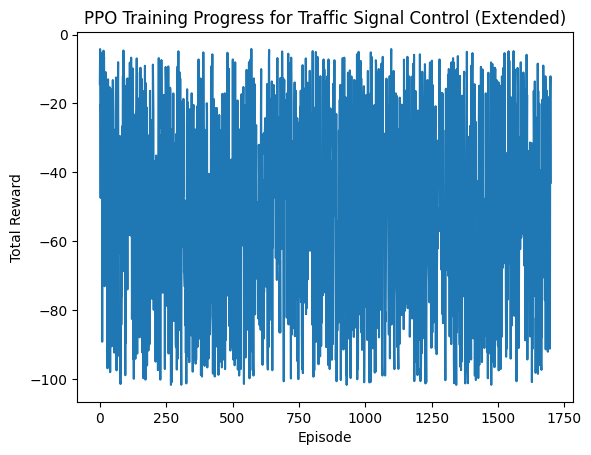

In [17]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("PPO Training Progress for Traffic Signal Control (Extended)")
plt.show()

In [ ]:
'''# Re-initialize the PPOAgent model structure
loaded_agent = PPOAgent(state_dim=len(data.columns)-1, action_dim=4)

# Load the state dictionary into the agent
loaded_agent.load_state_dict(torch.load("ppo_traffic_model.pt"))
loaded_agent.eval() # Set the model to evaluation mode

print("Model loaded successfully!")'''

In [ ]:
'''print("Continuing training for 500 more episodes...")
new_rewards = train_ppo(episodes=500)
rewards.extend(new_rewards)
print("Training complete.")'''

In [ ]:
'''torch.save(agent.state_dict(), "ppo_traffic_model.pt")
print("Model saved successfully!")'''

In [ ]:
'''plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("PPO Training Progress for Traffic Signal Control (Extended)")
plt.show()'''